In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
import random
from random import randint
import time
import os
import json
import csv
import os
import torch.nn as nn
import torch.nn.functional as F
import torch

# Data Preprocessing

Load manual coding data for 530 videos (Joo et al., 2019; Bucy et al., 2019)

In [2]:
df_label=pd.read_csv('debate1populism_Julian_timestep.csv')

In [3]:
df_label

timestep   v1  speaker  domint  topic1  topic2  frame  gainloss  debate  \
0    0:02:55    1        1     1.0     NaN     NaN    NaN       NaN       1   
1    0:03:05    2        1     1.0     NaN     NaN    7.0       1.0       1   
2    0:03:15    3        1     1.0     5.0    15.0    3.0       1.0       1   
3    0:03:25    4        1     1.0     5.0    15.0    3.0       1.0       1   
4    0:03:35    5        1     1.0     5.0    15.0    3.0       1.0       1   
..       ...  ...      ...     ...     ...     ...    ...       ...     ...   
525  1:30:25  526        1     2.0    34.0    19.0    6.0       0.0       1   
526  1:30:35  527        0     2.0    34.0    19.0    6.0       0.0       1   
527  1:30:45  528        2     2.0    34.0    19.0    6.0       0.0       1   
528  1:30:55  529        2     2.0    34.0    19.0    6.0       0.0       1   
529  1:31:05  530        2     2.0    34.0    19.0    6.0       0.0       1   

     hc_segtype  ...  DT_NONFLU2  DT_PUTD2  HC_POP_VIS  DT_POP_VIS  \
0             1  ...           0         0           0           0   
1             1  ...           0         0           0           0   
2             1  ...           0         0           0           1   
3             1  ...           0         0           0           1   
4             1  ...           0         0           0           0   
..          ...  ...         ...       ...         ...         ...   
525           1  ...           0         0           0           2   
526           1  ...           0         0           0           0   
527           1  ...           0         0           0           1   
528           2  ...           1         1           0           3   
529           2  ...           0         1           1           3   

     HC_POP_TON  DT_POP_TON  HC_POP_VER  DT_POP_VER  HC_POP_VER2  DT_POP_VER2  
0             0           0           0           0            0            0  
1             0           0           0           0            0            0  
2             0           0           0           0            0            0  
3             0           0           0           0            0            0  
4             0           0           0           0            0            0  
..          ...         ...         ...         ...          ...          ...  
525           0           1           0           0            0            0  
526           0           0           0           0            0            0  
527           0           0           0           0            0            0  
528           0           1           1           2            1            3  
529           0           1           0           1            0            2  

[530 rows x 146 columns]

In [4]:
dt_valid_columns = ['dt_lookat2', 'dt_brush1', 'dt_nvdis1', 'dt_lookat3',
       'dt_eyebrow', 'dt_atface', 'dt_feface', 'dt_hrface', 'dt_saface',
       'dt_neuface', 'dt_inapprop', 'dt_affgest', 'dt_defgest', 
       'dt_agentic', 'dt_waveoff', 'dt_nvtic1', 'dt_nvtic2',
       'dt_nvtic3', 'dt_nvtic5', 'dt_nvtic6', 
       'dt_interruptions']

hc_valid_columns = ['hc_' + x[3:] for x in dt_valid_columns]
#hc_valid_columns[3] = 'hc_look'

dt_label = df_label[dt_valid_columns]
#dt_label.fillna(0, inplace=True)
hc_label = df_label[hc_valid_columns]
#hc_label.fillna(0, inplace=True)

In [7]:
dt_label = dt_label.fillna(0)
dt_label[:]=np.where(dt_label<1,0,1)
dt_label

dt_lookat2  dt_brush1  dt_nvdis1  dt_lookat3  dt_eyebrow  dt_atface  \
0             1          0          0           1           1          0   
1             1          0          0           0           0          0   
2             1          0          1           1           0          0   
3             1          0          1           1           0          0   
4             1          0          0           1           0          0   
..          ...        ...        ...         ...         ...        ...   
525           1          0          1           1           1          1   
526           1          0          0           0           1          0   
527           1          0          0           0           1          0   
528           1          0          1           1           1          1   
529           1          0          1           1           1          1   

     dt_feface  dt_hrface  dt_saface  dt_neuface  ...  dt_affgest  dt_defgest  \
0            0          0          0           1  ...           0           0   
1            0          0          0           1  ...           0           0   
2            0          1          0           0  ...           0           0   
3            0          0          0           1  ...           0           0   
4            0          0          0           1  ...           0           0   
..         ...        ...        ...         ...  ...         ...         ...   
525          0          0          0           0  ...           0           0   
526          0          0          0           1  ...           0           0   
527          0          0          0           1  ...           0           1   
528          0          0          0           0  ...           0           1   
529          0          0          0           0  ...           0           1   

     dt_agentic  dt_waveoff  dt_nvtic1  dt_nvtic2  dt_nvtic3  dt_nvtic5  \
0             0           0          0          0          1          0   
1             0           0          0          0          1          0   
2             0           0          0          0          1          0   
3             0           0          1          1          1          0   
4             0           0          0          0          1          0   
..          ...         ...        ...        ...        ...        ...   
525           1           0          0          0          1          0   
526           0           0          0          1          1          0   
527           0           0          0          0          1          0   
528           1           0          0          0          0          0   
529           1           0          0          0          0          0   

     dt_nvtic6  dt_interruptions  
0            0                 0  
1            0                 0  
2            0                 0  
3            0                 0  
4            0                 0  
..         ...               ...  
525          0                 0  
526          0                 0  
527          0                 0  
528          0                 0  
529          0                 0  

[530 rows x 21 columns]

In [6]:
hc_label=hc_label.fillna(0)
hc_label[:]=np.where(hc_label<1,0,1)
hc_label

hc_lookat2  hc_brush1  hc_nvdis1  hc_lookat3  hc_eyebrow  hc_atface  \
0             0          0          0           1           1          0   
1             0          0          0           1           1          0   
2             0          0          0           1           1          0   
3             0          0          0           1           1          0   
4             0          0          0           1           1          0   
..          ...        ...        ...         ...         ...        ...   
525           0          0          0           1           1          0   
526           0          0          0           1           1          0   
527           0          0          0           1           1          0   
528           0          0          0           1           1          0   
529           0          0          1           1           0          0   

     hc_feface  hc_hrface  hc_saface  hc_neuface  ...  hc_affgest  hc_defgest  \
0            0          0          0           1  ...           0           0   
1            0          1          0           0  ...           0           0   
2            0          0          0           1  ...           0           0   
3            0          0          0           1  ...           0           0   
4            0          0          0           1  ...           0           0   
..         ...        ...        ...         ...  ...         ...         ...   
525          0          1          0           0  ...           0           0   
526          0          1          0           0  ...           0           0   
527          0          1          0           0  ...           0           0   
528          0          1          0           0  ...           0           0   
529          0          1          0           0  ...           0           0   

     hc_agentic  hc_waveoff  hc_nvtic1  hc_nvtic2  hc_nvtic3  hc_nvtic5  \
0             1           1          0          0          0          0   
1             1           0          0          0          0          0   
2             1           0          0          0          0          0   
3             1           0          0          0          0          0   
4             1           1          0          0          0          0   
..          ...         ...        ...        ...        ...        ...   
525           1           0          0          0          0          0   
526           1           0          0          0          0          0   
527           1           0          0          0          0          0   
528           0           0          0          1          0          0   
529           0           0          1          0          0          0   

     hc_nvtic6  hc_interruptions  
0            0                 0  
1            0                 0  
2            0                 0  
3            0                 0  
4            0                 0  
..         ...               ...  
525          0                 0  
526          0                 0  
527          0                 0  
528          0                 0  
529          0                 0  

[530 rows x 21 columns]

#### Load OpenPose Data

In [8]:
path_to_json = 'Debate_Video/'

json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
json_files.sort()

#paths = sorted(Path(dirpath).iterdir(), key=os.path.getmtime)

dt=[]
hc=[]
flip=0
noise=0

for i in range(530):
    dt_intervals=[]
    hc_intervals=[]
    for j in range(300):
        file_name = 'clip'+str(i+1)+'_000000000'+"{0:03}".format(j)+'_keypoints.json'
        print(file_name)
        with open('Debate_Video/'+file_name) as json_data:
            op = json.load(json_data)
            people = op['people']
            if len(people) == 2:
                if people[0]['pose_keypoints_2d'][0] < people[1]['pose_keypoints_2d'][0]:
                    dt_key = people[0]
                    hc_key = people[1]
                else:
                    dt_key = people[1]
                    hc_key = people[0]
                    flip = flip+1
                    print(flip,'flip')
                    
                del dt_key['pose_keypoints_2d'][2::3]
                del dt_key['face_keypoints_2d'][2::3]
                del hc_key['pose_keypoints_2d'][2::3]
                del hc_key['face_keypoints_2d'][2::3]
                
                dt_keypoints = dt_key['pose_keypoints_2d'][:14]+dt_key['pose_keypoints_2d'][30:38]+dt_key['face_keypoints_2d']
                hc_keypoints = hc_key['pose_keypoints_2d'][:14]+hc_key['pose_keypoints_2d'][30:38]+hc_key['face_keypoints_2d']
            else:
                noise = noise+1
                print(noise,'noise')
                
        dt_intervals.append(dt_keypoints)
        hc_intervals.append(hc_keypoints)
    
    dt.append(dt_intervals)
    hc.append(hc_intervals)


clip1_000000000000_keypoints.json
clip1_000000000001_keypoints.json
clip1_000000000002_keypoints.json
1 flip
clip1_000000000003_keypoints.json
clip1_000000000004_keypoints.json
clip1_000000000005_keypoints.json
clip1_000000000006_keypoints.json
clip1_000000000007_keypoints.json
clip1_000000000008_keypoints.json
2 flip
clip1_000000000009_keypoints.json
clip1_000000000010_keypoints.json
3 flip
clip1_000000000011_keypoints.json
4 flip
clip1_000000000012_keypoints.json
5 flip
clip1_000000000013_keypoints.json
6 flip
clip1_000000000014_keypoints.json
7 flip
clip1_000000000015_keypoints.json
8 flip
clip1_000000000016_keypoints.json
9 flip
clip1_000000000017_keypoints.json
10 flip
clip1_000000000018_keypoints.json
11 flip
clip1_000000000019_keypoints.json
12 flip
clip1_000000000020_keypoints.json
13 flip
clip1_000000000021_keypoints.json
14 flip
clip1_000000000022_keypoints.json
15 flip
clip1_000000000023_keypoints.json
16 flip
clip1_000000000024_keypoints.json
17 flip
clip1_000000000025_keyp

clip2_000000000238_keypoints.json
425 flip
clip2_000000000239_keypoints.json
426 flip
clip2_000000000240_keypoints.json
427 flip
clip2_000000000241_keypoints.json
428 flip
clip2_000000000242_keypoints.json
429 flip
clip2_000000000243_keypoints.json
clip2_000000000244_keypoints.json
430 flip
clip2_000000000245_keypoints.json
431 flip
clip2_000000000246_keypoints.json
432 flip
clip2_000000000247_keypoints.json
433 flip
clip2_000000000248_keypoints.json
434 flip
clip2_000000000249_keypoints.json
435 flip
clip2_000000000250_keypoints.json
436 flip
clip2_000000000251_keypoints.json
437 flip
clip2_000000000252_keypoints.json
438 flip
clip2_000000000253_keypoints.json
439 flip
clip2_000000000254_keypoints.json
440 flip
clip2_000000000255_keypoints.json
441 flip
clip2_000000000256_keypoints.json
442 flip
clip2_000000000257_keypoints.json
443 flip
clip2_000000000258_keypoints.json
444 flip
clip2_000000000259_keypoints.json
445 flip
clip2_000000000260_keypoints.json
446 flip
clip2_000000000261_k

clip4_000000000237_keypoints.json
876 flip
clip4_000000000238_keypoints.json
877 flip
clip4_000000000239_keypoints.json
878 flip
clip4_000000000240_keypoints.json
879 flip
clip4_000000000241_keypoints.json
880 flip
clip4_000000000242_keypoints.json
881 flip
clip4_000000000243_keypoints.json
882 flip
clip4_000000000244_keypoints.json
883 flip
clip4_000000000245_keypoints.json
884 flip
clip4_000000000246_keypoints.json
885 flip
clip4_000000000247_keypoints.json
886 flip
clip4_000000000248_keypoints.json
887 flip
clip4_000000000249_keypoints.json
888 flip
clip4_000000000250_keypoints.json
clip4_000000000251_keypoints.json
clip4_000000000252_keypoints.json
889 flip
clip4_000000000253_keypoints.json
890 flip
clip4_000000000254_keypoints.json
891 flip
clip4_000000000255_keypoints.json
892 flip
clip4_000000000256_keypoints.json
clip4_000000000257_keypoints.json
clip4_000000000258_keypoints.json
893 flip
clip4_000000000259_keypoints.json
894 flip
clip4_000000000260_keypoints.json
895 flip
clip

clip6_000000000237_keypoints.json
1285 flip
clip6_000000000238_keypoints.json
1286 flip
clip6_000000000239_keypoints.json
clip6_000000000240_keypoints.json
clip6_000000000241_keypoints.json
clip6_000000000242_keypoints.json
1287 flip
clip6_000000000243_keypoints.json
1288 flip
clip6_000000000244_keypoints.json
clip6_000000000245_keypoints.json
1289 flip
clip6_000000000246_keypoints.json
1290 flip
clip6_000000000247_keypoints.json
1291 flip
clip6_000000000248_keypoints.json
1292 flip
clip6_000000000249_keypoints.json
1293 flip
clip6_000000000250_keypoints.json
1294 flip
clip6_000000000251_keypoints.json
1295 flip
clip6_000000000252_keypoints.json
1296 flip
clip6_000000000253_keypoints.json
1297 flip
clip6_000000000254_keypoints.json
1298 flip
clip6_000000000255_keypoints.json
1299 flip
clip6_000000000256_keypoints.json
1300 flip
clip6_000000000257_keypoints.json
1301 flip
clip6_000000000258_keypoints.json
1302 flip
clip6_000000000259_keypoints.json
1303 flip
clip6_000000000260_keypoints

1748 flip
clip8_000000000208_keypoints.json
1749 flip
clip8_000000000209_keypoints.json
1750 flip
clip8_000000000210_keypoints.json
1751 flip
clip8_000000000211_keypoints.json
1752 flip
clip8_000000000212_keypoints.json
1753 flip
clip8_000000000213_keypoints.json
1754 flip
clip8_000000000214_keypoints.json
1755 flip
clip8_000000000215_keypoints.json
1756 flip
clip8_000000000216_keypoints.json
1757 flip
clip8_000000000217_keypoints.json
1758 flip
clip8_000000000218_keypoints.json
1759 flip
clip8_000000000219_keypoints.json
1760 flip
clip8_000000000220_keypoints.json
1761 flip
clip8_000000000221_keypoints.json
1762 flip
clip8_000000000222_keypoints.json
1763 flip
clip8_000000000223_keypoints.json
1764 flip
clip8_000000000224_keypoints.json
1765 flip
clip8_000000000225_keypoints.json
1766 flip
clip8_000000000226_keypoints.json
clip8_000000000227_keypoints.json
1767 flip
clip8_000000000228_keypoints.json
clip8_000000000229_keypoints.json
1768 flip
clip8_000000000230_keypoints.json
1769 fli

2169 flip
clip10_000000000190_keypoints.json
clip10_000000000191_keypoints.json
clip10_000000000192_keypoints.json
clip10_000000000193_keypoints.json
clip10_000000000194_keypoints.json
clip10_000000000195_keypoints.json
clip10_000000000196_keypoints.json
clip10_000000000197_keypoints.json
2170 flip
clip10_000000000198_keypoints.json
2171 flip
clip10_000000000199_keypoints.json
2172 flip
clip10_000000000200_keypoints.json
2173 flip
clip10_000000000201_keypoints.json
2174 flip
clip10_000000000202_keypoints.json
2175 flip
clip10_000000000203_keypoints.json
2176 flip
clip10_000000000204_keypoints.json
2177 flip
clip10_000000000205_keypoints.json
2178 flip
clip10_000000000206_keypoints.json
clip10_000000000207_keypoints.json
clip10_000000000208_keypoints.json
clip10_000000000209_keypoints.json
clip10_000000000210_keypoints.json
clip10_000000000211_keypoints.json
clip10_000000000212_keypoints.json
clip10_000000000213_keypoints.json
clip10_000000000214_keypoints.json
clip10_000000000215_keypo

clip12_000000000195_keypoints.json
2550 flip
clip12_000000000196_keypoints.json
clip12_000000000197_keypoints.json
clip12_000000000198_keypoints.json
clip12_000000000199_keypoints.json
clip12_000000000200_keypoints.json
2551 flip
clip12_000000000201_keypoints.json
2552 flip
clip12_000000000202_keypoints.json
2553 flip
clip12_000000000203_keypoints.json
2554 flip
clip12_000000000204_keypoints.json
2555 flip
clip12_000000000205_keypoints.json
2556 flip
clip12_000000000206_keypoints.json
2557 flip
clip12_000000000207_keypoints.json
2558 flip
clip12_000000000208_keypoints.json
2559 flip
clip12_000000000209_keypoints.json
2560 flip
clip12_000000000210_keypoints.json
clip12_000000000211_keypoints.json
clip12_000000000212_keypoints.json
clip12_000000000213_keypoints.json
2561 flip
clip12_000000000214_keypoints.json
2562 flip
clip12_000000000215_keypoints.json
2563 flip
clip12_000000000216_keypoints.json
2564 flip
clip12_000000000217_keypoints.json
2565 flip
clip12_000000000218_keypoints.json


3021 flip
clip14_000000000135_keypoints.json
3022 flip
clip14_000000000136_keypoints.json
3023 flip
clip14_000000000137_keypoints.json
3024 flip
clip14_000000000138_keypoints.json
3025 flip
clip14_000000000139_keypoints.json
3026 flip
clip14_000000000140_keypoints.json
3027 flip
clip14_000000000141_keypoints.json
3028 flip
clip14_000000000142_keypoints.json
3029 flip
clip14_000000000143_keypoints.json
3030 flip
clip14_000000000144_keypoints.json
3031 flip
clip14_000000000145_keypoints.json
3032 flip
clip14_000000000146_keypoints.json
3033 flip
clip14_000000000147_keypoints.json
3034 flip
clip14_000000000148_keypoints.json
3035 flip
clip14_000000000149_keypoints.json
3036 flip
clip14_000000000150_keypoints.json
3037 flip
clip14_000000000151_keypoints.json
3038 flip
clip14_000000000152_keypoints.json
3039 flip
clip14_000000000153_keypoints.json
3040 flip
clip14_000000000154_keypoints.json
3041 flip
clip14_000000000155_keypoints.json
3042 flip
clip14_000000000156_keypoints.json
3043 flip


3516 flip
clip16_000000000103_keypoints.json
3517 flip
clip16_000000000104_keypoints.json
3518 flip
clip16_000000000105_keypoints.json
3519 flip
clip16_000000000106_keypoints.json
3520 flip
clip16_000000000107_keypoints.json
3521 flip
clip16_000000000108_keypoints.json
3522 flip
clip16_000000000109_keypoints.json
3523 flip
clip16_000000000110_keypoints.json
3524 flip
clip16_000000000111_keypoints.json
3525 flip
clip16_000000000112_keypoints.json
clip16_000000000113_keypoints.json
clip16_000000000114_keypoints.json
clip16_000000000115_keypoints.json
clip16_000000000116_keypoints.json
clip16_000000000117_keypoints.json
clip16_000000000118_keypoints.json
3526 flip
clip16_000000000119_keypoints.json
3527 flip
clip16_000000000120_keypoints.json
3528 flip
clip16_000000000121_keypoints.json
3529 flip
clip16_000000000122_keypoints.json
clip16_000000000123_keypoints.json
clip16_000000000124_keypoints.json
3530 flip
clip16_000000000125_keypoints.json
3531 flip
clip16_000000000126_keypoints.json


clip18_000000000129_keypoints.json
3804 flip
clip18_000000000130_keypoints.json
3805 flip
clip18_000000000131_keypoints.json
3806 flip
clip18_000000000132_keypoints.json
clip18_000000000133_keypoints.json
clip18_000000000134_keypoints.json
clip18_000000000135_keypoints.json
clip18_000000000136_keypoints.json
clip18_000000000137_keypoints.json
3807 flip
clip18_000000000138_keypoints.json
clip18_000000000139_keypoints.json
3808 flip
clip18_000000000140_keypoints.json
clip18_000000000141_keypoints.json
clip18_000000000142_keypoints.json
clip18_000000000143_keypoints.json
3809 flip
clip18_000000000144_keypoints.json
clip18_000000000145_keypoints.json
clip18_000000000146_keypoints.json
clip18_000000000147_keypoints.json
clip18_000000000148_keypoints.json
clip18_000000000149_keypoints.json
clip18_000000000150_keypoints.json
clip18_000000000151_keypoints.json
clip18_000000000152_keypoints.json
clip18_000000000153_keypoints.json
clip18_000000000154_keypoints.json
clip18_000000000155_keypoints.

clip20_000000000163_keypoints.json
3992 flip
clip20_000000000164_keypoints.json
3993 flip
clip20_000000000165_keypoints.json
3994 flip
clip20_000000000166_keypoints.json
3995 flip
clip20_000000000167_keypoints.json
3996 flip
clip20_000000000168_keypoints.json
3997 flip
clip20_000000000169_keypoints.json
3998 flip
clip20_000000000170_keypoints.json
3999 flip
clip20_000000000171_keypoints.json
4000 flip
clip20_000000000172_keypoints.json
4001 flip
clip20_000000000173_keypoints.json
4002 flip
clip20_000000000174_keypoints.json
4003 flip
clip20_000000000175_keypoints.json
4004 flip
clip20_000000000176_keypoints.json
4005 flip
clip20_000000000177_keypoints.json
4006 flip
clip20_000000000178_keypoints.json
4007 flip
clip20_000000000179_keypoints.json
4008 flip
clip20_000000000180_keypoints.json
4009 flip
clip20_000000000181_keypoints.json
4010 flip
clip20_000000000182_keypoints.json
4011 flip
clip20_000000000183_keypoints.json
4012 flip
clip20_000000000184_keypoints.json
4013 flip
clip20_000

clip22_000000000155_keypoints.json
clip22_000000000156_keypoints.json
clip22_000000000157_keypoints.json
clip22_000000000158_keypoints.json
clip22_000000000159_keypoints.json
4350 flip
clip22_000000000160_keypoints.json
4351 flip
clip22_000000000161_keypoints.json
4352 flip
clip22_000000000162_keypoints.json
4353 flip
clip22_000000000163_keypoints.json
clip22_000000000164_keypoints.json
clip22_000000000165_keypoints.json
4354 flip
clip22_000000000166_keypoints.json
4355 flip
clip22_000000000167_keypoints.json
clip22_000000000168_keypoints.json
clip22_000000000169_keypoints.json
clip22_000000000170_keypoints.json
clip22_000000000171_keypoints.json
clip22_000000000172_keypoints.json
clip22_000000000173_keypoints.json
4356 flip
clip22_000000000174_keypoints.json
clip22_000000000175_keypoints.json
clip22_000000000176_keypoints.json
clip22_000000000177_keypoints.json
clip22_000000000178_keypoints.json
clip22_000000000179_keypoints.json
clip22_000000000180_keypoints.json
clip22_000000000181_

clip24_000000000230_keypoints.json
4607 flip
clip24_000000000231_keypoints.json
4608 flip
clip24_000000000232_keypoints.json
4609 flip
clip24_000000000233_keypoints.json
4610 flip
clip24_000000000234_keypoints.json
4611 flip
clip24_000000000235_keypoints.json
4612 flip
clip24_000000000236_keypoints.json
4613 flip
clip24_000000000237_keypoints.json
4614 flip
clip24_000000000238_keypoints.json
4615 flip
clip24_000000000239_keypoints.json
4616 flip
clip24_000000000240_keypoints.json
4617 flip
clip24_000000000241_keypoints.json
4618 flip
clip24_000000000242_keypoints.json
4619 flip
clip24_000000000243_keypoints.json
4620 flip
clip24_000000000244_keypoints.json
4621 flip
clip24_000000000245_keypoints.json
4622 flip
clip24_000000000246_keypoints.json
4623 flip
clip24_000000000247_keypoints.json
4624 flip
clip24_000000000248_keypoints.json
clip24_000000000249_keypoints.json
4625 flip
clip24_000000000250_keypoints.json
clip24_000000000251_keypoints.json
clip24_000000000252_keypoints.json
4626 

clip26_000000000295_keypoints.json
4861 flip
clip26_000000000296_keypoints.json
4862 flip
clip26_000000000297_keypoints.json
4863 flip
clip26_000000000298_keypoints.json
4864 flip
clip26_000000000299_keypoints.json
4865 flip
clip27_000000000000_keypoints.json
4866 flip
clip27_000000000001_keypoints.json
4867 flip
clip27_000000000002_keypoints.json
4868 flip
clip27_000000000003_keypoints.json
clip27_000000000004_keypoints.json
4869 flip
clip27_000000000005_keypoints.json
4870 flip
clip27_000000000006_keypoints.json
4871 flip
clip27_000000000007_keypoints.json
4872 flip
clip27_000000000008_keypoints.json
4873 flip
clip27_000000000009_keypoints.json
4874 flip
clip27_000000000010_keypoints.json
4875 flip
clip27_000000000011_keypoints.json
4876 flip
clip27_000000000012_keypoints.json
4877 flip
clip27_000000000013_keypoints.json
clip27_000000000014_keypoints.json
clip27_000000000015_keypoints.json
clip27_000000000016_keypoints.json
clip27_000000000017_keypoints.json
clip27_000000000018_keypo

5220 flip
clip29_000000000008_keypoints.json
clip29_000000000009_keypoints.json
clip29_000000000010_keypoints.json
clip29_000000000011_keypoints.json
clip29_000000000012_keypoints.json
clip29_000000000013_keypoints.json
clip29_000000000014_keypoints.json
clip29_000000000015_keypoints.json
clip29_000000000016_keypoints.json
clip29_000000000017_keypoints.json
clip29_000000000018_keypoints.json
clip29_000000000019_keypoints.json
clip29_000000000020_keypoints.json
clip29_000000000021_keypoints.json
clip29_000000000022_keypoints.json
clip29_000000000023_keypoints.json
clip29_000000000024_keypoints.json
5221 flip
clip29_000000000025_keypoints.json
5222 flip
clip29_000000000026_keypoints.json
5223 flip
clip29_000000000027_keypoints.json
5224 flip
clip29_000000000028_keypoints.json
5225 flip
clip29_000000000029_keypoints.json
clip29_000000000030_keypoints.json
5226 flip
clip29_000000000031_keypoints.json
clip29_000000000032_keypoints.json
clip29_000000000033_keypoints.json
clip29_000000000034_

clip31_000000000039_keypoints.json
5563 flip
clip31_000000000040_keypoints.json
5564 flip
clip31_000000000041_keypoints.json
5565 flip
clip31_000000000042_keypoints.json
5566 flip
clip31_000000000043_keypoints.json
5567 flip
clip31_000000000044_keypoints.json
5568 flip
clip31_000000000045_keypoints.json
5569 flip
clip31_000000000046_keypoints.json
5570 flip
clip31_000000000047_keypoints.json
5571 flip
clip31_000000000048_keypoints.json
clip31_000000000049_keypoints.json
clip31_000000000050_keypoints.json
clip31_000000000051_keypoints.json
clip31_000000000052_keypoints.json
clip31_000000000053_keypoints.json
clip31_000000000054_keypoints.json
clip31_000000000055_keypoints.json
clip31_000000000056_keypoints.json
clip31_000000000057_keypoints.json
clip31_000000000058_keypoints.json
clip31_000000000059_keypoints.json
clip31_000000000060_keypoints.json
clip31_000000000061_keypoints.json
clip31_000000000062_keypoints.json
5572 flip
clip31_000000000063_keypoints.json
clip31_000000000064_keypo

clip33_000000000016_keypoints.json
5879 flip
clip33_000000000017_keypoints.json
5880 flip
clip33_000000000018_keypoints.json
5881 flip
clip33_000000000019_keypoints.json
clip33_000000000020_keypoints.json
5882 flip
clip33_000000000021_keypoints.json
clip33_000000000022_keypoints.json
clip33_000000000023_keypoints.json
clip33_000000000024_keypoints.json
5883 flip
clip33_000000000025_keypoints.json
5884 flip
clip33_000000000026_keypoints.json
clip33_000000000027_keypoints.json
5885 flip
clip33_000000000028_keypoints.json
5886 flip
clip33_000000000029_keypoints.json
5887 flip
clip33_000000000030_keypoints.json
5888 flip
clip33_000000000031_keypoints.json
5889 flip
clip33_000000000032_keypoints.json
5890 flip
clip33_000000000033_keypoints.json
5891 flip
clip33_000000000034_keypoints.json
5892 flip
clip33_000000000035_keypoints.json
5893 flip
clip33_000000000036_keypoints.json
5894 flip
clip33_000000000037_keypoints.json
5895 flip
clip33_000000000038_keypoints.json
5896 flip
clip33_00000000

clip34_000000000152_keypoints.json
6146 flip
clip34_000000000153_keypoints.json
6147 flip
clip34_000000000154_keypoints.json
6148 flip
clip34_000000000155_keypoints.json
6149 flip
clip34_000000000156_keypoints.json
6150 flip
clip34_000000000157_keypoints.json
6151 flip
clip34_000000000158_keypoints.json
6152 flip
clip34_000000000159_keypoints.json
6153 flip
clip34_000000000160_keypoints.json
6154 flip
clip34_000000000161_keypoints.json
6155 flip
clip34_000000000162_keypoints.json
6156 flip
clip34_000000000163_keypoints.json
6157 flip
clip34_000000000164_keypoints.json
6158 flip
clip34_000000000165_keypoints.json
6159 flip
clip34_000000000166_keypoints.json
6160 flip
clip34_000000000167_keypoints.json
6161 flip
clip34_000000000168_keypoints.json
6162 flip
clip34_000000000169_keypoints.json
6163 flip
clip34_000000000170_keypoints.json
6164 flip
clip34_000000000171_keypoints.json
6165 flip
clip34_000000000172_keypoints.json
6166 flip
clip34_000000000173_keypoints.json
6167 flip
clip34_000

clip36_000000000106_keypoints.json
6552 flip
clip36_000000000107_keypoints.json
6553 flip
clip36_000000000108_keypoints.json
6554 flip
clip36_000000000109_keypoints.json
6555 flip
clip36_000000000110_keypoints.json
6556 flip
clip36_000000000111_keypoints.json
6557 flip
clip36_000000000112_keypoints.json
6558 flip
clip36_000000000113_keypoints.json
6559 flip
clip36_000000000114_keypoints.json
6560 flip
clip36_000000000115_keypoints.json
6561 flip
clip36_000000000116_keypoints.json
6562 flip
clip36_000000000117_keypoints.json
6563 flip
clip36_000000000118_keypoints.json
6564 flip
clip36_000000000119_keypoints.json
6565 flip
clip36_000000000120_keypoints.json
6566 flip
clip36_000000000121_keypoints.json
6567 flip
clip36_000000000122_keypoints.json
6568 flip
clip36_000000000123_keypoints.json
6569 flip
clip36_000000000124_keypoints.json
6570 flip
clip36_000000000125_keypoints.json
6571 flip
clip36_000000000126_keypoints.json
6572 flip
clip36_000000000127_keypoints.json
6573 flip
clip36_000

7001 flip
clip38_000000000074_keypoints.json
7002 flip
clip38_000000000075_keypoints.json
7003 flip
clip38_000000000076_keypoints.json
7004 flip
clip38_000000000077_keypoints.json
7005 flip
clip38_000000000078_keypoints.json
7006 flip
clip38_000000000079_keypoints.json
7007 flip
clip38_000000000080_keypoints.json
7008 flip
clip38_000000000081_keypoints.json
7009 flip
clip38_000000000082_keypoints.json
7010 flip
clip38_000000000083_keypoints.json
7011 flip
clip38_000000000084_keypoints.json
7012 flip
clip38_000000000085_keypoints.json
7013 flip
clip38_000000000086_keypoints.json
7014 flip
clip38_000000000087_keypoints.json
7015 flip
clip38_000000000088_keypoints.json
7016 flip
clip38_000000000089_keypoints.json
7017 flip
clip38_000000000090_keypoints.json
7018 flip
clip38_000000000091_keypoints.json
7019 flip
clip38_000000000092_keypoints.json
7020 flip
clip38_000000000093_keypoints.json
7021 flip
clip38_000000000094_keypoints.json
7022 flip
clip38_000000000095_keypoints.json
7023 flip


clip40_000000000023_keypoints.json
clip40_000000000024_keypoints.json
7484 flip
clip40_000000000025_keypoints.json
7485 flip
clip40_000000000026_keypoints.json
7486 flip
clip40_000000000027_keypoints.json
7487 flip
clip40_000000000028_keypoints.json
7488 flip
clip40_000000000029_keypoints.json
7489 flip
clip40_000000000030_keypoints.json
7490 flip
clip40_000000000031_keypoints.json
7491 flip
clip40_000000000032_keypoints.json
7492 flip
clip40_000000000033_keypoints.json
7493 flip
clip40_000000000034_keypoints.json
7494 flip
clip40_000000000035_keypoints.json
clip40_000000000036_keypoints.json
clip40_000000000037_keypoints.json
7495 flip
clip40_000000000038_keypoints.json
7496 flip
clip40_000000000039_keypoints.json
7497 flip
clip40_000000000040_keypoints.json
7498 flip
clip40_000000000041_keypoints.json
7499 flip
clip40_000000000042_keypoints.json
7500 flip
clip40_000000000043_keypoints.json
7501 flip
clip40_000000000044_keypoints.json
7502 flip
clip40_000000000045_keypoints.json
7503 

clip42_000000000178_keypoints.json
clip42_000000000179_keypoints.json
clip42_000000000180_keypoints.json
clip42_000000000181_keypoints.json
clip42_000000000182_keypoints.json
clip42_000000000183_keypoints.json
clip42_000000000184_keypoints.json
clip42_000000000185_keypoints.json
clip42_000000000186_keypoints.json
clip42_000000000187_keypoints.json
clip42_000000000188_keypoints.json
clip42_000000000189_keypoints.json
clip42_000000000190_keypoints.json
clip42_000000000191_keypoints.json
clip42_000000000192_keypoints.json
clip42_000000000193_keypoints.json
clip42_000000000194_keypoints.json
clip42_000000000195_keypoints.json
clip42_000000000196_keypoints.json
clip42_000000000197_keypoints.json
clip42_000000000198_keypoints.json
clip42_000000000199_keypoints.json
clip42_000000000200_keypoints.json
clip42_000000000201_keypoints.json
clip42_000000000202_keypoints.json
clip42_000000000203_keypoints.json
clip42_000000000204_keypoints.json
clip42_000000000205_keypoints.json
clip42_000000000206_

clip44_000000000265_keypoints.json
clip44_000000000266_keypoints.json
clip44_000000000267_keypoints.json
clip44_000000000268_keypoints.json
clip44_000000000269_keypoints.json
clip44_000000000270_keypoints.json
clip44_000000000271_keypoints.json
clip44_000000000272_keypoints.json
clip44_000000000273_keypoints.json
clip44_000000000274_keypoints.json
clip44_000000000275_keypoints.json
clip44_000000000276_keypoints.json
7838 flip
clip44_000000000277_keypoints.json
7839 flip
clip44_000000000278_keypoints.json
clip44_000000000279_keypoints.json
clip44_000000000280_keypoints.json
clip44_000000000281_keypoints.json
7840 flip
clip44_000000000282_keypoints.json
7841 flip
clip44_000000000283_keypoints.json
clip44_000000000284_keypoints.json
clip44_000000000285_keypoints.json
clip44_000000000286_keypoints.json
clip44_000000000287_keypoints.json
clip44_000000000288_keypoints.json
clip44_000000000289_keypoints.json
clip44_000000000290_keypoints.json
clip44_000000000291_keypoints.json
clip44_00000000

clip47_000000000082_keypoints.json
clip47_000000000083_keypoints.json
clip47_000000000084_keypoints.json
clip47_000000000085_keypoints.json
clip47_000000000086_keypoints.json
clip47_000000000087_keypoints.json
clip47_000000000088_keypoints.json
clip47_000000000089_keypoints.json
clip47_000000000090_keypoints.json
clip47_000000000091_keypoints.json
clip47_000000000092_keypoints.json
clip47_000000000093_keypoints.json
clip47_000000000094_keypoints.json
clip47_000000000095_keypoints.json
clip47_000000000096_keypoints.json
clip47_000000000097_keypoints.json
clip47_000000000098_keypoints.json
clip47_000000000099_keypoints.json
clip47_000000000100_keypoints.json
clip47_000000000101_keypoints.json
clip47_000000000102_keypoints.json
clip47_000000000103_keypoints.json
clip47_000000000104_keypoints.json
clip47_000000000105_keypoints.json
clip47_000000000106_keypoints.json
clip47_000000000107_keypoints.json
clip47_000000000108_keypoints.json
clip47_000000000109_keypoints.json
clip47_000000000110_

clip49_000000000184_keypoints.json
clip49_000000000185_keypoints.json
clip49_000000000186_keypoints.json
clip49_000000000187_keypoints.json
clip49_000000000188_keypoints.json
clip49_000000000189_keypoints.json
clip49_000000000190_keypoints.json
clip49_000000000191_keypoints.json
clip49_000000000192_keypoints.json
clip49_000000000193_keypoints.json
clip49_000000000194_keypoints.json
8076 flip
clip49_000000000195_keypoints.json
8077 flip
clip49_000000000196_keypoints.json
clip49_000000000197_keypoints.json
clip49_000000000198_keypoints.json
clip49_000000000199_keypoints.json
clip49_000000000200_keypoints.json
clip49_000000000201_keypoints.json
clip49_000000000202_keypoints.json
clip49_000000000203_keypoints.json
clip49_000000000204_keypoints.json
clip49_000000000205_keypoints.json
clip49_000000000206_keypoints.json
clip49_000000000207_keypoints.json
clip49_000000000208_keypoints.json
clip49_000000000209_keypoints.json
clip49_000000000210_keypoints.json
clip49_000000000211_keypoints.json


clip51_000000000270_keypoints.json
8339 flip
clip51_000000000271_keypoints.json
8340 flip
clip51_000000000272_keypoints.json
8341 flip
clip51_000000000273_keypoints.json
8342 flip
clip51_000000000274_keypoints.json
8343 flip
clip51_000000000275_keypoints.json
8344 flip
clip51_000000000276_keypoints.json
8345 flip
clip51_000000000277_keypoints.json
8346 flip
clip51_000000000278_keypoints.json
8347 flip
clip51_000000000279_keypoints.json
8348 flip
clip51_000000000280_keypoints.json
8349 flip
clip51_000000000281_keypoints.json
8350 flip
clip51_000000000282_keypoints.json
8351 flip
clip51_000000000283_keypoints.json
8352 flip
clip51_000000000284_keypoints.json
8353 flip
clip51_000000000285_keypoints.json
8354 flip
clip51_000000000286_keypoints.json
clip51_000000000287_keypoints.json
clip51_000000000288_keypoints.json
clip51_000000000289_keypoints.json
8355 flip
clip51_000000000290_keypoints.json
8356 flip
clip51_000000000291_keypoints.json
clip51_000000000292_keypoints.json
clip51_00000000

clip54_000000000064_keypoints.json
clip54_000000000065_keypoints.json
clip54_000000000066_keypoints.json
clip54_000000000067_keypoints.json
clip54_000000000068_keypoints.json
clip54_000000000069_keypoints.json
clip54_000000000070_keypoints.json
clip54_000000000071_keypoints.json
clip54_000000000072_keypoints.json
clip54_000000000073_keypoints.json
clip54_000000000074_keypoints.json
clip54_000000000075_keypoints.json
clip54_000000000076_keypoints.json
clip54_000000000077_keypoints.json
clip54_000000000078_keypoints.json
clip54_000000000079_keypoints.json
clip54_000000000080_keypoints.json
clip54_000000000081_keypoints.json
clip54_000000000082_keypoints.json
clip54_000000000083_keypoints.json
clip54_000000000084_keypoints.json
clip54_000000000085_keypoints.json
clip54_000000000086_keypoints.json
8540 flip
clip54_000000000087_keypoints.json
clip54_000000000088_keypoints.json
8541 flip
clip54_000000000089_keypoints.json
8542 flip
clip54_000000000090_keypoints.json
8543 flip
clip54_00000000

clip56_000000000089_keypoints.json
8837 flip
clip56_000000000090_keypoints.json
8838 flip
clip56_000000000091_keypoints.json
8839 flip
clip56_000000000092_keypoints.json
8840 flip
clip56_000000000093_keypoints.json
8841 flip
clip56_000000000094_keypoints.json
8842 flip
clip56_000000000095_keypoints.json
clip56_000000000096_keypoints.json
8843 flip
clip56_000000000097_keypoints.json
clip56_000000000098_keypoints.json
clip56_000000000099_keypoints.json
clip56_000000000100_keypoints.json
8844 flip
clip56_000000000101_keypoints.json
8845 flip
clip56_000000000102_keypoints.json
8846 flip
clip56_000000000103_keypoints.json
8847 flip
clip56_000000000104_keypoints.json
clip56_000000000105_keypoints.json
clip56_000000000106_keypoints.json
clip56_000000000107_keypoints.json
clip56_000000000108_keypoints.json
clip56_000000000109_keypoints.json
clip56_000000000110_keypoints.json
clip56_000000000111_keypoints.json
clip56_000000000112_keypoints.json
clip56_000000000113_keypoints.json
clip56_00000000

clip58_000000000102_keypoints.json
9178 flip
clip58_000000000103_keypoints.json
9179 flip
clip58_000000000104_keypoints.json
9180 flip
clip58_000000000105_keypoints.json
9181 flip
clip58_000000000106_keypoints.json
clip58_000000000107_keypoints.json
9182 flip
clip58_000000000108_keypoints.json
9183 flip
clip58_000000000109_keypoints.json
9184 flip
clip58_000000000110_keypoints.json
9185 flip
clip58_000000000111_keypoints.json
9186 flip
clip58_000000000112_keypoints.json
clip58_000000000113_keypoints.json
clip58_000000000114_keypoints.json
9187 flip
clip58_000000000115_keypoints.json
clip58_000000000116_keypoints.json
clip58_000000000117_keypoints.json
clip58_000000000118_keypoints.json
clip58_000000000119_keypoints.json
9188 flip
clip58_000000000120_keypoints.json
9189 flip
clip58_000000000121_keypoints.json
9190 flip
clip58_000000000122_keypoints.json
9191 flip
clip58_000000000123_keypoints.json
9192 flip
clip58_000000000124_keypoints.json
9193 flip
clip58_000000000125_keypoints.json


9544 flip
clip60_000000000099_keypoints.json
9545 flip
clip60_000000000100_keypoints.json
9546 flip
clip60_000000000101_keypoints.json
9547 flip
clip60_000000000102_keypoints.json
9548 flip
clip60_000000000103_keypoints.json
9549 flip
clip60_000000000104_keypoints.json
9550 flip
clip60_000000000105_keypoints.json
9551 flip
clip60_000000000106_keypoints.json
9552 flip
clip60_000000000107_keypoints.json
9553 flip
clip60_000000000108_keypoints.json
9554 flip
clip60_000000000109_keypoints.json
9555 flip
clip60_000000000110_keypoints.json
9556 flip
clip60_000000000111_keypoints.json
9557 flip
clip60_000000000112_keypoints.json
9558 flip
clip60_000000000113_keypoints.json
clip60_000000000114_keypoints.json
9559 flip
clip60_000000000115_keypoints.json
clip60_000000000116_keypoints.json
clip60_000000000117_keypoints.json
clip60_000000000118_keypoints.json
clip60_000000000119_keypoints.json
9560 flip
clip60_000000000120_keypoints.json
9561 flip
clip60_000000000121_keypoints.json
9562 flip
clip6

9957 flip
clip62_000000000047_keypoints.json
9958 flip
clip62_000000000048_keypoints.json
9959 flip
clip62_000000000049_keypoints.json
9960 flip
clip62_000000000050_keypoints.json
9961 flip
clip62_000000000051_keypoints.json
9962 flip
clip62_000000000052_keypoints.json
9963 flip
clip62_000000000053_keypoints.json
9964 flip
clip62_000000000054_keypoints.json
9965 flip
clip62_000000000055_keypoints.json
9966 flip
clip62_000000000056_keypoints.json
9967 flip
clip62_000000000057_keypoints.json
9968 flip
clip62_000000000058_keypoints.json
clip62_000000000059_keypoints.json
9969 flip
clip62_000000000060_keypoints.json
9970 flip
clip62_000000000061_keypoints.json
9971 flip
clip62_000000000062_keypoints.json
9972 flip
clip62_000000000063_keypoints.json
9973 flip
clip62_000000000064_keypoints.json
9974 flip
clip62_000000000065_keypoints.json
9975 flip
clip62_000000000066_keypoints.json
9976 flip
clip62_000000000067_keypoints.json
clip62_000000000068_keypoints.json
9977 flip
clip62_000000000069_

10352 flip
clip64_000000000035_keypoints.json
10353 flip
clip64_000000000036_keypoints.json
10354 flip
clip64_000000000037_keypoints.json
10355 flip
clip64_000000000038_keypoints.json
10356 flip
clip64_000000000039_keypoints.json
clip64_000000000040_keypoints.json
clip64_000000000041_keypoints.json
10357 flip
clip64_000000000042_keypoints.json
10358 flip
clip64_000000000043_keypoints.json
10359 flip
clip64_000000000044_keypoints.json
10360 flip
clip64_000000000045_keypoints.json
10361 flip
clip64_000000000046_keypoints.json
10362 flip
clip64_000000000047_keypoints.json
10363 flip
clip64_000000000048_keypoints.json
10364 flip
clip64_000000000049_keypoints.json
10365 flip
clip64_000000000050_keypoints.json
10366 flip
clip64_000000000051_keypoints.json
10367 flip
clip64_000000000052_keypoints.json
10368 flip
clip64_000000000053_keypoints.json
10369 flip
clip64_000000000054_keypoints.json
10370 flip
clip64_000000000055_keypoints.json
10371 flip
clip64_000000000056_keypoints.json
10372 flip

clip66_000000000050_keypoints.json
10745 flip
clip66_000000000051_keypoints.json
10746 flip
clip66_000000000052_keypoints.json
clip66_000000000053_keypoints.json
10747 flip
clip66_000000000054_keypoints.json
10748 flip
clip66_000000000055_keypoints.json
clip66_000000000056_keypoints.json
clip66_000000000057_keypoints.json
clip66_000000000058_keypoints.json
clip66_000000000059_keypoints.json
clip66_000000000060_keypoints.json
10749 flip
clip66_000000000061_keypoints.json
10750 flip
clip66_000000000062_keypoints.json
clip66_000000000063_keypoints.json
clip66_000000000064_keypoints.json
10751 flip
clip66_000000000065_keypoints.json
10752 flip
clip66_000000000066_keypoints.json
clip66_000000000067_keypoints.json
clip66_000000000068_keypoints.json
clip66_000000000069_keypoints.json
clip66_000000000070_keypoints.json
10753 flip
clip66_000000000071_keypoints.json
10754 flip
clip66_000000000072_keypoints.json
10755 flip
clip66_000000000073_keypoints.json
10756 flip
clip66_000000000074_keypoint

clip68_000000000066_keypoints.json
11131 flip
clip68_000000000067_keypoints.json
clip68_000000000068_keypoints.json
11132 flip
clip68_000000000069_keypoints.json
11133 flip
clip68_000000000070_keypoints.json
11134 flip
clip68_000000000071_keypoints.json
11135 flip
clip68_000000000072_keypoints.json
11136 flip
clip68_000000000073_keypoints.json
11137 flip
clip68_000000000074_keypoints.json
11138 flip
clip68_000000000075_keypoints.json
11139 flip
clip68_000000000076_keypoints.json
11140 flip
clip68_000000000077_keypoints.json
11141 flip
clip68_000000000078_keypoints.json
11142 flip
clip68_000000000079_keypoints.json
11143 flip
clip68_000000000080_keypoints.json
11144 flip
clip68_000000000081_keypoints.json
11145 flip
clip68_000000000082_keypoints.json
clip68_000000000083_keypoints.json
clip68_000000000084_keypoints.json
clip68_000000000085_keypoints.json
11146 flip
clip68_000000000086_keypoints.json
11147 flip
clip68_000000000087_keypoints.json
11148 flip
clip68_000000000088_keypoints.js

11477 flip
clip70_000000000093_keypoints.json
11478 flip
clip70_000000000094_keypoints.json
11479 flip
clip70_000000000095_keypoints.json
11480 flip
clip70_000000000096_keypoints.json
11481 flip
clip70_000000000097_keypoints.json
11482 flip
clip70_000000000098_keypoints.json
11483 flip
clip70_000000000099_keypoints.json
11484 flip
clip70_000000000100_keypoints.json
11485 flip
clip70_000000000101_keypoints.json
11486 flip
clip70_000000000102_keypoints.json
11487 flip
clip70_000000000103_keypoints.json
11488 flip
clip70_000000000104_keypoints.json
11489 flip
clip70_000000000105_keypoints.json
11490 flip
clip70_000000000106_keypoints.json
clip70_000000000107_keypoints.json
11491 flip
clip70_000000000108_keypoints.json
11492 flip
clip70_000000000109_keypoints.json
11493 flip
clip70_000000000110_keypoints.json
11494 flip
clip70_000000000111_keypoints.json
11495 flip
clip70_000000000112_keypoints.json
11496 flip
clip70_000000000113_keypoints.json
clip70_000000000114_keypoints.json
clip70_000

clip72_000000000084_keypoints.json
clip72_000000000085_keypoints.json
clip72_000000000086_keypoints.json
clip72_000000000087_keypoints.json
clip72_000000000088_keypoints.json
clip72_000000000089_keypoints.json
clip72_000000000090_keypoints.json
clip72_000000000091_keypoints.json
clip72_000000000092_keypoints.json
clip72_000000000093_keypoints.json
clip72_000000000094_keypoints.json
clip72_000000000095_keypoints.json
clip72_000000000096_keypoints.json
clip72_000000000097_keypoints.json
clip72_000000000098_keypoints.json
clip72_000000000099_keypoints.json
clip72_000000000100_keypoints.json
clip72_000000000101_keypoints.json
clip72_000000000102_keypoints.json
clip72_000000000103_keypoints.json
clip72_000000000104_keypoints.json
clip72_000000000105_keypoints.json
clip72_000000000106_keypoints.json
clip72_000000000107_keypoints.json
clip72_000000000108_keypoints.json
clip72_000000000109_keypoints.json
clip72_000000000110_keypoints.json
clip72_000000000111_keypoints.json
clip72_000000000112_

12139 flip
clip74_000000000072_keypoints.json
12140 flip
clip74_000000000073_keypoints.json
12141 flip
clip74_000000000074_keypoints.json
clip74_000000000075_keypoints.json
12142 flip
clip74_000000000076_keypoints.json
12143 flip
clip74_000000000077_keypoints.json
12144 flip
clip74_000000000078_keypoints.json
12145 flip
clip74_000000000079_keypoints.json
12146 flip
clip74_000000000080_keypoints.json
clip74_000000000081_keypoints.json
clip74_000000000082_keypoints.json
12147 flip
clip74_000000000083_keypoints.json
12148 flip
clip74_000000000084_keypoints.json
clip74_000000000085_keypoints.json
clip74_000000000086_keypoints.json
clip74_000000000087_keypoints.json
clip74_000000000088_keypoints.json
clip74_000000000089_keypoints.json
12149 flip
clip74_000000000090_keypoints.json
12150 flip
clip74_000000000091_keypoints.json
12151 flip
clip74_000000000092_keypoints.json
12152 flip
clip74_000000000093_keypoints.json
12153 flip
clip74_000000000094_keypoints.json
12154 flip
clip74_000000000095

clip76_000000000035_keypoints.json
clip76_000000000036_keypoints.json
12522 flip
clip76_000000000037_keypoints.json
12523 flip
clip76_000000000038_keypoints.json
12524 flip
clip76_000000000039_keypoints.json
12525 flip
clip76_000000000040_keypoints.json
12526 flip
clip76_000000000041_keypoints.json
12527 flip
clip76_000000000042_keypoints.json
clip76_000000000043_keypoints.json
clip76_000000000044_keypoints.json
clip76_000000000045_keypoints.json
clip76_000000000046_keypoints.json
clip76_000000000047_keypoints.json
clip76_000000000048_keypoints.json
clip76_000000000049_keypoints.json
12528 flip
clip76_000000000050_keypoints.json
clip76_000000000051_keypoints.json
clip76_000000000052_keypoints.json
12529 flip
clip76_000000000053_keypoints.json
12530 flip
clip76_000000000054_keypoints.json
clip76_000000000055_keypoints.json
clip76_000000000056_keypoints.json
12531 flip
clip76_000000000057_keypoints.json
12532 flip
clip76_000000000058_keypoints.json
clip76_000000000059_keypoints.json
clip

clip78_000000000120_keypoints.json
12728 flip
clip78_000000000121_keypoints.json
clip78_000000000122_keypoints.json
12729 flip
clip78_000000000123_keypoints.json
clip78_000000000124_keypoints.json
clip78_000000000125_keypoints.json
clip78_000000000126_keypoints.json
clip78_000000000127_keypoints.json
clip78_000000000128_keypoints.json
12730 flip
clip78_000000000129_keypoints.json
12731 flip
clip78_000000000130_keypoints.json
clip78_000000000131_keypoints.json
clip78_000000000132_keypoints.json
clip78_000000000133_keypoints.json
clip78_000000000134_keypoints.json
clip78_000000000135_keypoints.json
clip78_000000000136_keypoints.json
clip78_000000000137_keypoints.json
clip78_000000000138_keypoints.json
clip78_000000000139_keypoints.json
clip78_000000000140_keypoints.json
clip78_000000000141_keypoints.json
clip78_000000000142_keypoints.json
clip78_000000000143_keypoints.json
clip78_000000000144_keypoints.json
clip78_000000000145_keypoints.json
clip78_000000000146_keypoints.json
clip78_0000

clip80_000000000144_keypoints.json
13048 flip
clip80_000000000145_keypoints.json
13049 flip
clip80_000000000146_keypoints.json
13050 flip
clip80_000000000147_keypoints.json
13051 flip
clip80_000000000148_keypoints.json
13052 flip
clip80_000000000149_keypoints.json
13053 flip
clip80_000000000150_keypoints.json
13054 flip
clip80_000000000151_keypoints.json
13055 flip
clip80_000000000152_keypoints.json
13056 flip
clip80_000000000153_keypoints.json
13057 flip
clip80_000000000154_keypoints.json
13058 flip
clip80_000000000155_keypoints.json
13059 flip
clip80_000000000156_keypoints.json
13060 flip
clip80_000000000157_keypoints.json
13061 flip
clip80_000000000158_keypoints.json
13062 flip
clip80_000000000159_keypoints.json
13063 flip
clip80_000000000160_keypoints.json
13064 flip
clip80_000000000161_keypoints.json
13065 flip
clip80_000000000162_keypoints.json
13066 flip
clip80_000000000163_keypoints.json
13067 flip
clip80_000000000164_keypoints.json
13068 flip
clip80_000000000165_keypoints.json

clip82_000000000139_keypoints.json
13439 flip
clip82_000000000140_keypoints.json
13440 flip
clip82_000000000141_keypoints.json
clip82_000000000142_keypoints.json
clip82_000000000143_keypoints.json
clip82_000000000144_keypoints.json
clip82_000000000145_keypoints.json
clip82_000000000146_keypoints.json
clip82_000000000147_keypoints.json
clip82_000000000148_keypoints.json
clip82_000000000149_keypoints.json
13441 flip
clip82_000000000150_keypoints.json
13442 flip
clip82_000000000151_keypoints.json
13443 flip
clip82_000000000152_keypoints.json
13444 flip
clip82_000000000153_keypoints.json
13445 flip
clip82_000000000154_keypoints.json
13446 flip
clip82_000000000155_keypoints.json
13447 flip
clip82_000000000156_keypoints.json
13448 flip
clip82_000000000157_keypoints.json
13449 flip
clip82_000000000158_keypoints.json
13450 flip
clip82_000000000159_keypoints.json
13451 flip
clip82_000000000160_keypoints.json
13452 flip
clip82_000000000161_keypoints.json
13453 flip
clip82_000000000162_keypoints.

13815 flip
clip84_000000000139_keypoints.json
13816 flip
clip84_000000000140_keypoints.json
clip84_000000000141_keypoints.json
clip84_000000000142_keypoints.json
clip84_000000000143_keypoints.json
clip84_000000000144_keypoints.json
clip84_000000000145_keypoints.json
clip84_000000000146_keypoints.json
clip84_000000000147_keypoints.json
13817 flip
clip84_000000000148_keypoints.json
13818 flip
clip84_000000000149_keypoints.json
clip84_000000000150_keypoints.json
13819 flip
clip84_000000000151_keypoints.json
13820 flip
clip84_000000000152_keypoints.json
13821 flip
clip84_000000000153_keypoints.json
13822 flip
clip84_000000000154_keypoints.json
13823 flip
clip84_000000000155_keypoints.json
13824 flip
clip84_000000000156_keypoints.json
13825 flip
clip84_000000000157_keypoints.json
13826 flip
clip84_000000000158_keypoints.json
13827 flip
clip84_000000000159_keypoints.json
13828 flip
clip84_000000000160_keypoints.json
clip84_000000000161_keypoints.json
clip84_000000000162_keypoints.json
clip84

14228 flip
clip86_000000000108_keypoints.json
14229 flip
clip86_000000000109_keypoints.json
14230 flip
clip86_000000000110_keypoints.json
14231 flip
clip86_000000000111_keypoints.json
14232 flip
clip86_000000000112_keypoints.json
14233 flip
clip86_000000000113_keypoints.json
14234 flip
clip86_000000000114_keypoints.json
14235 flip
clip86_000000000115_keypoints.json
14236 flip
clip86_000000000116_keypoints.json
14237 flip
clip86_000000000117_keypoints.json
14238 flip
clip86_000000000118_keypoints.json
14239 flip
clip86_000000000119_keypoints.json
14240 flip
clip86_000000000120_keypoints.json
14241 flip
clip86_000000000121_keypoints.json
clip86_000000000122_keypoints.json
14242 flip
clip86_000000000123_keypoints.json
14243 flip
clip86_000000000124_keypoints.json
14244 flip
clip86_000000000125_keypoints.json
14245 flip
clip86_000000000126_keypoints.json
14246 flip
clip86_000000000127_keypoints.json
14247 flip
clip86_000000000128_keypoints.json
14248 flip
clip86_000000000129_keypoints.json

14635 flip
clip88_000000000013_keypoints.json
14636 flip
clip88_000000000014_keypoints.json
14637 flip
clip88_000000000015_keypoints.json
14638 flip
clip88_000000000016_keypoints.json
14639 flip
clip88_000000000017_keypoints.json
14640 flip
clip88_000000000018_keypoints.json
14641 flip
clip88_000000000019_keypoints.json
14642 flip
clip88_000000000020_keypoints.json
14643 flip
clip88_000000000021_keypoints.json
clip88_000000000022_keypoints.json
clip88_000000000023_keypoints.json
clip88_000000000024_keypoints.json
14644 flip
clip88_000000000025_keypoints.json
14645 flip
clip88_000000000026_keypoints.json
14646 flip
clip88_000000000027_keypoints.json
14647 flip
clip88_000000000028_keypoints.json
clip88_000000000029_keypoints.json
14648 flip
clip88_000000000030_keypoints.json
clip88_000000000031_keypoints.json
clip88_000000000032_keypoints.json
clip88_000000000033_keypoints.json
clip88_000000000034_keypoints.json
14649 flip
clip88_000000000035_keypoints.json
14650 flip
clip88_000000000036

clip89_000000000233_keypoints.json
clip89_000000000234_keypoints.json
14991 flip
clip89_000000000235_keypoints.json
14992 flip
clip89_000000000236_keypoints.json
14993 flip
clip89_000000000237_keypoints.json
14994 flip
clip89_000000000238_keypoints.json
14995 flip
clip89_000000000239_keypoints.json
14996 flip
clip89_000000000240_keypoints.json
14997 flip
clip89_000000000241_keypoints.json
clip89_000000000242_keypoints.json
14998 flip
clip89_000000000243_keypoints.json
14999 flip
clip89_000000000244_keypoints.json
15000 flip
clip89_000000000245_keypoints.json
15001 flip
clip89_000000000246_keypoints.json
15002 flip
clip89_000000000247_keypoints.json
15003 flip
clip89_000000000248_keypoints.json
15004 flip
clip89_000000000249_keypoints.json
15005 flip
clip89_000000000250_keypoints.json
15006 flip
clip89_000000000251_keypoints.json
15007 flip
clip89_000000000252_keypoints.json
15008 flip
clip89_000000000253_keypoints.json
15009 flip
clip89_000000000254_keypoints.json
15010 flip
clip89_000

15337 flip
clip91_000000000213_keypoints.json
15338 flip
clip91_000000000214_keypoints.json
15339 flip
clip91_000000000215_keypoints.json
15340 flip
clip91_000000000216_keypoints.json
15341 flip
clip91_000000000217_keypoints.json
15342 flip
clip91_000000000218_keypoints.json
15343 flip
clip91_000000000219_keypoints.json
15344 flip
clip91_000000000220_keypoints.json
15345 flip
clip91_000000000221_keypoints.json
15346 flip
clip91_000000000222_keypoints.json
15347 flip
clip91_000000000223_keypoints.json
15348 flip
clip91_000000000224_keypoints.json
15349 flip
clip91_000000000225_keypoints.json
15350 flip
clip91_000000000226_keypoints.json
15351 flip
clip91_000000000227_keypoints.json
15352 flip
clip91_000000000228_keypoints.json
15353 flip
clip91_000000000229_keypoints.json
15354 flip
clip91_000000000230_keypoints.json
15355 flip
clip91_000000000231_keypoints.json
15356 flip
clip91_000000000232_keypoints.json
15357 flip
clip91_000000000233_keypoints.json
15358 flip
clip91_000000000234_key

15706 flip
clip93_000000000208_keypoints.json
15707 flip
clip93_000000000209_keypoints.json
15708 flip
clip93_000000000210_keypoints.json
15709 flip
clip93_000000000211_keypoints.json
15710 flip
clip93_000000000212_keypoints.json
15711 flip
clip93_000000000213_keypoints.json
15712 flip
clip93_000000000214_keypoints.json
15713 flip
clip93_000000000215_keypoints.json
15714 flip
clip93_000000000216_keypoints.json
15715 flip
clip93_000000000217_keypoints.json
15716 flip
clip93_000000000218_keypoints.json
15717 flip
clip93_000000000219_keypoints.json
15718 flip
clip93_000000000220_keypoints.json
15719 flip
clip93_000000000221_keypoints.json
15720 flip
clip93_000000000222_keypoints.json
15721 flip
clip93_000000000223_keypoints.json
15722 flip
clip93_000000000224_keypoints.json
15723 flip
clip93_000000000225_keypoints.json
15724 flip
clip93_000000000226_keypoints.json
15725 flip
clip93_000000000227_keypoints.json
15726 flip
clip93_000000000228_keypoints.json
15727 flip
clip93_000000000229_key

clip95_000000000199_keypoints.json
clip95_000000000200_keypoints.json
clip95_000000000201_keypoints.json
clip95_000000000202_keypoints.json
clip95_000000000203_keypoints.json
clip95_000000000204_keypoints.json
clip95_000000000205_keypoints.json
clip95_000000000206_keypoints.json
16099 flip
clip95_000000000207_keypoints.json
clip95_000000000208_keypoints.json
clip95_000000000209_keypoints.json
clip95_000000000210_keypoints.json
clip95_000000000211_keypoints.json
16100 flip
clip95_000000000212_keypoints.json
16101 flip
clip95_000000000213_keypoints.json
clip95_000000000214_keypoints.json
clip95_000000000215_keypoints.json
clip95_000000000216_keypoints.json
16102 flip
clip95_000000000217_keypoints.json
clip95_000000000218_keypoints.json
16103 flip
clip95_000000000219_keypoints.json
clip95_000000000220_keypoints.json
clip95_000000000221_keypoints.json
16104 flip
clip95_000000000222_keypoints.json
16105 flip
clip95_000000000223_keypoints.json
16106 flip
clip95_000000000224_keypoints.json
16

16509 flip
clip97_000000000173_keypoints.json
16510 flip
clip97_000000000174_keypoints.json
16511 flip
clip97_000000000175_keypoints.json
16512 flip
clip97_000000000176_keypoints.json
clip97_000000000177_keypoints.json
16513 flip
clip97_000000000178_keypoints.json
clip97_000000000179_keypoints.json
clip97_000000000180_keypoints.json
clip97_000000000181_keypoints.json
clip97_000000000182_keypoints.json
clip97_000000000183_keypoints.json
clip97_000000000184_keypoints.json
16514 flip
clip97_000000000185_keypoints.json
16515 flip
clip97_000000000186_keypoints.json
clip97_000000000187_keypoints.json
clip97_000000000188_keypoints.json
16516 flip
clip97_000000000189_keypoints.json
16517 flip
clip97_000000000190_keypoints.json
16518 flip
clip97_000000000191_keypoints.json
16519 flip
clip97_000000000192_keypoints.json
16520 flip
clip97_000000000193_keypoints.json
16521 flip
clip97_000000000194_keypoints.json
16522 flip
clip97_000000000195_keypoints.json
16523 flip
clip97_000000000196_keypoints.

clip99_000000000142_keypoints.json
16953 flip
clip99_000000000143_keypoints.json
16954 flip
clip99_000000000144_keypoints.json
16955 flip
clip99_000000000145_keypoints.json
16956 flip
clip99_000000000146_keypoints.json
16957 flip
clip99_000000000147_keypoints.json
16958 flip
clip99_000000000148_keypoints.json
clip99_000000000149_keypoints.json
16959 flip
clip99_000000000150_keypoints.json
16960 flip
clip99_000000000151_keypoints.json
16961 flip
clip99_000000000152_keypoints.json
16962 flip
clip99_000000000153_keypoints.json
16963 flip
clip99_000000000154_keypoints.json
16964 flip
clip99_000000000155_keypoints.json
16965 flip
clip99_000000000156_keypoints.json
16966 flip
clip99_000000000157_keypoints.json
16967 flip
clip99_000000000158_keypoints.json
16968 flip
clip99_000000000159_keypoints.json
16969 flip
clip99_000000000160_keypoints.json
16970 flip
clip99_000000000161_keypoints.json
16971 flip
clip99_000000000162_keypoints.json
16972 flip
clip99_000000000163_keypoints.json
16973 flip

clip101_000000000107_keypoints.json
17347 flip
clip101_000000000108_keypoints.json
17348 flip
clip101_000000000109_keypoints.json
17349 flip
clip101_000000000110_keypoints.json
17350 flip
clip101_000000000111_keypoints.json
17351 flip
clip101_000000000112_keypoints.json
17352 flip
clip101_000000000113_keypoints.json
17353 flip
clip101_000000000114_keypoints.json
17354 flip
clip101_000000000115_keypoints.json
17355 flip
clip101_000000000116_keypoints.json
17356 flip
clip101_000000000117_keypoints.json
17357 flip
clip101_000000000118_keypoints.json
clip101_000000000119_keypoints.json
clip101_000000000120_keypoints.json
17358 flip
clip101_000000000121_keypoints.json
17359 flip
clip101_000000000122_keypoints.json
17360 flip
clip101_000000000123_keypoints.json
17361 flip
clip101_000000000124_keypoints.json
clip101_000000000125_keypoints.json
17362 flip
clip101_000000000126_keypoints.json
17363 flip
clip101_000000000127_keypoints.json
17364 flip
clip101_000000000128_keypoints.json
17365 flip

17812 flip
clip103_000000000050_keypoints.json
17813 flip
clip103_000000000051_keypoints.json
17814 flip
clip103_000000000052_keypoints.json
17815 flip
clip103_000000000053_keypoints.json
17816 flip
clip103_000000000054_keypoints.json
17817 flip
clip103_000000000055_keypoints.json
clip103_000000000056_keypoints.json
clip103_000000000057_keypoints.json
clip103_000000000058_keypoints.json
clip103_000000000059_keypoints.json
clip103_000000000060_keypoints.json
17818 flip
clip103_000000000061_keypoints.json
17819 flip
clip103_000000000062_keypoints.json
clip103_000000000063_keypoints.json
clip103_000000000064_keypoints.json
clip103_000000000065_keypoints.json
clip103_000000000066_keypoints.json
17820 flip
clip103_000000000067_keypoints.json
17821 flip
clip103_000000000068_keypoints.json
17822 flip
clip103_000000000069_keypoints.json
17823 flip
clip103_000000000070_keypoints.json
17824 flip
clip103_000000000071_keypoints.json
17825 flip
clip103_000000000072_keypoints.json
17826 flip
clip103

clip105_000000000020_keypoints.json
clip105_000000000021_keypoints.json
clip105_000000000022_keypoints.json
clip105_000000000023_keypoints.json
clip105_000000000024_keypoints.json
18161 flip
clip105_000000000025_keypoints.json
18162 flip
clip105_000000000026_keypoints.json
18163 flip
clip105_000000000027_keypoints.json
18164 flip
clip105_000000000028_keypoints.json
18165 flip
clip105_000000000029_keypoints.json
18166 flip
clip105_000000000030_keypoints.json
clip105_000000000031_keypoints.json
clip105_000000000032_keypoints.json
18167 flip
clip105_000000000033_keypoints.json
clip105_000000000034_keypoints.json
18168 flip
clip105_000000000035_keypoints.json
18169 flip
clip105_000000000036_keypoints.json
18170 flip
clip105_000000000037_keypoints.json
18171 flip
clip105_000000000038_keypoints.json
18172 flip
clip105_000000000039_keypoints.json
18173 flip
clip105_000000000040_keypoints.json
18174 flip
clip105_000000000041_keypoints.json
18175 flip
clip105_000000000042_keypoints.json
18176 f

clip107_000000000028_keypoints.json
18461 flip
clip107_000000000029_keypoints.json
18462 flip
clip107_000000000030_keypoints.json
18463 flip
clip107_000000000031_keypoints.json
18464 flip
clip107_000000000032_keypoints.json
18465 flip
clip107_000000000033_keypoints.json
18466 flip
clip107_000000000034_keypoints.json
18467 flip
clip107_000000000035_keypoints.json
18468 flip
clip107_000000000036_keypoints.json
clip107_000000000037_keypoints.json
clip107_000000000038_keypoints.json
18469 flip
clip107_000000000039_keypoints.json
18470 flip
clip107_000000000040_keypoints.json
clip107_000000000041_keypoints.json
18471 flip
clip107_000000000042_keypoints.json
clip107_000000000043_keypoints.json
clip107_000000000044_keypoints.json
clip107_000000000045_keypoints.json
clip107_000000000046_keypoints.json
clip107_000000000047_keypoints.json
clip107_000000000048_keypoints.json
clip107_000000000049_keypoints.json
clip107_000000000050_keypoints.json
18472 flip
clip107_000000000051_keypoints.json
1847

clip109_000000000025_keypoints.json
18835 flip
clip109_000000000026_keypoints.json
18836 flip
clip109_000000000027_keypoints.json
clip109_000000000028_keypoints.json
clip109_000000000029_keypoints.json
clip109_000000000030_keypoints.json
clip109_000000000031_keypoints.json
clip109_000000000032_keypoints.json
clip109_000000000033_keypoints.json
clip109_000000000034_keypoints.json
clip109_000000000035_keypoints.json
18837 flip
clip109_000000000036_keypoints.json
18838 flip
clip109_000000000037_keypoints.json
18839 flip
clip109_000000000038_keypoints.json
165 noise
clip109_000000000039_keypoints.json
18840 flip
clip109_000000000040_keypoints.json
18841 flip
clip109_000000000041_keypoints.json
18842 flip
clip109_000000000042_keypoints.json
18843 flip
clip109_000000000043_keypoints.json
18844 flip
clip109_000000000044_keypoints.json
18845 flip
clip109_000000000045_keypoints.json
18846 flip
clip109_000000000046_keypoints.json
18847 flip
clip109_000000000047_keypoints.json
18848 flip
clip109_

clip111_000000000046_keypoints.json
clip111_000000000047_keypoints.json
clip111_000000000048_keypoints.json
clip111_000000000049_keypoints.json
clip111_000000000050_keypoints.json
clip111_000000000051_keypoints.json
19200 flip
clip111_000000000052_keypoints.json
19201 flip
clip111_000000000053_keypoints.json
19202 flip
clip111_000000000054_keypoints.json
19203 flip
clip111_000000000055_keypoints.json
19204 flip
clip111_000000000056_keypoints.json
19205 flip
clip111_000000000057_keypoints.json
19206 flip
clip111_000000000058_keypoints.json
19207 flip
clip111_000000000059_keypoints.json
19208 flip
clip111_000000000060_keypoints.json
19209 flip
clip111_000000000061_keypoints.json
19210 flip
clip111_000000000062_keypoints.json
19211 flip
clip111_000000000063_keypoints.json
19212 flip
clip111_000000000064_keypoints.json
19213 flip
clip111_000000000065_keypoints.json
19214 flip
clip111_000000000066_keypoints.json
19215 flip
clip111_000000000067_keypoints.json
19216 flip
clip111_000000000068_

clip113_000000000028_keypoints.json
19641 flip
clip113_000000000029_keypoints.json
19642 flip
clip113_000000000030_keypoints.json
19643 flip
clip113_000000000031_keypoints.json
19644 flip
clip113_000000000032_keypoints.json
19645 flip
clip113_000000000033_keypoints.json
19646 flip
clip113_000000000034_keypoints.json
19647 flip
clip113_000000000035_keypoints.json
clip113_000000000036_keypoints.json
clip113_000000000037_keypoints.json
19648 flip
clip113_000000000038_keypoints.json
19649 flip
clip113_000000000039_keypoints.json
19650 flip
clip113_000000000040_keypoints.json
clip113_000000000041_keypoints.json
clip113_000000000042_keypoints.json
clip113_000000000043_keypoints.json
19651 flip
clip113_000000000044_keypoints.json
19652 flip
clip113_000000000045_keypoints.json
19653 flip
clip113_000000000046_keypoints.json
19654 flip
clip113_000000000047_keypoints.json
19655 flip
clip113_000000000048_keypoints.json
19656 flip
clip113_000000000049_keypoints.json
19657 flip
clip113_000000000050_

19986 flip
clip114_000000000298_keypoints.json
19987 flip
clip114_000000000299_keypoints.json
clip115_000000000000_keypoints.json
clip115_000000000001_keypoints.json
clip115_000000000002_keypoints.json
clip115_000000000003_keypoints.json
clip115_000000000004_keypoints.json
clip115_000000000005_keypoints.json
clip115_000000000006_keypoints.json
clip115_000000000007_keypoints.json
19988 flip
clip115_000000000008_keypoints.json
19989 flip
clip115_000000000009_keypoints.json
clip115_000000000010_keypoints.json
19990 flip
clip115_000000000011_keypoints.json
19991 flip
clip115_000000000012_keypoints.json
clip115_000000000013_keypoints.json
clip115_000000000014_keypoints.json
clip115_000000000015_keypoints.json
19992 flip
clip115_000000000016_keypoints.json
19993 flip
clip115_000000000017_keypoints.json
19994 flip
clip115_000000000018_keypoints.json
19995 flip
clip115_000000000019_keypoints.json
19996 flip
clip115_000000000020_keypoints.json
19997 flip
clip115_000000000021_keypoints.json
clip

clip117_000000000015_keypoints.json
clip117_000000000016_keypoints.json
clip117_000000000017_keypoints.json
clip117_000000000018_keypoints.json
clip117_000000000019_keypoints.json
clip117_000000000020_keypoints.json
clip117_000000000021_keypoints.json
clip117_000000000022_keypoints.json
clip117_000000000023_keypoints.json
clip117_000000000024_keypoints.json
clip117_000000000025_keypoints.json
clip117_000000000026_keypoints.json
clip117_000000000027_keypoints.json
clip117_000000000028_keypoints.json
clip117_000000000029_keypoints.json
clip117_000000000030_keypoints.json
clip117_000000000031_keypoints.json
clip117_000000000032_keypoints.json
20311 flip
clip117_000000000033_keypoints.json
20312 flip
clip117_000000000034_keypoints.json
20313 flip
clip117_000000000035_keypoints.json
clip117_000000000036_keypoints.json
clip117_000000000037_keypoints.json
clip117_000000000038_keypoints.json
20314 flip
clip117_000000000039_keypoints.json
20315 flip
clip117_000000000040_keypoints.json
clip117_0

clip118_000000000299_keypoints.json
20687 flip
clip119_000000000000_keypoints.json
clip119_000000000001_keypoints.json
20688 flip
clip119_000000000002_keypoints.json
20689 flip
clip119_000000000003_keypoints.json
20690 flip
clip119_000000000004_keypoints.json
clip119_000000000005_keypoints.json
clip119_000000000006_keypoints.json
clip119_000000000007_keypoints.json
20691 flip
clip119_000000000008_keypoints.json
20692 flip
clip119_000000000009_keypoints.json
20693 flip
clip119_000000000010_keypoints.json
clip119_000000000011_keypoints.json
clip119_000000000012_keypoints.json
clip119_000000000013_keypoints.json
clip119_000000000014_keypoints.json
clip119_000000000015_keypoints.json
clip119_000000000016_keypoints.json
20694 flip
clip119_000000000017_keypoints.json
20695 flip
clip119_000000000018_keypoints.json
clip119_000000000019_keypoints.json
20696 flip
clip119_000000000020_keypoints.json
clip119_000000000021_keypoints.json
clip119_000000000022_keypoints.json
clip119_000000000023_keypo

clip121_000000000008_keypoints.json
21091 flip
clip121_000000000009_keypoints.json
21092 flip
clip121_000000000010_keypoints.json
21093 flip
clip121_000000000011_keypoints.json
21094 flip
clip121_000000000012_keypoints.json
21095 flip
clip121_000000000013_keypoints.json
21096 flip
clip121_000000000014_keypoints.json
21097 flip
clip121_000000000015_keypoints.json
21098 flip
clip121_000000000016_keypoints.json
21099 flip
clip121_000000000017_keypoints.json
21100 flip
clip121_000000000018_keypoints.json
21101 flip
clip121_000000000019_keypoints.json
21102 flip
clip121_000000000020_keypoints.json
21103 flip
clip121_000000000021_keypoints.json
21104 flip
clip121_000000000022_keypoints.json
21105 flip
clip121_000000000023_keypoints.json
21106 flip
clip121_000000000024_keypoints.json
21107 flip
clip121_000000000025_keypoints.json
21108 flip
clip121_000000000026_keypoints.json
21109 flip
clip121_000000000027_keypoints.json
21110 flip
clip121_000000000028_keypoints.json
21111 flip
clip121_00000

21384 flip
clip123_000000000071_keypoints.json
21385 flip
clip123_000000000072_keypoints.json
clip123_000000000073_keypoints.json
clip123_000000000074_keypoints.json
clip123_000000000075_keypoints.json
clip123_000000000076_keypoints.json
clip123_000000000077_keypoints.json
clip123_000000000078_keypoints.json
clip123_000000000079_keypoints.json
clip123_000000000080_keypoints.json
clip123_000000000081_keypoints.json
clip123_000000000082_keypoints.json
clip123_000000000083_keypoints.json
clip123_000000000084_keypoints.json
clip123_000000000085_keypoints.json
21386 flip
clip123_000000000086_keypoints.json
21387 flip
clip123_000000000087_keypoints.json
21388 flip
clip123_000000000088_keypoints.json
clip123_000000000089_keypoints.json
clip123_000000000090_keypoints.json
clip123_000000000091_keypoints.json
clip123_000000000092_keypoints.json
clip123_000000000093_keypoints.json
clip123_000000000094_keypoints.json
clip123_000000000095_keypoints.json
21389 flip
clip123_000000000096_keypoints.jso

21796 flip
clip125_000000000057_keypoints.json
21797 flip
clip125_000000000058_keypoints.json
21798 flip
clip125_000000000059_keypoints.json
21799 flip
clip125_000000000060_keypoints.json
clip125_000000000061_keypoints.json
clip125_000000000062_keypoints.json
clip125_000000000063_keypoints.json
clip125_000000000064_keypoints.json
clip125_000000000065_keypoints.json
clip125_000000000066_keypoints.json
clip125_000000000067_keypoints.json
clip125_000000000068_keypoints.json
clip125_000000000069_keypoints.json
clip125_000000000070_keypoints.json
21800 flip
clip125_000000000071_keypoints.json
21801 flip
clip125_000000000072_keypoints.json
21802 flip
clip125_000000000073_keypoints.json
21803 flip
clip125_000000000074_keypoints.json
21804 flip
clip125_000000000075_keypoints.json
21805 flip
clip125_000000000076_keypoints.json
21806 flip
clip125_000000000077_keypoints.json
21807 flip
clip125_000000000078_keypoints.json
21808 flip
clip125_000000000079_keypoints.json
21809 flip
clip125_0000000000

clip127_000000000026_keypoints.json
clip127_000000000027_keypoints.json
clip127_000000000028_keypoints.json
clip127_000000000029_keypoints.json
clip127_000000000030_keypoints.json
clip127_000000000031_keypoints.json
clip127_000000000032_keypoints.json
clip127_000000000033_keypoints.json
clip127_000000000034_keypoints.json
clip127_000000000035_keypoints.json
clip127_000000000036_keypoints.json
clip127_000000000037_keypoints.json
clip127_000000000038_keypoints.json
22122 flip
clip127_000000000039_keypoints.json
22123 flip
clip127_000000000040_keypoints.json
22124 flip
clip127_000000000041_keypoints.json
22125 flip
clip127_000000000042_keypoints.json
clip127_000000000043_keypoints.json
clip127_000000000044_keypoints.json
clip127_000000000045_keypoints.json
clip127_000000000046_keypoints.json
clip127_000000000047_keypoints.json
clip127_000000000048_keypoints.json
clip127_000000000049_keypoints.json
clip127_000000000050_keypoints.json
clip127_000000000051_keypoints.json
clip127_000000000052

clip129_000000000117_keypoints.json
clip129_000000000118_keypoints.json
clip129_000000000119_keypoints.json
22274 flip
clip129_000000000120_keypoints.json
22275 flip
clip129_000000000121_keypoints.json
22276 flip
clip129_000000000122_keypoints.json
22277 flip
clip129_000000000123_keypoints.json
22278 flip
clip129_000000000124_keypoints.json
22279 flip
clip129_000000000125_keypoints.json
22280 flip
clip129_000000000126_keypoints.json
clip129_000000000127_keypoints.json
clip129_000000000128_keypoints.json
clip129_000000000129_keypoints.json
clip129_000000000130_keypoints.json
clip129_000000000131_keypoints.json
clip129_000000000132_keypoints.json
22281 flip
clip129_000000000133_keypoints.json
clip129_000000000134_keypoints.json
clip129_000000000135_keypoints.json
clip129_000000000136_keypoints.json
22282 flip
clip129_000000000137_keypoints.json
22283 flip
clip129_000000000138_keypoints.json
clip129_000000000139_keypoints.json
clip129_000000000140_keypoints.json
clip129_000000000141_keypo

clip131_000000000151_keypoints.json
22528 flip
clip131_000000000152_keypoints.json
22529 flip
clip131_000000000153_keypoints.json
22530 flip
clip131_000000000154_keypoints.json
22531 flip
clip131_000000000155_keypoints.json
22532 flip
clip131_000000000156_keypoints.json
22533 flip
clip131_000000000157_keypoints.json
22534 flip
clip131_000000000158_keypoints.json
22535 flip
clip131_000000000159_keypoints.json
22536 flip
clip131_000000000160_keypoints.json
22537 flip
clip131_000000000161_keypoints.json
22538 flip
clip131_000000000162_keypoints.json
22539 flip
clip131_000000000163_keypoints.json
22540 flip
clip131_000000000164_keypoints.json
22541 flip
clip131_000000000165_keypoints.json
22542 flip
clip131_000000000166_keypoints.json
22543 flip
clip131_000000000167_keypoints.json
22544 flip
clip131_000000000168_keypoints.json
22545 flip
clip131_000000000169_keypoints.json
22546 flip
clip131_000000000170_keypoints.json
22547 flip
clip131_000000000171_keypoints.json
22548 flip
clip131_00000

22872 flip
clip133_000000000161_keypoints.json
22873 flip
clip133_000000000162_keypoints.json
clip133_000000000163_keypoints.json
clip133_000000000164_keypoints.json
clip133_000000000165_keypoints.json
clip133_000000000166_keypoints.json
clip133_000000000167_keypoints.json
22874 flip
clip133_000000000168_keypoints.json
22875 flip
clip133_000000000169_keypoints.json
22876 flip
clip133_000000000170_keypoints.json
22877 flip
clip133_000000000171_keypoints.json
22878 flip
clip133_000000000172_keypoints.json
22879 flip
clip133_000000000173_keypoints.json
22880 flip
clip133_000000000174_keypoints.json
22881 flip
clip133_000000000175_keypoints.json
clip133_000000000176_keypoints.json
clip133_000000000177_keypoints.json
clip133_000000000178_keypoints.json
clip133_000000000179_keypoints.json
22882 flip
clip133_000000000180_keypoints.json
clip133_000000000181_keypoints.json
22883 flip
clip133_000000000182_keypoints.json
22884 flip
clip133_000000000183_keypoints.json
22885 flip
clip133_0000000001

clip135_000000000161_keypoints.json
23237 flip
clip135_000000000162_keypoints.json
23238 flip
clip135_000000000163_keypoints.json
23239 flip
clip135_000000000164_keypoints.json
23240 flip
clip135_000000000165_keypoints.json
23241 flip
clip135_000000000166_keypoints.json
23242 flip
clip135_000000000167_keypoints.json
23243 flip
clip135_000000000168_keypoints.json
23244 flip
clip135_000000000169_keypoints.json
23245 flip
clip135_000000000170_keypoints.json
23246 flip
clip135_000000000171_keypoints.json
23247 flip
clip135_000000000172_keypoints.json
23248 flip
clip135_000000000173_keypoints.json
23249 flip
clip135_000000000174_keypoints.json
23250 flip
clip135_000000000175_keypoints.json
23251 flip
clip135_000000000176_keypoints.json
23252 flip
clip135_000000000177_keypoints.json
clip135_000000000178_keypoints.json
clip135_000000000179_keypoints.json
23253 flip
clip135_000000000180_keypoints.json
23254 flip
clip135_000000000181_keypoints.json
clip135_000000000182_keypoints.json
clip135_00

23598 flip
clip137_000000000127_keypoints.json
23599 flip
clip137_000000000128_keypoints.json
23600 flip
clip137_000000000129_keypoints.json
23601 flip
clip137_000000000130_keypoints.json
23602 flip
clip137_000000000131_keypoints.json
23603 flip
clip137_000000000132_keypoints.json
23604 flip
clip137_000000000133_keypoints.json
23605 flip
clip137_000000000134_keypoints.json
23606 flip
clip137_000000000135_keypoints.json
23607 flip
clip137_000000000136_keypoints.json
23608 flip
clip137_000000000137_keypoints.json
23609 flip
clip137_000000000138_keypoints.json
23610 flip
clip137_000000000139_keypoints.json
23611 flip
clip137_000000000140_keypoints.json
23612 flip
clip137_000000000141_keypoints.json
23613 flip
clip137_000000000142_keypoints.json
23614 flip
clip137_000000000143_keypoints.json
23615 flip
clip137_000000000144_keypoints.json
23616 flip
clip137_000000000145_keypoints.json
23617 flip
clip137_000000000146_keypoints.json
clip137_000000000147_keypoints.json
clip137_000000000148_key

clip139_000000000095_keypoints.json
24005 flip
clip139_000000000096_keypoints.json
24006 flip
clip139_000000000097_keypoints.json
24007 flip
clip139_000000000098_keypoints.json
24008 flip
clip139_000000000099_keypoints.json
24009 flip
clip139_000000000100_keypoints.json
24010 flip
clip139_000000000101_keypoints.json
24011 flip
clip139_000000000102_keypoints.json
24012 flip
clip139_000000000103_keypoints.json
24013 flip
clip139_000000000104_keypoints.json
24014 flip
clip139_000000000105_keypoints.json
24015 flip
clip139_000000000106_keypoints.json
24016 flip
clip139_000000000107_keypoints.json
24017 flip
clip139_000000000108_keypoints.json
24018 flip
clip139_000000000109_keypoints.json
24019 flip
clip139_000000000110_keypoints.json
24020 flip
clip139_000000000111_keypoints.json
24021 flip
clip139_000000000112_keypoints.json
24022 flip
clip139_000000000113_keypoints.json
24023 flip
clip139_000000000114_keypoints.json
24024 flip
clip139_000000000115_keypoints.json
24025 flip
clip139_00000

24468 flip
clip141_000000000053_keypoints.json
24469 flip
clip141_000000000054_keypoints.json
24470 flip
clip141_000000000055_keypoints.json
24471 flip
clip141_000000000056_keypoints.json
24472 flip
clip141_000000000057_keypoints.json
24473 flip
clip141_000000000058_keypoints.json
24474 flip
clip141_000000000059_keypoints.json
24475 flip
clip141_000000000060_keypoints.json
24476 flip
clip141_000000000061_keypoints.json
24477 flip
clip141_000000000062_keypoints.json
24478 flip
clip141_000000000063_keypoints.json
24479 flip
clip141_000000000064_keypoints.json
24480 flip
clip141_000000000065_keypoints.json
24481 flip
clip141_000000000066_keypoints.json
24482 flip
clip141_000000000067_keypoints.json
24483 flip
clip141_000000000068_keypoints.json
24484 flip
clip141_000000000069_keypoints.json
24485 flip
clip141_000000000070_keypoints.json
24486 flip
clip141_000000000071_keypoints.json
24487 flip
clip141_000000000072_keypoints.json
24488 flip
clip141_000000000073_keypoints.json
24489 flip
cl

clip142_000000000296_keypoints.json
24892 flip
clip142_000000000297_keypoints.json
clip142_000000000298_keypoints.json
clip142_000000000299_keypoints.json
24893 flip
clip143_000000000000_keypoints.json
24894 flip
clip143_000000000001_keypoints.json
24895 flip
clip143_000000000002_keypoints.json
24896 flip
clip143_000000000003_keypoints.json
24897 flip
clip143_000000000004_keypoints.json
clip143_000000000005_keypoints.json
clip143_000000000006_keypoints.json
clip143_000000000007_keypoints.json
clip143_000000000008_keypoints.json
24898 flip
clip143_000000000009_keypoints.json
clip143_000000000010_keypoints.json
24899 flip
clip143_000000000011_keypoints.json
24900 flip
clip143_000000000012_keypoints.json
24901 flip
clip143_000000000013_keypoints.json
clip143_000000000014_keypoints.json
clip143_000000000015_keypoints.json
clip143_000000000016_keypoints.json
clip143_000000000017_keypoints.json
24902 flip
clip143_000000000018_keypoints.json
24903 flip
clip143_000000000019_keypoints.json
2490

25263 flip
clip144_000000000269_keypoints.json
25264 flip
clip144_000000000270_keypoints.json
clip144_000000000271_keypoints.json
25265 flip
clip144_000000000272_keypoints.json
clip144_000000000273_keypoints.json
clip144_000000000274_keypoints.json
25266 flip
clip144_000000000275_keypoints.json
clip144_000000000276_keypoints.json
clip144_000000000277_keypoints.json
clip144_000000000278_keypoints.json
clip144_000000000279_keypoints.json
clip144_000000000280_keypoints.json
clip144_000000000281_keypoints.json
clip144_000000000282_keypoints.json
clip144_000000000283_keypoints.json
clip144_000000000284_keypoints.json
clip144_000000000285_keypoints.json
clip144_000000000286_keypoints.json
clip144_000000000287_keypoints.json
clip144_000000000288_keypoints.json
clip144_000000000289_keypoints.json
clip144_000000000290_keypoints.json
clip144_000000000291_keypoints.json
clip144_000000000292_keypoints.json
clip144_000000000293_keypoints.json
clip144_000000000294_keypoints.json
clip144_000000000295

clip147_000000000029_keypoints.json
clip147_000000000030_keypoints.json
25501 flip
clip147_000000000031_keypoints.json
clip147_000000000032_keypoints.json
clip147_000000000033_keypoints.json
25502 flip
clip147_000000000034_keypoints.json
clip147_000000000035_keypoints.json
25503 flip
clip147_000000000036_keypoints.json
25504 flip
clip147_000000000037_keypoints.json
25505 flip
clip147_000000000038_keypoints.json
25506 flip
clip147_000000000039_keypoints.json
25507 flip
clip147_000000000040_keypoints.json
25508 flip
clip147_000000000041_keypoints.json
25509 flip
clip147_000000000042_keypoints.json
25510 flip
clip147_000000000043_keypoints.json
25511 flip
clip147_000000000044_keypoints.json
25512 flip
clip147_000000000045_keypoints.json
25513 flip
clip147_000000000046_keypoints.json
25514 flip
clip147_000000000047_keypoints.json
25515 flip
clip147_000000000048_keypoints.json
25516 flip
clip147_000000000049_keypoints.json
25517 flip
clip147_000000000050_keypoints.json
25518 flip
clip147_00

clip149_000000000120_keypoints.json
25708 flip
clip149_000000000121_keypoints.json
25709 flip
clip149_000000000122_keypoints.json
25710 flip
clip149_000000000123_keypoints.json
25711 flip
clip149_000000000124_keypoints.json
clip149_000000000125_keypoints.json
clip149_000000000126_keypoints.json
clip149_000000000127_keypoints.json
clip149_000000000128_keypoints.json
clip149_000000000129_keypoints.json
clip149_000000000130_keypoints.json
clip149_000000000131_keypoints.json
clip149_000000000132_keypoints.json
clip149_000000000133_keypoints.json
clip149_000000000134_keypoints.json
clip149_000000000135_keypoints.json
25712 flip
clip149_000000000136_keypoints.json
25713 flip
clip149_000000000137_keypoints.json
25714 flip
clip149_000000000138_keypoints.json
25715 flip
clip149_000000000139_keypoints.json
clip149_000000000140_keypoints.json
clip149_000000000141_keypoints.json
25716 flip
clip149_000000000142_keypoints.json
clip149_000000000143_keypoints.json
25717 flip
clip149_000000000144_keypo

25913 flip
clip151_000000000188_keypoints.json
25914 flip
clip151_000000000189_keypoints.json
25915 flip
clip151_000000000190_keypoints.json
25916 flip
clip151_000000000191_keypoints.json
25917 flip
clip151_000000000192_keypoints.json
25918 flip
clip151_000000000193_keypoints.json
25919 flip
clip151_000000000194_keypoints.json
25920 flip
clip151_000000000195_keypoints.json
25921 flip
clip151_000000000196_keypoints.json
25922 flip
clip151_000000000197_keypoints.json
25923 flip
clip151_000000000198_keypoints.json
25924 flip
clip151_000000000199_keypoints.json
25925 flip
clip151_000000000200_keypoints.json
25926 flip
clip151_000000000201_keypoints.json
25927 flip
clip151_000000000202_keypoints.json
25928 flip
clip151_000000000203_keypoints.json
25929 flip
clip151_000000000204_keypoints.json
25930 flip
clip151_000000000205_keypoints.json
25931 flip
clip151_000000000206_keypoints.json
25932 flip
clip151_000000000207_keypoints.json
25933 flip
clip151_000000000208_keypoints.json
25934 flip
cl

clip153_000000000125_keypoints.json
26341 flip
clip153_000000000126_keypoints.json
26342 flip
clip153_000000000127_keypoints.json
26343 flip
clip153_000000000128_keypoints.json
clip153_000000000129_keypoints.json
clip153_000000000130_keypoints.json
clip153_000000000131_keypoints.json
26344 flip
clip153_000000000132_keypoints.json
26345 flip
clip153_000000000133_keypoints.json
26346 flip
clip153_000000000134_keypoints.json
26347 flip
clip153_000000000135_keypoints.json
26348 flip
clip153_000000000136_keypoints.json
clip153_000000000137_keypoints.json
clip153_000000000138_keypoints.json
clip153_000000000139_keypoints.json
26349 flip
clip153_000000000140_keypoints.json
26350 flip
clip153_000000000141_keypoints.json
26351 flip
clip153_000000000142_keypoints.json
clip153_000000000143_keypoints.json
clip153_000000000144_keypoints.json
clip153_000000000145_keypoints.json
clip153_000000000146_keypoints.json
26352 flip
clip153_000000000147_keypoints.json
26353 flip
clip153_000000000148_keypoint

clip155_000000000186_keypoints.json
26651 flip
clip155_000000000187_keypoints.json
26652 flip
clip155_000000000188_keypoints.json
clip155_000000000189_keypoints.json
26653 flip
clip155_000000000190_keypoints.json
26654 flip
clip155_000000000191_keypoints.json
26655 flip
clip155_000000000192_keypoints.json
26656 flip
clip155_000000000193_keypoints.json
26657 flip
clip155_000000000194_keypoints.json
26658 flip
clip155_000000000195_keypoints.json
26659 flip
clip155_000000000196_keypoints.json
26660 flip
clip155_000000000197_keypoints.json
26661 flip
clip155_000000000198_keypoints.json
clip155_000000000199_keypoints.json
26662 flip
clip155_000000000200_keypoints.json
26663 flip
clip155_000000000201_keypoints.json
26664 flip
clip155_000000000202_keypoints.json
26665 flip
clip155_000000000203_keypoints.json
26666 flip
clip155_000000000204_keypoints.json
26667 flip
clip155_000000000205_keypoints.json
clip155_000000000206_keypoints.json
clip155_000000000207_keypoints.json
clip155_000000000208_

clip157_000000000215_keypoints.json
26905 flip
clip157_000000000216_keypoints.json
26906 flip
clip157_000000000217_keypoints.json
clip157_000000000218_keypoints.json
clip157_000000000219_keypoints.json
clip157_000000000220_keypoints.json
clip157_000000000221_keypoints.json
clip157_000000000222_keypoints.json
clip157_000000000223_keypoints.json
clip157_000000000224_keypoints.json
clip157_000000000225_keypoints.json
clip157_000000000226_keypoints.json
clip157_000000000227_keypoints.json
clip157_000000000228_keypoints.json
clip157_000000000229_keypoints.json
clip157_000000000230_keypoints.json
clip157_000000000231_keypoints.json
clip157_000000000232_keypoints.json
26907 flip
clip157_000000000233_keypoints.json
clip157_000000000234_keypoints.json
clip157_000000000235_keypoints.json
clip157_000000000236_keypoints.json
clip157_000000000237_keypoints.json
clip157_000000000238_keypoints.json
clip157_000000000239_keypoints.json
clip157_000000000240_keypoints.json
clip157_000000000241_keypoints.

clip159_000000000255_keypoints.json
27096 flip
clip159_000000000256_keypoints.json
27097 flip
clip159_000000000257_keypoints.json
27098 flip
clip159_000000000258_keypoints.json
27099 flip
clip159_000000000259_keypoints.json
27100 flip
clip159_000000000260_keypoints.json
27101 flip
clip159_000000000261_keypoints.json
27102 flip
clip159_000000000262_keypoints.json
27103 flip
clip159_000000000263_keypoints.json
27104 flip
clip159_000000000264_keypoints.json
27105 flip
clip159_000000000265_keypoints.json
27106 flip
clip159_000000000266_keypoints.json
27107 flip
clip159_000000000267_keypoints.json
27108 flip
clip159_000000000268_keypoints.json
27109 flip
clip159_000000000269_keypoints.json
27110 flip
clip159_000000000270_keypoints.json
27111 flip
clip159_000000000271_keypoints.json
27112 flip
clip159_000000000272_keypoints.json
27113 flip
clip159_000000000273_keypoints.json
27114 flip
clip159_000000000274_keypoints.json
27115 flip
clip159_000000000275_keypoints.json
27116 flip
clip159_00000

27493 flip
clip161_000000000212_keypoints.json
clip161_000000000213_keypoints.json
clip161_000000000214_keypoints.json
clip161_000000000215_keypoints.json
clip161_000000000216_keypoints.json
clip161_000000000217_keypoints.json
27494 flip
clip161_000000000218_keypoints.json
clip161_000000000219_keypoints.json
clip161_000000000220_keypoints.json
27495 flip
clip161_000000000221_keypoints.json
27496 flip
clip161_000000000222_keypoints.json
27497 flip
clip161_000000000223_keypoints.json
27498 flip
clip161_000000000224_keypoints.json
27499 flip
clip161_000000000225_keypoints.json
27500 flip
clip161_000000000226_keypoints.json
27501 flip
clip161_000000000227_keypoints.json
27502 flip
clip161_000000000228_keypoints.json
27503 flip
clip161_000000000229_keypoints.json
27504 flip
clip161_000000000230_keypoints.json
27505 flip
clip161_000000000231_keypoints.json
clip161_000000000232_keypoints.json
27506 flip
clip161_000000000233_keypoints.json
27507 flip
clip161_000000000234_keypoints.json
27508 f

clip163_000000000155_keypoints.json
27922 flip
clip163_000000000156_keypoints.json
27923 flip
clip163_000000000157_keypoints.json
27924 flip
clip163_000000000158_keypoints.json
clip163_000000000159_keypoints.json
27925 flip
clip163_000000000160_keypoints.json
27926 flip
clip163_000000000161_keypoints.json
27927 flip
clip163_000000000162_keypoints.json
27928 flip
clip163_000000000163_keypoints.json
27929 flip
clip163_000000000164_keypoints.json
27930 flip
clip163_000000000165_keypoints.json
27931 flip
clip163_000000000166_keypoints.json
27932 flip
clip163_000000000167_keypoints.json
27933 flip
clip163_000000000168_keypoints.json
27934 flip
clip163_000000000169_keypoints.json
27935 flip
clip163_000000000170_keypoints.json
27936 flip
clip163_000000000171_keypoints.json
27937 flip
clip163_000000000172_keypoints.json
27938 flip
clip163_000000000173_keypoints.json
27939 flip
clip163_000000000174_keypoints.json
27940 flip
clip163_000000000175_keypoints.json
27941 flip
clip163_000000000176_key

28185 flip
clip165_000000000183_keypoints.json
28186 flip
clip165_000000000184_keypoints.json
28187 flip
clip165_000000000185_keypoints.json
28188 flip
clip165_000000000186_keypoints.json
clip165_000000000187_keypoints.json
clip165_000000000188_keypoints.json
clip165_000000000189_keypoints.json
clip165_000000000190_keypoints.json
clip165_000000000191_keypoints.json
clip165_000000000192_keypoints.json
clip165_000000000193_keypoints.json
clip165_000000000194_keypoints.json
clip165_000000000195_keypoints.json
clip165_000000000196_keypoints.json
clip165_000000000197_keypoints.json
clip165_000000000198_keypoints.json
clip165_000000000199_keypoints.json
clip165_000000000200_keypoints.json
clip165_000000000201_keypoints.json
28189 flip
clip165_000000000202_keypoints.json
clip165_000000000203_keypoints.json
clip165_000000000204_keypoints.json
clip165_000000000205_keypoints.json
clip165_000000000206_keypoints.json
clip165_000000000207_keypoints.json
clip165_000000000208_keypoints.json
clip165_0

clip167_000000000209_keypoints.json
28510 flip
clip167_000000000210_keypoints.json
clip167_000000000211_keypoints.json
28511 flip
clip167_000000000212_keypoints.json
clip167_000000000213_keypoints.json
clip167_000000000214_keypoints.json
clip167_000000000215_keypoints.json
28512 flip
clip167_000000000216_keypoints.json
28513 flip
clip167_000000000217_keypoints.json
clip167_000000000218_keypoints.json
28514 flip
clip167_000000000219_keypoints.json
28515 flip
clip167_000000000220_keypoints.json
28516 flip
clip167_000000000221_keypoints.json
clip167_000000000222_keypoints.json
clip167_000000000223_keypoints.json
28517 flip
clip167_000000000224_keypoints.json
28518 flip
clip167_000000000225_keypoints.json
28519 flip
clip167_000000000226_keypoints.json
clip167_000000000227_keypoints.json
clip167_000000000228_keypoints.json
clip167_000000000229_keypoints.json
28520 flip
clip167_000000000230_keypoints.json
28521 flip
clip167_000000000231_keypoints.json
28522 flip
clip167_000000000232_keypoint

clip169_000000000216_keypoints.json
clip169_000000000217_keypoints.json
clip169_000000000218_keypoints.json
28904 flip
clip169_000000000219_keypoints.json
28905 flip
clip169_000000000220_keypoints.json
28906 flip
clip169_000000000221_keypoints.json
clip169_000000000222_keypoints.json
clip169_000000000223_keypoints.json
clip169_000000000224_keypoints.json
28907 flip
clip169_000000000225_keypoints.json
clip169_000000000226_keypoints.json
28908 flip
clip169_000000000227_keypoints.json
clip169_000000000228_keypoints.json
clip169_000000000229_keypoints.json
clip169_000000000230_keypoints.json
clip169_000000000231_keypoints.json
clip169_000000000232_keypoints.json
clip169_000000000233_keypoints.json
clip169_000000000234_keypoints.json
clip169_000000000235_keypoints.json
clip169_000000000236_keypoints.json
clip169_000000000237_keypoints.json
28909 flip
clip169_000000000238_keypoints.json
clip169_000000000239_keypoints.json
clip169_000000000240_keypoints.json
clip169_000000000241_keypoints.jso

clip171_000000000187_keypoints.json
29327 flip
clip171_000000000188_keypoints.json
29328 flip
clip171_000000000189_keypoints.json
29329 flip
clip171_000000000190_keypoints.json
29330 flip
clip171_000000000191_keypoints.json
29331 flip
clip171_000000000192_keypoints.json
29332 flip
clip171_000000000193_keypoints.json
29333 flip
clip171_000000000194_keypoints.json
29334 flip
clip171_000000000195_keypoints.json
29335 flip
clip171_000000000196_keypoints.json
29336 flip
clip171_000000000197_keypoints.json
29337 flip
clip171_000000000198_keypoints.json
29338 flip
clip171_000000000199_keypoints.json
29339 flip
clip171_000000000200_keypoints.json
29340 flip
clip171_000000000201_keypoints.json
29341 flip
clip171_000000000202_keypoints.json
29342 flip
clip171_000000000203_keypoints.json
29343 flip
clip171_000000000204_keypoints.json
29344 flip
clip171_000000000205_keypoints.json
29345 flip
clip171_000000000206_keypoints.json
29346 flip
clip171_000000000207_keypoints.json
29347 flip
clip171_00000

clip173_000000000120_keypoints.json
29769 flip
clip173_000000000121_keypoints.json
29770 flip
clip173_000000000122_keypoints.json
29771 flip
clip173_000000000123_keypoints.json
29772 flip
clip173_000000000124_keypoints.json
29773 flip
clip173_000000000125_keypoints.json
29774 flip
clip173_000000000126_keypoints.json
29775 flip
clip173_000000000127_keypoints.json
29776 flip
clip173_000000000128_keypoints.json
29777 flip
clip173_000000000129_keypoints.json
29778 flip
clip173_000000000130_keypoints.json
29779 flip
clip173_000000000131_keypoints.json
29780 flip
clip173_000000000132_keypoints.json
29781 flip
clip173_000000000133_keypoints.json
29782 flip
clip173_000000000134_keypoints.json
29783 flip
clip173_000000000135_keypoints.json
29784 flip
clip173_000000000136_keypoints.json
29785 flip
clip173_000000000137_keypoints.json
29786 flip
clip173_000000000138_keypoints.json
29787 flip
clip173_000000000139_keypoints.json
29788 flip
clip173_000000000140_keypoints.json
29789 flip
clip173_00000

30245 flip
clip175_000000000041_keypoints.json
30246 flip
clip175_000000000042_keypoints.json
30247 flip
clip175_000000000043_keypoints.json
30248 flip
clip175_000000000044_keypoints.json
30249 flip
clip175_000000000045_keypoints.json
30250 flip
clip175_000000000046_keypoints.json
30251 flip
clip175_000000000047_keypoints.json
30252 flip
clip175_000000000048_keypoints.json
30253 flip
clip175_000000000049_keypoints.json
30254 flip
clip175_000000000050_keypoints.json
30255 flip
clip175_000000000051_keypoints.json
30256 flip
clip175_000000000052_keypoints.json
30257 flip
clip175_000000000053_keypoints.json
30258 flip
clip175_000000000054_keypoints.json
30259 flip
clip175_000000000055_keypoints.json
30260 flip
clip175_000000000056_keypoints.json
30261 flip
clip175_000000000057_keypoints.json
30262 flip
clip175_000000000058_keypoints.json
30263 flip
clip175_000000000059_keypoints.json
30264 flip
clip175_000000000060_keypoints.json
clip175_000000000061_keypoints.json
clip175_000000000062_key

30657 flip
clip177_000000000003_keypoints.json
clip177_000000000004_keypoints.json
clip177_000000000005_keypoints.json
clip177_000000000006_keypoints.json
30658 flip
clip177_000000000007_keypoints.json
30659 flip
clip177_000000000008_keypoints.json
30660 flip
clip177_000000000009_keypoints.json
30661 flip
clip177_000000000010_keypoints.json
clip177_000000000011_keypoints.json
clip177_000000000012_keypoints.json
clip177_000000000013_keypoints.json
clip177_000000000014_keypoints.json
30662 flip
clip177_000000000015_keypoints.json
30663 flip
clip177_000000000016_keypoints.json
30664 flip
clip177_000000000017_keypoints.json
30665 flip
clip177_000000000018_keypoints.json
clip177_000000000019_keypoints.json
30666 flip
clip177_000000000020_keypoints.json
clip177_000000000021_keypoints.json
clip177_000000000022_keypoints.json
clip177_000000000023_keypoints.json
clip177_000000000024_keypoints.json
30667 flip
clip177_000000000025_keypoints.json
30668 flip
clip177_000000000026_keypoints.json
3066

clip179_000000000007_keypoints.json
31073 flip
clip179_000000000008_keypoints.json
31074 flip
clip179_000000000009_keypoints.json
31075 flip
clip179_000000000010_keypoints.json
31076 flip
clip179_000000000011_keypoints.json
31077 flip
clip179_000000000012_keypoints.json
31078 flip
clip179_000000000013_keypoints.json
31079 flip
clip179_000000000014_keypoints.json
31080 flip
clip179_000000000015_keypoints.json
31081 flip
clip179_000000000016_keypoints.json
31082 flip
clip179_000000000017_keypoints.json
31083 flip
clip179_000000000018_keypoints.json
31084 flip
clip179_000000000019_keypoints.json
31085 flip
clip179_000000000020_keypoints.json
31086 flip
clip179_000000000021_keypoints.json
31087 flip
clip179_000000000022_keypoints.json
31088 flip
clip179_000000000023_keypoints.json
31089 flip
clip179_000000000024_keypoints.json
31090 flip
clip179_000000000025_keypoints.json
31091 flip
clip179_000000000026_keypoints.json
31092 flip
clip179_000000000027_keypoints.json
31093 flip
clip179_00000

31484 flip
clip180_000000000289_keypoints.json
31485 flip
clip180_000000000290_keypoints.json
31486 flip
clip180_000000000291_keypoints.json
31487 flip
clip180_000000000292_keypoints.json
31488 flip
clip180_000000000293_keypoints.json
31489 flip
clip180_000000000294_keypoints.json
31490 flip
clip180_000000000295_keypoints.json
31491 flip
clip180_000000000296_keypoints.json
31492 flip
clip180_000000000297_keypoints.json
31493 flip
clip180_000000000298_keypoints.json
31494 flip
clip180_000000000299_keypoints.json
31495 flip
clip181_000000000000_keypoints.json
31496 flip
clip181_000000000001_keypoints.json
31497 flip
clip181_000000000002_keypoints.json
31498 flip
clip181_000000000003_keypoints.json
31499 flip
clip181_000000000004_keypoints.json
31500 flip
clip181_000000000005_keypoints.json
clip181_000000000006_keypoints.json
31501 flip
clip181_000000000007_keypoints.json
31502 flip
clip181_000000000008_keypoints.json
31503 flip
clip181_000000000009_keypoints.json
31504 flip
clip181_00000

clip183_000000000003_keypoints.json
clip183_000000000004_keypoints.json
clip183_000000000005_keypoints.json
31872 flip
clip183_000000000006_keypoints.json
31873 flip
clip183_000000000007_keypoints.json
31874 flip
clip183_000000000008_keypoints.json
31875 flip
clip183_000000000009_keypoints.json
31876 flip
clip183_000000000010_keypoints.json
31877 flip
clip183_000000000011_keypoints.json
31878 flip
clip183_000000000012_keypoints.json
31879 flip
clip183_000000000013_keypoints.json
31880 flip
clip183_000000000014_keypoints.json
31881 flip
clip183_000000000015_keypoints.json
31882 flip
clip183_000000000016_keypoints.json
31883 flip
clip183_000000000017_keypoints.json
31884 flip
clip183_000000000018_keypoints.json
31885 flip
clip183_000000000019_keypoints.json
clip183_000000000020_keypoints.json
clip183_000000000021_keypoints.json
31886 flip
clip183_000000000022_keypoints.json
31887 flip
clip183_000000000023_keypoints.json
31888 flip
clip183_000000000024_keypoints.json
31889 flip
clip183_00

clip184_000000000284_keypoints.json
clip184_000000000285_keypoints.json
clip184_000000000286_keypoints.json
clip184_000000000287_keypoints.json
clip184_000000000288_keypoints.json
clip184_000000000289_keypoints.json
clip184_000000000290_keypoints.json
clip184_000000000291_keypoints.json
clip184_000000000292_keypoints.json
clip184_000000000293_keypoints.json
clip184_000000000294_keypoints.json
clip184_000000000295_keypoints.json
clip184_000000000296_keypoints.json
clip184_000000000297_keypoints.json
clip184_000000000298_keypoints.json
clip184_000000000299_keypoints.json
clip185_000000000000_keypoints.json
clip185_000000000001_keypoints.json
clip185_000000000002_keypoints.json
32299 flip
clip185_000000000003_keypoints.json
clip185_000000000004_keypoints.json
32300 flip
clip185_000000000005_keypoints.json
32301 flip
clip185_000000000006_keypoints.json
32302 flip
clip185_000000000007_keypoints.json
clip185_000000000008_keypoints.json
32303 flip
clip185_000000000009_keypoints.json
clip185_0

clip186_000000000265_keypoints.json
32613 flip
clip186_000000000266_keypoints.json
32614 flip
clip186_000000000267_keypoints.json
32615 flip
clip186_000000000268_keypoints.json
32616 flip
clip186_000000000269_keypoints.json
32617 flip
clip186_000000000270_keypoints.json
clip186_000000000271_keypoints.json
32618 flip
clip186_000000000272_keypoints.json
clip186_000000000273_keypoints.json
clip186_000000000274_keypoints.json
clip186_000000000275_keypoints.json
clip186_000000000276_keypoints.json
clip186_000000000277_keypoints.json
clip186_000000000278_keypoints.json
clip186_000000000279_keypoints.json
clip186_000000000280_keypoints.json
clip186_000000000281_keypoints.json
clip186_000000000282_keypoints.json
clip186_000000000283_keypoints.json
clip186_000000000284_keypoints.json
clip186_000000000285_keypoints.json
clip186_000000000286_keypoints.json
clip186_000000000287_keypoints.json
clip186_000000000288_keypoints.json
clip186_000000000289_keypoints.json
clip186_000000000290_keypoints.jso

32940 flip
clip189_000000000185_keypoints.json
32941 flip
clip189_000000000186_keypoints.json
clip189_000000000187_keypoints.json
32942 flip
clip189_000000000188_keypoints.json
32943 flip
clip189_000000000189_keypoints.json
32944 flip
clip189_000000000190_keypoints.json
32945 flip
clip189_000000000191_keypoints.json
clip189_000000000192_keypoints.json
clip189_000000000193_keypoints.json
32946 flip
clip189_000000000194_keypoints.json
32947 flip
clip189_000000000195_keypoints.json
32948 flip
clip189_000000000196_keypoints.json
clip189_000000000197_keypoints.json
clip189_000000000198_keypoints.json
32949 flip
clip189_000000000199_keypoints.json
32950 flip
clip189_000000000200_keypoints.json
32951 flip
clip189_000000000201_keypoints.json
32952 flip
clip189_000000000202_keypoints.json
32953 flip
clip189_000000000203_keypoints.json
32954 flip
clip189_000000000204_keypoints.json
32955 flip
clip189_000000000205_keypoints.json
32956 flip
clip189_000000000206_keypoints.json
32957 flip
clip189_00

clip191_000000000219_keypoints.json
33239 flip
clip191_000000000220_keypoints.json
33240 flip
clip191_000000000221_keypoints.json
33241 flip
clip191_000000000222_keypoints.json
33242 flip
clip191_000000000223_keypoints.json
33243 flip
clip191_000000000224_keypoints.json
33244 flip
clip191_000000000225_keypoints.json
33245 flip
clip191_000000000226_keypoints.json
clip191_000000000227_keypoints.json
clip191_000000000228_keypoints.json
clip191_000000000229_keypoints.json
33246 flip
clip191_000000000230_keypoints.json
33247 flip
clip191_000000000231_keypoints.json
33248 flip
clip191_000000000232_keypoints.json
33249 flip
clip191_000000000233_keypoints.json
33250 flip
clip191_000000000234_keypoints.json
33251 flip
clip191_000000000235_keypoints.json
33252 flip
clip191_000000000236_keypoints.json
clip191_000000000237_keypoints.json
clip191_000000000238_keypoints.json
clip191_000000000239_keypoints.json
33253 flip
clip191_000000000240_keypoints.json
clip191_000000000241_keypoints.json
33254 f

33611 flip
clip193_000000000226_keypoints.json
33612 flip
clip193_000000000227_keypoints.json
33613 flip
clip193_000000000228_keypoints.json
33614 flip
clip193_000000000229_keypoints.json
33615 flip
clip193_000000000230_keypoints.json
33616 flip
clip193_000000000231_keypoints.json
33617 flip
clip193_000000000232_keypoints.json
33618 flip
clip193_000000000233_keypoints.json
33619 flip
clip193_000000000234_keypoints.json
33620 flip
clip193_000000000235_keypoints.json
clip193_000000000236_keypoints.json
clip193_000000000237_keypoints.json
clip193_000000000238_keypoints.json
clip193_000000000239_keypoints.json
clip193_000000000240_keypoints.json
clip193_000000000241_keypoints.json
clip193_000000000242_keypoints.json
clip193_000000000243_keypoints.json
clip193_000000000244_keypoints.json
clip193_000000000245_keypoints.json
clip193_000000000246_keypoints.json
clip193_000000000247_keypoints.json
clip193_000000000248_keypoints.json
clip193_000000000249_keypoints.json
clip193_000000000250_keypo

33903 flip
clip195_000000000258_keypoints.json
33904 flip
clip195_000000000259_keypoints.json
33905 flip
clip195_000000000260_keypoints.json
33906 flip
clip195_000000000261_keypoints.json
33907 flip
clip195_000000000262_keypoints.json
33908 flip
clip195_000000000263_keypoints.json
33909 flip
clip195_000000000264_keypoints.json
33910 flip
clip195_000000000265_keypoints.json
33911 flip
clip195_000000000266_keypoints.json
33912 flip
clip195_000000000267_keypoints.json
33913 flip
clip195_000000000268_keypoints.json
33914 flip
clip195_000000000269_keypoints.json
33915 flip
clip195_000000000270_keypoints.json
33916 flip
clip195_000000000271_keypoints.json
clip195_000000000272_keypoints.json
clip195_000000000273_keypoints.json
clip195_000000000274_keypoints.json
33917 flip
clip195_000000000275_keypoints.json
clip195_000000000276_keypoints.json
clip195_000000000277_keypoints.json
clip195_000000000278_keypoints.json
33918 flip
clip195_000000000279_keypoints.json
33919 flip
clip195_000000000280_

34134 flip
clip198_000000000029_keypoints.json
34135 flip
clip198_000000000030_keypoints.json
clip198_000000000031_keypoints.json
clip198_000000000032_keypoints.json
34136 flip
clip198_000000000033_keypoints.json
clip198_000000000034_keypoints.json
clip198_000000000035_keypoints.json
clip198_000000000036_keypoints.json
34137 flip
clip198_000000000037_keypoints.json
34138 flip
clip198_000000000038_keypoints.json
34139 flip
clip198_000000000039_keypoints.json
clip198_000000000040_keypoints.json
clip198_000000000041_keypoints.json
clip198_000000000042_keypoints.json
clip198_000000000043_keypoints.json
clip198_000000000044_keypoints.json
clip198_000000000045_keypoints.json
clip198_000000000046_keypoints.json
clip198_000000000047_keypoints.json
clip198_000000000048_keypoints.json
clip198_000000000049_keypoints.json
clip198_000000000050_keypoints.json
clip198_000000000051_keypoints.json
clip198_000000000052_keypoints.json
clip198_000000000053_keypoints.json
clip198_000000000054_keypoints.jso

34407 flip
clip200_000000000046_keypoints.json
34408 flip
clip200_000000000047_keypoints.json
34409 flip
clip200_000000000048_keypoints.json
34410 flip
clip200_000000000049_keypoints.json
34411 flip
clip200_000000000050_keypoints.json
34412 flip
clip200_000000000051_keypoints.json
34413 flip
clip200_000000000052_keypoints.json
34414 flip
clip200_000000000053_keypoints.json
34415 flip
clip200_000000000054_keypoints.json
34416 flip
clip200_000000000055_keypoints.json
34417 flip
clip200_000000000056_keypoints.json
34418 flip
clip200_000000000057_keypoints.json
34419 flip
clip200_000000000058_keypoints.json
34420 flip
clip200_000000000059_keypoints.json
34421 flip
clip200_000000000060_keypoints.json
34422 flip
clip200_000000000061_keypoints.json
34423 flip
clip200_000000000062_keypoints.json
34424 flip
clip200_000000000063_keypoints.json
34425 flip
clip200_000000000064_keypoints.json
clip200_000000000065_keypoints.json
clip200_000000000066_keypoints.json
clip200_000000000067_keypoints.json

34797 flip
clip201_000000000293_keypoints.json
34798 flip
clip201_000000000294_keypoints.json
clip201_000000000295_keypoints.json
clip201_000000000296_keypoints.json
34799 flip
clip201_000000000297_keypoints.json
34800 flip
clip201_000000000298_keypoints.json
34801 flip
clip201_000000000299_keypoints.json
34802 flip
clip202_000000000000_keypoints.json
34803 flip
clip202_000000000001_keypoints.json
34804 flip
clip202_000000000002_keypoints.json
clip202_000000000003_keypoints.json
clip202_000000000004_keypoints.json
34805 flip
clip202_000000000005_keypoints.json
34806 flip
clip202_000000000006_keypoints.json
34807 flip
clip202_000000000007_keypoints.json
34808 flip
clip202_000000000008_keypoints.json
34809 flip
clip202_000000000009_keypoints.json
34810 flip
clip202_000000000010_keypoints.json
clip202_000000000011_keypoints.json
34811 flip
clip202_000000000012_keypoints.json
34812 flip
clip202_000000000013_keypoints.json
34813 flip
clip202_000000000014_keypoints.json
34814 flip
clip202_00

35252 flip
clip203_000000000255_keypoints.json
35253 flip
clip203_000000000256_keypoints.json
35254 flip
clip203_000000000257_keypoints.json
35255 flip
clip203_000000000258_keypoints.json
35256 flip
clip203_000000000259_keypoints.json
35257 flip
clip203_000000000260_keypoints.json
clip203_000000000261_keypoints.json
clip203_000000000262_keypoints.json
clip203_000000000263_keypoints.json
clip203_000000000264_keypoints.json
clip203_000000000265_keypoints.json
clip203_000000000266_keypoints.json
clip203_000000000267_keypoints.json
clip203_000000000268_keypoints.json
clip203_000000000269_keypoints.json
clip203_000000000270_keypoints.json
clip203_000000000271_keypoints.json
clip203_000000000272_keypoints.json
clip203_000000000273_keypoints.json
clip203_000000000274_keypoints.json
clip203_000000000275_keypoints.json
clip203_000000000276_keypoints.json
clip203_000000000277_keypoints.json
clip203_000000000278_keypoints.json
clip203_000000000279_keypoints.json
clip203_000000000280_keypoints.jso

clip205_000000000221_keypoints.json
35716 flip
clip205_000000000222_keypoints.json
35717 flip
clip205_000000000223_keypoints.json
35718 flip
clip205_000000000224_keypoints.json
35719 flip
clip205_000000000225_keypoints.json
35720 flip
clip205_000000000226_keypoints.json
35721 flip
clip205_000000000227_keypoints.json
35722 flip
clip205_000000000228_keypoints.json
35723 flip
clip205_000000000229_keypoints.json
35724 flip
clip205_000000000230_keypoints.json
35725 flip
clip205_000000000231_keypoints.json
35726 flip
clip205_000000000232_keypoints.json
35727 flip
clip205_000000000233_keypoints.json
35728 flip
clip205_000000000234_keypoints.json
35729 flip
clip205_000000000235_keypoints.json
35730 flip
clip205_000000000236_keypoints.json
35731 flip
clip205_000000000237_keypoints.json
35732 flip
clip205_000000000238_keypoints.json
35733 flip
clip205_000000000239_keypoints.json
35734 flip
clip205_000000000240_keypoints.json
35735 flip
clip205_000000000241_keypoints.json
35736 flip
clip205_00000

clip207_000000000188_keypoints.json
clip207_000000000189_keypoints.json
36123 flip
clip207_000000000190_keypoints.json
36124 flip
clip207_000000000191_keypoints.json
36125 flip
clip207_000000000192_keypoints.json
36126 flip
clip207_000000000193_keypoints.json
36127 flip
clip207_000000000194_keypoints.json
36128 flip
clip207_000000000195_keypoints.json
36129 flip
clip207_000000000196_keypoints.json
36130 flip
clip207_000000000197_keypoints.json
36131 flip
clip207_000000000198_keypoints.json
36132 flip
clip207_000000000199_keypoints.json
36133 flip
clip207_000000000200_keypoints.json
clip207_000000000201_keypoints.json
36134 flip
clip207_000000000202_keypoints.json
clip207_000000000203_keypoints.json
36135 flip
clip207_000000000204_keypoints.json
clip207_000000000205_keypoints.json
clip207_000000000206_keypoints.json
36136 flip
clip207_000000000207_keypoints.json
clip207_000000000208_keypoints.json
clip207_000000000209_keypoints.json
clip207_000000000210_keypoints.json
clip207_0000000002

clip209_000000000169_keypoints.json
clip209_000000000170_keypoints.json
clip209_000000000171_keypoints.json
clip209_000000000172_keypoints.json
clip209_000000000173_keypoints.json
clip209_000000000174_keypoints.json
clip209_000000000175_keypoints.json
clip209_000000000176_keypoints.json
clip209_000000000177_keypoints.json
clip209_000000000178_keypoints.json
clip209_000000000179_keypoints.json
clip209_000000000180_keypoints.json
clip209_000000000181_keypoints.json
clip209_000000000182_keypoints.json
clip209_000000000183_keypoints.json
clip209_000000000184_keypoints.json
clip209_000000000185_keypoints.json
clip209_000000000186_keypoints.json
clip209_000000000187_keypoints.json
clip209_000000000188_keypoints.json
clip209_000000000189_keypoints.json
36560 flip
clip209_000000000190_keypoints.json
36561 flip
clip209_000000000191_keypoints.json
36562 flip
clip209_000000000192_keypoints.json
36563 flip
clip209_000000000193_keypoints.json
36564 flip
clip209_000000000194_keypoints.json
36565 fli

clip211_000000000117_keypoints.json
36984 flip
clip211_000000000118_keypoints.json
36985 flip
clip211_000000000119_keypoints.json
36986 flip
clip211_000000000120_keypoints.json
36987 flip
clip211_000000000121_keypoints.json
36988 flip
clip211_000000000122_keypoints.json
36989 flip
clip211_000000000123_keypoints.json
36990 flip
clip211_000000000124_keypoints.json
36991 flip
clip211_000000000125_keypoints.json
36992 flip
clip211_000000000126_keypoints.json
36993 flip
clip211_000000000127_keypoints.json
36994 flip
clip211_000000000128_keypoints.json
36995 flip
clip211_000000000129_keypoints.json
36996 flip
clip211_000000000130_keypoints.json
36997 flip
clip211_000000000131_keypoints.json
36998 flip
clip211_000000000132_keypoints.json
36999 flip
clip211_000000000133_keypoints.json
37000 flip
clip211_000000000134_keypoints.json
37001 flip
clip211_000000000135_keypoints.json
37002 flip
clip211_000000000136_keypoints.json
37003 flip
clip211_000000000137_keypoints.json
37004 flip
clip211_00000

37420 flip
clip213_000000000064_keypoints.json
37421 flip
clip213_000000000065_keypoints.json
37422 flip
clip213_000000000066_keypoints.json
37423 flip
clip213_000000000067_keypoints.json
37424 flip
clip213_000000000068_keypoints.json
37425 flip
clip213_000000000069_keypoints.json
37426 flip
clip213_000000000070_keypoints.json
37427 flip
clip213_000000000071_keypoints.json
37428 flip
clip213_000000000072_keypoints.json
37429 flip
clip213_000000000073_keypoints.json
37430 flip
clip213_000000000074_keypoints.json
37431 flip
clip213_000000000075_keypoints.json
37432 flip
clip213_000000000076_keypoints.json
37433 flip
clip213_000000000077_keypoints.json
37434 flip
clip213_000000000078_keypoints.json
37435 flip
clip213_000000000079_keypoints.json
37436 flip
clip213_000000000080_keypoints.json
clip213_000000000081_keypoints.json
clip213_000000000082_keypoints.json
clip213_000000000083_keypoints.json
37437 flip
clip213_000000000084_keypoints.json
37438 flip
clip213_000000000085_keypoints.json

clip215_000000000083_keypoints.json
clip215_000000000084_keypoints.json
clip215_000000000085_keypoints.json
clip215_000000000086_keypoints.json
clip215_000000000087_keypoints.json
clip215_000000000088_keypoints.json
clip215_000000000089_keypoints.json
clip215_000000000090_keypoints.json
clip215_000000000091_keypoints.json
clip215_000000000092_keypoints.json
clip215_000000000093_keypoints.json
clip215_000000000094_keypoints.json
clip215_000000000095_keypoints.json
clip215_000000000096_keypoints.json
clip215_000000000097_keypoints.json
clip215_000000000098_keypoints.json
clip215_000000000099_keypoints.json
clip215_000000000100_keypoints.json
clip215_000000000101_keypoints.json
clip215_000000000102_keypoints.json
37713 flip
clip215_000000000103_keypoints.json
37714 flip
clip215_000000000104_keypoints.json
37715 flip
clip215_000000000105_keypoints.json
clip215_000000000106_keypoints.json
clip215_000000000107_keypoints.json
clip215_000000000108_keypoints.json
clip215_000000000109_keypoints.

37854 flip
clip217_000000000188_keypoints.json
37855 flip
clip217_000000000189_keypoints.json
37856 flip
clip217_000000000190_keypoints.json
37857 flip
clip217_000000000191_keypoints.json
37858 flip
clip217_000000000192_keypoints.json
37859 flip
clip217_000000000193_keypoints.json
37860 flip
clip217_000000000194_keypoints.json
clip217_000000000195_keypoints.json
clip217_000000000196_keypoints.json
clip217_000000000197_keypoints.json
clip217_000000000198_keypoints.json
clip217_000000000199_keypoints.json
clip217_000000000200_keypoints.json
37861 flip
clip217_000000000201_keypoints.json
37862 flip
clip217_000000000202_keypoints.json
37863 flip
clip217_000000000203_keypoints.json
37864 flip
clip217_000000000204_keypoints.json
37865 flip
clip217_000000000205_keypoints.json
clip217_000000000206_keypoints.json
clip217_000000000207_keypoints.json
clip217_000000000208_keypoints.json
37866 flip
clip217_000000000209_keypoints.json
37867 flip
clip217_000000000210_keypoints.json
37868 flip
clip217

clip219_000000000263_keypoints.json
clip219_000000000264_keypoints.json
clip219_000000000265_keypoints.json
clip219_000000000266_keypoints.json
clip219_000000000267_keypoints.json
clip219_000000000268_keypoints.json
clip219_000000000269_keypoints.json
clip219_000000000270_keypoints.json
clip219_000000000271_keypoints.json
clip219_000000000272_keypoints.json
clip219_000000000273_keypoints.json
clip219_000000000274_keypoints.json
clip219_000000000275_keypoints.json
clip219_000000000276_keypoints.json
clip219_000000000277_keypoints.json
clip219_000000000278_keypoints.json
clip219_000000000279_keypoints.json
clip219_000000000280_keypoints.json
38066 flip
clip219_000000000281_keypoints.json
38067 flip
clip219_000000000282_keypoints.json
38068 flip
clip219_000000000283_keypoints.json
38069 flip
clip219_000000000284_keypoints.json
clip219_000000000285_keypoints.json
clip219_000000000286_keypoints.json
clip219_000000000287_keypoints.json
clip219_000000000288_keypoints.json
clip219_000000000289

clip222_000000000018_keypoints.json
38294 flip
clip222_000000000019_keypoints.json
38295 flip
clip222_000000000020_keypoints.json
38296 flip
clip222_000000000021_keypoints.json
38297 flip
clip222_000000000022_keypoints.json
38298 flip
clip222_000000000023_keypoints.json
38299 flip
clip222_000000000024_keypoints.json
38300 flip
clip222_000000000025_keypoints.json
38301 flip
clip222_000000000026_keypoints.json
38302 flip
clip222_000000000027_keypoints.json
38303 flip
clip222_000000000028_keypoints.json
38304 flip
clip222_000000000029_keypoints.json
38305 flip
clip222_000000000030_keypoints.json
38306 flip
clip222_000000000031_keypoints.json
38307 flip
clip222_000000000032_keypoints.json
38308 flip
clip222_000000000033_keypoints.json
38309 flip
clip222_000000000034_keypoints.json
38310 flip
clip222_000000000035_keypoints.json
38311 flip
clip222_000000000036_keypoints.json
38312 flip
clip222_000000000037_keypoints.json
38313 flip
clip222_000000000038_keypoints.json
38314 flip
clip222_00000

clip224_000000000044_keypoints.json
clip224_000000000045_keypoints.json
clip224_000000000046_keypoints.json
38609 flip
clip224_000000000047_keypoints.json
38610 flip
clip224_000000000048_keypoints.json
38611 flip
clip224_000000000049_keypoints.json
38612 flip
clip224_000000000050_keypoints.json
clip224_000000000051_keypoints.json
clip224_000000000052_keypoints.json
clip224_000000000053_keypoints.json
clip224_000000000054_keypoints.json
clip224_000000000055_keypoints.json
clip224_000000000056_keypoints.json
clip224_000000000057_keypoints.json
clip224_000000000058_keypoints.json
clip224_000000000059_keypoints.json
clip224_000000000060_keypoints.json
clip224_000000000061_keypoints.json
clip224_000000000062_keypoints.json
clip224_000000000063_keypoints.json
clip224_000000000064_keypoints.json
clip224_000000000065_keypoints.json
clip224_000000000066_keypoints.json
clip224_000000000067_keypoints.json
clip224_000000000068_keypoints.json
clip224_000000000069_keypoints.json
clip224_000000000070

38951 flip
clip226_000000000043_keypoints.json
38952 flip
clip226_000000000044_keypoints.json
38953 flip
clip226_000000000045_keypoints.json
38954 flip
clip226_000000000046_keypoints.json
38955 flip
clip226_000000000047_keypoints.json
38956 flip
clip226_000000000048_keypoints.json
38957 flip
clip226_000000000049_keypoints.json
38958 flip
clip226_000000000050_keypoints.json
38959 flip
clip226_000000000051_keypoints.json
clip226_000000000052_keypoints.json
38960 flip
clip226_000000000053_keypoints.json
clip226_000000000054_keypoints.json
38961 flip
clip226_000000000055_keypoints.json
38962 flip
clip226_000000000056_keypoints.json
38963 flip
clip226_000000000057_keypoints.json
38964 flip
clip226_000000000058_keypoints.json
clip226_000000000059_keypoints.json
clip226_000000000060_keypoints.json
clip226_000000000061_keypoints.json
clip226_000000000062_keypoints.json
clip226_000000000063_keypoints.json
clip226_000000000064_keypoints.json
clip226_000000000065_keypoints.json
clip226_0000000000

39340 flip
clip228_000000000039_keypoints.json
39341 flip
clip228_000000000040_keypoints.json
39342 flip
clip228_000000000041_keypoints.json
39343 flip
clip228_000000000042_keypoints.json
39344 flip
clip228_000000000043_keypoints.json
39345 flip
clip228_000000000044_keypoints.json
39346 flip
clip228_000000000045_keypoints.json
39347 flip
clip228_000000000046_keypoints.json
39348 flip
clip228_000000000047_keypoints.json
39349 flip
clip228_000000000048_keypoints.json
39350 flip
clip228_000000000049_keypoints.json
39351 flip
clip228_000000000050_keypoints.json
39352 flip
clip228_000000000051_keypoints.json
39353 flip
clip228_000000000052_keypoints.json
39354 flip
clip228_000000000053_keypoints.json
39355 flip
clip228_000000000054_keypoints.json
39356 flip
clip228_000000000055_keypoints.json
39357 flip
clip228_000000000056_keypoints.json
39358 flip
clip228_000000000057_keypoints.json
39359 flip
clip228_000000000058_keypoints.json
39360 flip
clip228_000000000059_keypoints.json
39361 flip
cl

39811 flip
clip229_000000000232_keypoints.json
39812 flip
clip229_000000000233_keypoints.json
clip229_000000000234_keypoints.json
clip229_000000000235_keypoints.json
39813 flip
clip229_000000000236_keypoints.json
39814 flip
clip229_000000000237_keypoints.json
39815 flip
clip229_000000000238_keypoints.json
39816 flip
clip229_000000000239_keypoints.json
39817 flip
clip229_000000000240_keypoints.json
39818 flip
clip229_000000000241_keypoints.json
39819 flip
clip229_000000000242_keypoints.json
39820 flip
clip229_000000000243_keypoints.json
39821 flip
clip229_000000000244_keypoints.json
39822 flip
clip229_000000000245_keypoints.json
39823 flip
clip229_000000000246_keypoints.json
39824 flip
clip229_000000000247_keypoints.json
39825 flip
clip229_000000000248_keypoints.json
clip229_000000000249_keypoints.json
clip229_000000000250_keypoints.json
clip229_000000000251_keypoints.json
clip229_000000000252_keypoints.json
clip229_000000000253_keypoints.json
clip229_000000000254_keypoints.json
clip229

clip231_000000000269_keypoints.json
40099 flip
clip231_000000000270_keypoints.json
clip231_000000000271_keypoints.json
clip231_000000000272_keypoints.json
clip231_000000000273_keypoints.json
clip231_000000000274_keypoints.json
40100 flip
clip231_000000000275_keypoints.json
clip231_000000000276_keypoints.json
clip231_000000000277_keypoints.json
40101 flip
clip231_000000000278_keypoints.json
clip231_000000000279_keypoints.json
clip231_000000000280_keypoints.json
40102 flip
clip231_000000000281_keypoints.json
clip231_000000000282_keypoints.json
clip231_000000000283_keypoints.json
clip231_000000000284_keypoints.json
clip231_000000000285_keypoints.json
40103 flip
clip231_000000000286_keypoints.json
40104 flip
clip231_000000000287_keypoints.json
40105 flip
clip231_000000000288_keypoints.json
40106 flip
clip231_000000000289_keypoints.json
40107 flip
clip231_000000000290_keypoints.json
40108 flip
clip231_000000000291_keypoints.json
40109 flip
clip231_000000000292_keypoints.json
40110 flip
clip

40430 flip
clip233_000000000279_keypoints.json
40431 flip
clip233_000000000280_keypoints.json
40432 flip
clip233_000000000281_keypoints.json
40433 flip
clip233_000000000282_keypoints.json
40434 flip
clip233_000000000283_keypoints.json
40435 flip
clip233_000000000284_keypoints.json
clip233_000000000285_keypoints.json
40436 flip
clip233_000000000286_keypoints.json
40437 flip
clip233_000000000287_keypoints.json
40438 flip
clip233_000000000288_keypoints.json
40439 flip
clip233_000000000289_keypoints.json
40440 flip
clip233_000000000290_keypoints.json
40441 flip
clip233_000000000291_keypoints.json
40442 flip
clip233_000000000292_keypoints.json
40443 flip
clip233_000000000293_keypoints.json
40444 flip
clip233_000000000294_keypoints.json
clip233_000000000295_keypoints.json
clip233_000000000296_keypoints.json
40445 flip
clip233_000000000297_keypoints.json
40446 flip
clip233_000000000298_keypoints.json
40447 flip
clip233_000000000299_keypoints.json
40448 flip
clip234_000000000000_keypoints.json

clip235_000000000206_keypoints.json
clip235_000000000207_keypoints.json
clip235_000000000208_keypoints.json
clip235_000000000209_keypoints.json
clip235_000000000210_keypoints.json
clip235_000000000211_keypoints.json
clip235_000000000212_keypoints.json
clip235_000000000213_keypoints.json
clip235_000000000214_keypoints.json
40862 flip
clip235_000000000215_keypoints.json
clip235_000000000216_keypoints.json
clip235_000000000217_keypoints.json
clip235_000000000218_keypoints.json
clip235_000000000219_keypoints.json
40863 flip
clip235_000000000220_keypoints.json
40864 flip
clip235_000000000221_keypoints.json
40865 flip
clip235_000000000222_keypoints.json
40866 flip
clip235_000000000223_keypoints.json
40867 flip
clip235_000000000224_keypoints.json
40868 flip
clip235_000000000225_keypoints.json
40869 flip
clip235_000000000226_keypoints.json
40870 flip
clip235_000000000227_keypoints.json
40871 flip
clip235_000000000228_keypoints.json
40872 flip
clip235_000000000229_keypoints.json
40873 flip
clip

clip237_000000000239_keypoints.json
41170 flip
clip237_000000000240_keypoints.json
41171 flip
clip237_000000000241_keypoints.json
41172 flip
clip237_000000000242_keypoints.json
41173 flip
clip237_000000000243_keypoints.json
41174 flip
clip237_000000000244_keypoints.json
41175 flip
clip237_000000000245_keypoints.json
41176 flip
clip237_000000000246_keypoints.json
41177 flip
clip237_000000000247_keypoints.json
41178 flip
clip237_000000000248_keypoints.json
41179 flip
clip237_000000000249_keypoints.json
41180 flip
clip237_000000000250_keypoints.json
41181 flip
clip237_000000000251_keypoints.json
41182 flip
clip237_000000000252_keypoints.json
41183 flip
clip237_000000000253_keypoints.json
41184 flip
clip237_000000000254_keypoints.json
41185 flip
clip237_000000000255_keypoints.json
41186 flip
clip237_000000000256_keypoints.json
41187 flip
clip237_000000000257_keypoints.json
41188 flip
clip237_000000000258_keypoints.json
41189 flip
clip237_000000000259_keypoints.json
41190 flip
clip237_00000

clip239_000000000190_keypoints.json
clip239_000000000191_keypoints.json
clip239_000000000192_keypoints.json
clip239_000000000193_keypoints.json
clip239_000000000194_keypoints.json
clip239_000000000195_keypoints.json
41595 flip
clip239_000000000196_keypoints.json
41596 flip
clip239_000000000197_keypoints.json
41597 flip
clip239_000000000198_keypoints.json
41598 flip
clip239_000000000199_keypoints.json
41599 flip
clip239_000000000200_keypoints.json
clip239_000000000201_keypoints.json
clip239_000000000202_keypoints.json
clip239_000000000203_keypoints.json
clip239_000000000204_keypoints.json
clip239_000000000205_keypoints.json
clip239_000000000206_keypoints.json
clip239_000000000207_keypoints.json
clip239_000000000208_keypoints.json
41600 flip
clip239_000000000209_keypoints.json
41601 flip
clip239_000000000210_keypoints.json
41602 flip
clip239_000000000211_keypoints.json
41603 flip
clip239_000000000212_keypoints.json
41604 flip
clip239_000000000213_keypoints.json
41605 flip
clip239_0000000

clip241_000000000191_keypoints.json
clip241_000000000192_keypoints.json
clip241_000000000193_keypoints.json
clip241_000000000194_keypoints.json
clip241_000000000195_keypoints.json
clip241_000000000196_keypoints.json
clip241_000000000197_keypoints.json
clip241_000000000198_keypoints.json
clip241_000000000199_keypoints.json
clip241_000000000200_keypoints.json
clip241_000000000201_keypoints.json
clip241_000000000202_keypoints.json
clip241_000000000203_keypoints.json
41978 flip
clip241_000000000204_keypoints.json
41979 flip
clip241_000000000205_keypoints.json
41980 flip
clip241_000000000206_keypoints.json
41981 flip
clip241_000000000207_keypoints.json
41982 flip
clip241_000000000208_keypoints.json
clip241_000000000209_keypoints.json
41983 flip
clip241_000000000210_keypoints.json
clip241_000000000211_keypoints.json
clip241_000000000212_keypoints.json
clip241_000000000213_keypoints.json
clip241_000000000214_keypoints.json
clip241_000000000215_keypoints.json
clip241_000000000216_keypoints.jso

clip243_000000000205_keypoints.json
clip243_000000000206_keypoints.json
clip243_000000000207_keypoints.json
clip243_000000000208_keypoints.json
clip243_000000000209_keypoints.json
clip243_000000000210_keypoints.json
clip243_000000000211_keypoints.json
clip243_000000000212_keypoints.json
clip243_000000000213_keypoints.json
clip243_000000000214_keypoints.json
clip243_000000000215_keypoints.json
clip243_000000000216_keypoints.json
clip243_000000000217_keypoints.json
clip243_000000000218_keypoints.json
clip243_000000000219_keypoints.json
clip243_000000000220_keypoints.json
clip243_000000000221_keypoints.json
clip243_000000000222_keypoints.json
clip243_000000000223_keypoints.json
clip243_000000000224_keypoints.json
clip243_000000000225_keypoints.json
clip243_000000000226_keypoints.json
clip243_000000000227_keypoints.json
clip243_000000000228_keypoints.json
clip243_000000000229_keypoints.json
clip243_000000000230_keypoints.json
clip243_000000000231_keypoints.json
clip243_000000000232_keypoin

clip245_000000000299_keypoints.json
clip246_000000000000_keypoints.json
clip246_000000000001_keypoints.json
clip246_000000000002_keypoints.json
clip246_000000000003_keypoints.json
clip246_000000000004_keypoints.json
clip246_000000000005_keypoints.json
clip246_000000000006_keypoints.json
clip246_000000000007_keypoints.json
clip246_000000000008_keypoints.json
clip246_000000000009_keypoints.json
clip246_000000000010_keypoints.json
clip246_000000000011_keypoints.json
clip246_000000000012_keypoints.json
clip246_000000000013_keypoints.json
clip246_000000000014_keypoints.json
clip246_000000000015_keypoints.json
clip246_000000000016_keypoints.json
clip246_000000000017_keypoints.json
clip246_000000000018_keypoints.json
clip246_000000000019_keypoints.json
clip246_000000000020_keypoints.json
clip246_000000000021_keypoints.json
clip246_000000000022_keypoints.json
clip246_000000000023_keypoints.json
clip246_000000000024_keypoints.json
clip246_000000000025_keypoints.json
clip246_000000000026_keypoin

clip248_000000000091_keypoints.json
clip248_000000000092_keypoints.json
clip248_000000000093_keypoints.json
42646 flip
clip248_000000000094_keypoints.json
42647 flip
clip248_000000000095_keypoints.json
clip248_000000000096_keypoints.json
clip248_000000000097_keypoints.json
clip248_000000000098_keypoints.json
clip248_000000000099_keypoints.json
clip248_000000000100_keypoints.json
clip248_000000000101_keypoints.json
clip248_000000000102_keypoints.json
clip248_000000000103_keypoints.json
42648 flip
clip248_000000000104_keypoints.json
clip248_000000000105_keypoints.json
42649 flip
clip248_000000000106_keypoints.json
42650 flip
clip248_000000000107_keypoints.json
42651 flip
clip248_000000000108_keypoints.json
clip248_000000000109_keypoints.json
clip248_000000000110_keypoints.json
clip248_000000000111_keypoints.json
clip248_000000000112_keypoints.json
clip248_000000000113_keypoints.json
clip248_000000000114_keypoints.json
clip248_000000000115_keypoints.json
clip248_000000000116_keypoints.jso

42908 flip
clip250_000000000118_keypoints.json
clip250_000000000119_keypoints.json
clip250_000000000120_keypoints.json
clip250_000000000121_keypoints.json
clip250_000000000122_keypoints.json
clip250_000000000123_keypoints.json
clip250_000000000124_keypoints.json
clip250_000000000125_keypoints.json
42909 flip
clip250_000000000126_keypoints.json
clip250_000000000127_keypoints.json
clip250_000000000128_keypoints.json
clip250_000000000129_keypoints.json
clip250_000000000130_keypoints.json
clip250_000000000131_keypoints.json
clip250_000000000132_keypoints.json
42910 flip
clip250_000000000133_keypoints.json
clip250_000000000134_keypoints.json
clip250_000000000135_keypoints.json
42911 flip
clip250_000000000136_keypoints.json
clip250_000000000137_keypoints.json
clip250_000000000138_keypoints.json
clip250_000000000139_keypoints.json
42912 flip
clip250_000000000140_keypoints.json
clip250_000000000141_keypoints.json
clip250_000000000142_keypoints.json
clip250_000000000143_keypoints.json
clip250_0

clip252_000000000249_keypoints.json
clip252_000000000250_keypoints.json
clip252_000000000251_keypoints.json
clip252_000000000252_keypoints.json
clip252_000000000253_keypoints.json
clip252_000000000254_keypoints.json
clip252_000000000255_keypoints.json
clip252_000000000256_keypoints.json
clip252_000000000257_keypoints.json
clip252_000000000258_keypoints.json
clip252_000000000259_keypoints.json
clip252_000000000260_keypoints.json
clip252_000000000261_keypoints.json
clip252_000000000262_keypoints.json
clip252_000000000263_keypoints.json
clip252_000000000264_keypoints.json
clip252_000000000265_keypoints.json
clip252_000000000266_keypoints.json
clip252_000000000267_keypoints.json
clip252_000000000268_keypoints.json
clip252_000000000269_keypoints.json
clip252_000000000270_keypoints.json
clip252_000000000271_keypoints.json
clip252_000000000272_keypoints.json
clip252_000000000273_keypoints.json
clip252_000000000274_keypoints.json
clip252_000000000275_keypoints.json
clip252_000000000276_keypoin

clip255_000000000040_keypoints.json
43314 flip
clip255_000000000041_keypoints.json
43315 flip
clip255_000000000042_keypoints.json
clip255_000000000043_keypoints.json
43316 flip
clip255_000000000044_keypoints.json
clip255_000000000045_keypoints.json
clip255_000000000046_keypoints.json
43317 flip
clip255_000000000047_keypoints.json
43318 flip
clip255_000000000048_keypoints.json
43319 flip
clip255_000000000049_keypoints.json
43320 flip
clip255_000000000050_keypoints.json
43321 flip
clip255_000000000051_keypoints.json
43322 flip
clip255_000000000052_keypoints.json
clip255_000000000053_keypoints.json
43323 flip
clip255_000000000054_keypoints.json
43324 flip
clip255_000000000055_keypoints.json
43325 flip
clip255_000000000056_keypoints.json
43326 flip
clip255_000000000057_keypoints.json
43327 flip
clip255_000000000058_keypoints.json
43328 flip
clip255_000000000059_keypoints.json
43329 flip
clip255_000000000060_keypoints.json
43330 flip
clip255_000000000061_keypoints.json
clip255_000000000062_

43607 flip
clip257_000000000020_keypoints.json
43608 flip
clip257_000000000021_keypoints.json
43609 flip
clip257_000000000022_keypoints.json
43610 flip
clip257_000000000023_keypoints.json
43611 flip
clip257_000000000024_keypoints.json
43612 flip
clip257_000000000025_keypoints.json
43613 flip
clip257_000000000026_keypoints.json
43614 flip
clip257_000000000027_keypoints.json
43615 flip
clip257_000000000028_keypoints.json
43616 flip
clip257_000000000029_keypoints.json
43617 flip
clip257_000000000030_keypoints.json
43618 flip
clip257_000000000031_keypoints.json
clip257_000000000032_keypoints.json
clip257_000000000033_keypoints.json
clip257_000000000034_keypoints.json
clip257_000000000035_keypoints.json
clip257_000000000036_keypoints.json
clip257_000000000037_keypoints.json
clip257_000000000038_keypoints.json
clip257_000000000039_keypoints.json
clip257_000000000040_keypoints.json
clip257_000000000041_keypoints.json
clip257_000000000042_keypoints.json
clip257_000000000043_keypoints.json
clip

clip259_000000000027_keypoints.json
clip259_000000000028_keypoints.json
clip259_000000000029_keypoints.json
clip259_000000000030_keypoints.json
clip259_000000000031_keypoints.json
clip259_000000000032_keypoints.json
clip259_000000000033_keypoints.json
clip259_000000000034_keypoints.json
clip259_000000000035_keypoints.json
clip259_000000000036_keypoints.json
clip259_000000000037_keypoints.json
clip259_000000000038_keypoints.json
clip259_000000000039_keypoints.json
clip259_000000000040_keypoints.json
clip259_000000000041_keypoints.json
clip259_000000000042_keypoints.json
clip259_000000000043_keypoints.json
clip259_000000000044_keypoints.json
clip259_000000000045_keypoints.json
clip259_000000000046_keypoints.json
clip259_000000000047_keypoints.json
clip259_000000000048_keypoints.json
clip259_000000000049_keypoints.json
clip259_000000000050_keypoints.json
clip259_000000000051_keypoints.json
clip259_000000000052_keypoints.json
clip259_000000000053_keypoints.json
clip259_000000000054_keypoin

clip261_000000000136_keypoints.json
clip261_000000000137_keypoints.json
clip261_000000000138_keypoints.json
clip261_000000000139_keypoints.json
clip261_000000000140_keypoints.json
clip261_000000000141_keypoints.json
clip261_000000000142_keypoints.json
clip261_000000000143_keypoints.json
clip261_000000000144_keypoints.json
clip261_000000000145_keypoints.json
clip261_000000000146_keypoints.json
clip261_000000000147_keypoints.json
clip261_000000000148_keypoints.json
clip261_000000000149_keypoints.json
clip261_000000000150_keypoints.json
clip261_000000000151_keypoints.json
clip261_000000000152_keypoints.json
clip261_000000000153_keypoints.json
clip261_000000000154_keypoints.json
clip261_000000000155_keypoints.json
clip261_000000000156_keypoints.json
clip261_000000000157_keypoints.json
clip261_000000000158_keypoints.json
clip261_000000000159_keypoints.json
clip261_000000000160_keypoints.json
clip261_000000000161_keypoints.json
clip261_000000000162_keypoints.json
44129 flip
clip261_000000000

clip263_000000000240_keypoints.json
clip263_000000000241_keypoints.json
clip263_000000000242_keypoints.json
clip263_000000000243_keypoints.json
clip263_000000000244_keypoints.json
clip263_000000000245_keypoints.json
clip263_000000000246_keypoints.json
clip263_000000000247_keypoints.json
clip263_000000000248_keypoints.json
clip263_000000000249_keypoints.json
clip263_000000000250_keypoints.json
44343 flip
clip263_000000000251_keypoints.json
clip263_000000000252_keypoints.json
44344 flip
clip263_000000000253_keypoints.json
44345 flip
clip263_000000000254_keypoints.json
44346 flip
clip263_000000000255_keypoints.json
44347 flip
clip263_000000000256_keypoints.json
44348 flip
clip263_000000000257_keypoints.json
44349 flip
clip263_000000000258_keypoints.json
clip263_000000000259_keypoints.json
clip263_000000000260_keypoints.json
clip263_000000000261_keypoints.json
clip263_000000000262_keypoints.json
clip263_000000000263_keypoints.json
clip263_000000000264_keypoints.json
44350 flip
clip263_0000

clip266_000000000024_keypoints.json
44570 flip
clip266_000000000025_keypoints.json
44571 flip
clip266_000000000026_keypoints.json
44572 flip
clip266_000000000027_keypoints.json
clip266_000000000028_keypoints.json
44573 flip
clip266_000000000029_keypoints.json
clip266_000000000030_keypoints.json
clip266_000000000031_keypoints.json
44574 flip
clip266_000000000032_keypoints.json
44575 flip
clip266_000000000033_keypoints.json
44576 flip
clip266_000000000034_keypoints.json
clip266_000000000035_keypoints.json
clip266_000000000036_keypoints.json
clip266_000000000037_keypoints.json
clip266_000000000038_keypoints.json
clip266_000000000039_keypoints.json
clip266_000000000040_keypoints.json
clip266_000000000041_keypoints.json
clip266_000000000042_keypoints.json
clip266_000000000043_keypoints.json
44577 flip
clip266_000000000044_keypoints.json
44578 flip
clip266_000000000045_keypoints.json
44579 flip
clip266_000000000046_keypoints.json
44580 flip
clip266_000000000047_keypoints.json
44581 flip
clip

clip268_000000000013_keypoints.json
clip268_000000000014_keypoints.json
clip268_000000000015_keypoints.json
clip268_000000000016_keypoints.json
clip268_000000000017_keypoints.json
clip268_000000000018_keypoints.json
clip268_000000000019_keypoints.json
44912 flip
clip268_000000000020_keypoints.json
44913 flip
clip268_000000000021_keypoints.json
44914 flip
clip268_000000000022_keypoints.json
44915 flip
clip268_000000000023_keypoints.json
44916 flip
clip268_000000000024_keypoints.json
44917 flip
clip268_000000000025_keypoints.json
44918 flip
clip268_000000000026_keypoints.json
44919 flip
clip268_000000000027_keypoints.json
44920 flip
clip268_000000000028_keypoints.json
44921 flip
clip268_000000000029_keypoints.json
44922 flip
clip268_000000000030_keypoints.json
44923 flip
clip268_000000000031_keypoints.json
44924 flip
clip268_000000000032_keypoints.json
44925 flip
clip268_000000000033_keypoints.json
clip268_000000000034_keypoints.json
44926 flip
clip268_000000000035_keypoints.json
44927 f

clip269_000000000255_keypoints.json
45333 flip
clip269_000000000256_keypoints.json
45334 flip
clip269_000000000257_keypoints.json
45335 flip
clip269_000000000258_keypoints.json
45336 flip
clip269_000000000259_keypoints.json
clip269_000000000260_keypoints.json
45337 flip
clip269_000000000261_keypoints.json
45338 flip
clip269_000000000262_keypoints.json
45339 flip
clip269_000000000263_keypoints.json
clip269_000000000264_keypoints.json
45340 flip
clip269_000000000265_keypoints.json
45341 flip
clip269_000000000266_keypoints.json
45342 flip
clip269_000000000267_keypoints.json
45343 flip
clip269_000000000268_keypoints.json
45344 flip
clip269_000000000269_keypoints.json
45345 flip
clip269_000000000270_keypoints.json
45346 flip
clip269_000000000271_keypoints.json
45347 flip
clip269_000000000272_keypoints.json
45348 flip
clip269_000000000273_keypoints.json
45349 flip
clip269_000000000274_keypoints.json
45350 flip
clip269_000000000275_keypoints.json
45351 flip
clip269_000000000276_keypoints.json

clip271_000000000191_keypoints.json
45777 flip
clip271_000000000192_keypoints.json
45778 flip
clip271_000000000193_keypoints.json
45779 flip
clip271_000000000194_keypoints.json
45780 flip
clip271_000000000195_keypoints.json
45781 flip
clip271_000000000196_keypoints.json
45782 flip
clip271_000000000197_keypoints.json
45783 flip
clip271_000000000198_keypoints.json
45784 flip
clip271_000000000199_keypoints.json
45785 flip
clip271_000000000200_keypoints.json
45786 flip
clip271_000000000201_keypoints.json
45787 flip
clip271_000000000202_keypoints.json
45788 flip
clip271_000000000203_keypoints.json
45789 flip
clip271_000000000204_keypoints.json
45790 flip
clip271_000000000205_keypoints.json
45791 flip
clip271_000000000206_keypoints.json
45792 flip
clip271_000000000207_keypoints.json
45793 flip
clip271_000000000208_keypoints.json
45794 flip
clip271_000000000209_keypoints.json
45795 flip
clip271_000000000210_keypoints.json
45796 flip
clip271_000000000211_keypoints.json
45797 flip
clip271_00000

clip273_000000000170_keypoints.json
46202 flip
clip273_000000000171_keypoints.json
46203 flip
clip273_000000000172_keypoints.json
46204 flip
clip273_000000000173_keypoints.json
46205 flip
clip273_000000000174_keypoints.json
clip273_000000000175_keypoints.json
clip273_000000000176_keypoints.json
clip273_000000000177_keypoints.json
clip273_000000000178_keypoints.json
clip273_000000000179_keypoints.json
clip273_000000000180_keypoints.json
clip273_000000000181_keypoints.json
clip273_000000000182_keypoints.json
clip273_000000000183_keypoints.json
clip273_000000000184_keypoints.json
clip273_000000000185_keypoints.json
clip273_000000000186_keypoints.json
clip273_000000000187_keypoints.json
46206 flip
clip273_000000000188_keypoints.json
46207 flip
clip273_000000000189_keypoints.json
46208 flip
clip273_000000000190_keypoints.json
clip273_000000000191_keypoints.json
clip273_000000000192_keypoints.json
clip273_000000000193_keypoints.json
clip273_000000000194_keypoints.json
46209 flip
clip273_0000

clip275_000000000091_keypoints.json
46652 flip
clip275_000000000092_keypoints.json
46653 flip
clip275_000000000093_keypoints.json
46654 flip
clip275_000000000094_keypoints.json
46655 flip
clip275_000000000095_keypoints.json
46656 flip
clip275_000000000096_keypoints.json
46657 flip
clip275_000000000097_keypoints.json
46658 flip
clip275_000000000098_keypoints.json
46659 flip
clip275_000000000099_keypoints.json
46660 flip
clip275_000000000100_keypoints.json
46661 flip
clip275_000000000101_keypoints.json
46662 flip
clip275_000000000102_keypoints.json
46663 flip
clip275_000000000103_keypoints.json
46664 flip
clip275_000000000104_keypoints.json
46665 flip
clip275_000000000105_keypoints.json
46666 flip
clip275_000000000106_keypoints.json
clip275_000000000107_keypoints.json
clip275_000000000108_keypoints.json
46667 flip
clip275_000000000109_keypoints.json
clip275_000000000110_keypoints.json
clip275_000000000111_keypoints.json
clip275_000000000112_keypoints.json
clip275_000000000113_keypoints.j

47060 flip
clip277_000000000087_keypoints.json
47061 flip
clip277_000000000088_keypoints.json
47062 flip
clip277_000000000089_keypoints.json
47063 flip
clip277_000000000090_keypoints.json
47064 flip
clip277_000000000091_keypoints.json
47065 flip
clip277_000000000092_keypoints.json
47066 flip
clip277_000000000093_keypoints.json
47067 flip
clip277_000000000094_keypoints.json
47068 flip
clip277_000000000095_keypoints.json
47069 flip
clip277_000000000096_keypoints.json
47070 flip
clip277_000000000097_keypoints.json
47071 flip
clip277_000000000098_keypoints.json
47072 flip
clip277_000000000099_keypoints.json
47073 flip
clip277_000000000100_keypoints.json
47074 flip
clip277_000000000101_keypoints.json
47075 flip
clip277_000000000102_keypoints.json
47076 flip
clip277_000000000103_keypoints.json
47077 flip
clip277_000000000104_keypoints.json
47078 flip
clip277_000000000105_keypoints.json
47079 flip
clip277_000000000106_keypoints.json
47080 flip
clip277_000000000107_keypoints.json
47081 flip
cl

clip279_000000000056_keypoints.json
47492 flip
clip279_000000000057_keypoints.json
47493 flip
clip279_000000000058_keypoints.json
47494 flip
clip279_000000000059_keypoints.json
47495 flip
clip279_000000000060_keypoints.json
47496 flip
clip279_000000000061_keypoints.json
47497 flip
clip279_000000000062_keypoints.json
47498 flip
clip279_000000000063_keypoints.json
47499 flip
clip279_000000000064_keypoints.json
47500 flip
clip279_000000000065_keypoints.json
47501 flip
clip279_000000000066_keypoints.json
47502 flip
clip279_000000000067_keypoints.json
clip279_000000000068_keypoints.json
47503 flip
clip279_000000000069_keypoints.json
47504 flip
clip279_000000000070_keypoints.json
47505 flip
clip279_000000000071_keypoints.json
47506 flip
clip279_000000000072_keypoints.json
47507 flip
clip279_000000000073_keypoints.json
47508 flip
clip279_000000000074_keypoints.json
clip279_000000000075_keypoints.json
clip279_000000000076_keypoints.json
clip279_000000000077_keypoints.json
clip279_000000000078_

clip280_000000000292_keypoints.json
47945 flip
clip280_000000000293_keypoints.json
47946 flip
clip280_000000000294_keypoints.json
47947 flip
clip280_000000000295_keypoints.json
47948 flip
clip280_000000000296_keypoints.json
47949 flip
clip280_000000000297_keypoints.json
47950 flip
clip280_000000000298_keypoints.json
47951 flip
clip280_000000000299_keypoints.json
47952 flip
clip281_000000000000_keypoints.json
47953 flip
clip281_000000000001_keypoints.json
47954 flip
clip281_000000000002_keypoints.json
47955 flip
clip281_000000000003_keypoints.json
47956 flip
clip281_000000000004_keypoints.json
47957 flip
clip281_000000000005_keypoints.json
47958 flip
clip281_000000000006_keypoints.json
clip281_000000000007_keypoints.json
47959 flip
clip281_000000000008_keypoints.json
47960 flip
clip281_000000000009_keypoints.json
47961 flip
clip281_000000000010_keypoints.json
47962 flip
clip281_000000000011_keypoints.json
47963 flip
clip281_000000000012_keypoints.json
47964 flip
clip281_000000000013_key

48415 flip
clip282_000000000232_keypoints.json
48416 flip
clip282_000000000233_keypoints.json
48417 flip
clip282_000000000234_keypoints.json
48418 flip
clip282_000000000235_keypoints.json
48419 flip
clip282_000000000236_keypoints.json
48420 flip
clip282_000000000237_keypoints.json
48421 flip
clip282_000000000238_keypoints.json
48422 flip
clip282_000000000239_keypoints.json
48423 flip
clip282_000000000240_keypoints.json
48424 flip
clip282_000000000241_keypoints.json
48425 flip
clip282_000000000242_keypoints.json
48426 flip
clip282_000000000243_keypoints.json
48427 flip
clip282_000000000244_keypoints.json
48428 flip
clip282_000000000245_keypoints.json
48429 flip
clip282_000000000246_keypoints.json
48430 flip
clip282_000000000247_keypoints.json
48431 flip
clip282_000000000248_keypoints.json
48432 flip
clip282_000000000249_keypoints.json
48433 flip
clip282_000000000250_keypoints.json
48434 flip
clip282_000000000251_keypoints.json
48435 flip
clip282_000000000252_keypoints.json
48436 flip
cl

clip284_000000000175_keypoints.json
48825 flip
clip284_000000000176_keypoints.json
48826 flip
clip284_000000000177_keypoints.json
48827 flip
clip284_000000000178_keypoints.json
48828 flip
clip284_000000000179_keypoints.json
48829 flip
clip284_000000000180_keypoints.json
48830 flip
clip284_000000000181_keypoints.json
48831 flip
clip284_000000000182_keypoints.json
48832 flip
clip284_000000000183_keypoints.json
48833 flip
clip284_000000000184_keypoints.json
48834 flip
clip284_000000000185_keypoints.json
48835 flip
clip284_000000000186_keypoints.json
48836 flip
clip284_000000000187_keypoints.json
48837 flip
clip284_000000000188_keypoints.json
48838 flip
clip284_000000000189_keypoints.json
48839 flip
clip284_000000000190_keypoints.json
48840 flip
clip284_000000000191_keypoints.json
48841 flip
clip284_000000000192_keypoints.json
48842 flip
clip284_000000000193_keypoints.json
48843 flip
clip284_000000000194_keypoints.json
48844 flip
clip284_000000000195_keypoints.json
48845 flip
clip284_00000

49248 flip
clip286_000000000135_keypoints.json
49249 flip
clip286_000000000136_keypoints.json
49250 flip
clip286_000000000137_keypoints.json
49251 flip
clip286_000000000138_keypoints.json
49252 flip
clip286_000000000139_keypoints.json
49253 flip
clip286_000000000140_keypoints.json
49254 flip
clip286_000000000141_keypoints.json
49255 flip
clip286_000000000142_keypoints.json
49256 flip
clip286_000000000143_keypoints.json
49257 flip
clip286_000000000144_keypoints.json
49258 flip
clip286_000000000145_keypoints.json
49259 flip
clip286_000000000146_keypoints.json
49260 flip
clip286_000000000147_keypoints.json
49261 flip
clip286_000000000148_keypoints.json
49262 flip
clip286_000000000149_keypoints.json
49263 flip
clip286_000000000150_keypoints.json
49264 flip
clip286_000000000151_keypoints.json
49265 flip
clip286_000000000152_keypoints.json
49266 flip
clip286_000000000153_keypoints.json
49267 flip
clip286_000000000154_keypoints.json
49268 flip
clip286_000000000155_keypoints.json
49269 flip
cl

clip288_000000000082_keypoints.json
clip288_000000000083_keypoints.json
clip288_000000000084_keypoints.json
clip288_000000000085_keypoints.json
clip288_000000000086_keypoints.json
49620 flip
clip288_000000000087_keypoints.json
49621 flip
clip288_000000000088_keypoints.json
49622 flip
clip288_000000000089_keypoints.json
clip288_000000000090_keypoints.json
49623 flip
clip288_000000000091_keypoints.json
49624 flip
clip288_000000000092_keypoints.json
49625 flip
clip288_000000000093_keypoints.json
49626 flip
clip288_000000000094_keypoints.json
49627 flip
clip288_000000000095_keypoints.json
49628 flip
clip288_000000000096_keypoints.json
49629 flip
clip288_000000000097_keypoints.json
49630 flip
clip288_000000000098_keypoints.json
49631 flip
clip288_000000000099_keypoints.json
49632 flip
clip288_000000000100_keypoints.json
49633 flip
clip288_000000000101_keypoints.json
49634 flip
clip288_000000000102_keypoints.json
49635 flip
clip288_000000000103_keypoints.json
49636 flip
clip288_000000000104_

clip290_000000000077_keypoints.json
49975 flip
clip290_000000000078_keypoints.json
49976 flip
clip290_000000000079_keypoints.json
49977 flip
clip290_000000000080_keypoints.json
49978 flip
clip290_000000000081_keypoints.json
clip290_000000000082_keypoints.json
49979 flip
clip290_000000000083_keypoints.json
49980 flip
clip290_000000000084_keypoints.json
49981 flip
clip290_000000000085_keypoints.json
49982 flip
clip290_000000000086_keypoints.json
49983 flip
clip290_000000000087_keypoints.json
49984 flip
clip290_000000000088_keypoints.json
49985 flip
clip290_000000000089_keypoints.json
clip290_000000000090_keypoints.json
49986 flip
clip290_000000000091_keypoints.json
49987 flip
clip290_000000000092_keypoints.json
49988 flip
clip290_000000000093_keypoints.json
49989 flip
clip290_000000000094_keypoints.json
49990 flip
clip290_000000000095_keypoints.json
49991 flip
clip290_000000000096_keypoints.json
49992 flip
clip290_000000000097_keypoints.json
49993 flip
clip290_000000000098_keypoints.json

clip292_000000000029_keypoints.json
50407 flip
clip292_000000000030_keypoints.json
50408 flip
clip292_000000000031_keypoints.json
50409 flip
clip292_000000000032_keypoints.json
50410 flip
clip292_000000000033_keypoints.json
50411 flip
clip292_000000000034_keypoints.json
50412 flip
clip292_000000000035_keypoints.json
50413 flip
clip292_000000000036_keypoints.json
50414 flip
clip292_000000000037_keypoints.json
50415 flip
clip292_000000000038_keypoints.json
50416 flip
clip292_000000000039_keypoints.json
50417 flip
clip292_000000000040_keypoints.json
50418 flip
clip292_000000000041_keypoints.json
50419 flip
clip292_000000000042_keypoints.json
50420 flip
clip292_000000000043_keypoints.json
50421 flip
clip292_000000000044_keypoints.json
50422 flip
clip292_000000000045_keypoints.json
50423 flip
clip292_000000000046_keypoints.json
50424 flip
clip292_000000000047_keypoints.json
50425 flip
clip292_000000000048_keypoints.json
50426 flip
clip292_000000000049_keypoints.json
50427 flip
clip292_00000

50728 flip
clip294_000000000048_keypoints.json
50729 flip
clip294_000000000049_keypoints.json
50730 flip
clip294_000000000050_keypoints.json
clip294_000000000051_keypoints.json
clip294_000000000052_keypoints.json
clip294_000000000053_keypoints.json
clip294_000000000054_keypoints.json
clip294_000000000055_keypoints.json
clip294_000000000056_keypoints.json
50731 flip
clip294_000000000057_keypoints.json
50732 flip
clip294_000000000058_keypoints.json
50733 flip
clip294_000000000059_keypoints.json
clip294_000000000060_keypoints.json
clip294_000000000061_keypoints.json
clip294_000000000062_keypoints.json
clip294_000000000063_keypoints.json
clip294_000000000064_keypoints.json
clip294_000000000065_keypoints.json
clip294_000000000066_keypoints.json
clip294_000000000067_keypoints.json
clip294_000000000068_keypoints.json
clip294_000000000069_keypoints.json
clip294_000000000070_keypoints.json
clip294_000000000071_keypoints.json
clip294_000000000072_keypoints.json
clip294_000000000073_keypoints.jso

clip296_000000000124_keypoints.json
clip296_000000000125_keypoints.json
clip296_000000000126_keypoints.json
clip296_000000000127_keypoints.json
clip296_000000000128_keypoints.json
50924 flip
clip296_000000000129_keypoints.json
50925 flip
clip296_000000000130_keypoints.json
50926 flip
clip296_000000000131_keypoints.json
50927 flip
clip296_000000000132_keypoints.json
50928 flip
clip296_000000000133_keypoints.json
50929 flip
clip296_000000000134_keypoints.json
50930 flip
clip296_000000000135_keypoints.json
50931 flip
clip296_000000000136_keypoints.json
50932 flip
clip296_000000000137_keypoints.json
clip296_000000000138_keypoints.json
50933 flip
clip296_000000000139_keypoints.json
50934 flip
clip296_000000000140_keypoints.json
50935 flip
clip296_000000000141_keypoints.json
clip296_000000000142_keypoints.json
clip296_000000000143_keypoints.json
clip296_000000000144_keypoints.json
clip296_000000000145_keypoints.json
clip296_000000000146_keypoints.json
clip296_000000000147_keypoints.json
5093

clip298_000000000143_keypoints.json
clip298_000000000144_keypoints.json
clip298_000000000145_keypoints.json
clip298_000000000146_keypoints.json
51237 flip
clip298_000000000147_keypoints.json
51238 flip
clip298_000000000148_keypoints.json
51239 flip
clip298_000000000149_keypoints.json
51240 flip
clip298_000000000150_keypoints.json
51241 flip
clip298_000000000151_keypoints.json
51242 flip
clip298_000000000152_keypoints.json
51243 flip
clip298_000000000153_keypoints.json
51244 flip
clip298_000000000154_keypoints.json
51245 flip
clip298_000000000155_keypoints.json
51246 flip
clip298_000000000156_keypoints.json
51247 flip
clip298_000000000157_keypoints.json
51248 flip
clip298_000000000158_keypoints.json
51249 flip
clip298_000000000159_keypoints.json
clip298_000000000160_keypoints.json
clip298_000000000161_keypoints.json
clip298_000000000162_keypoints.json
clip298_000000000163_keypoints.json
clip298_000000000164_keypoints.json
clip298_000000000165_keypoints.json
clip298_000000000166_keypoint

clip300_000000000194_keypoints.json
clip300_000000000195_keypoints.json
clip300_000000000196_keypoints.json
clip300_000000000197_keypoints.json
clip300_000000000198_keypoints.json
clip300_000000000199_keypoints.json
clip300_000000000200_keypoints.json
clip300_000000000201_keypoints.json
clip300_000000000202_keypoints.json
clip300_000000000203_keypoints.json
clip300_000000000204_keypoints.json
clip300_000000000205_keypoints.json
clip300_000000000206_keypoints.json
clip300_000000000207_keypoints.json
clip300_000000000208_keypoints.json
clip300_000000000209_keypoints.json
clip300_000000000210_keypoints.json
clip300_000000000211_keypoints.json
51468 flip
clip300_000000000212_keypoints.json
clip300_000000000213_keypoints.json
51469 flip
clip300_000000000214_keypoints.json
clip300_000000000215_keypoints.json
clip300_000000000216_keypoints.json
clip300_000000000217_keypoints.json
clip300_000000000218_keypoints.json
clip300_000000000219_keypoints.json
clip300_000000000220_keypoints.json
clip30

clip302_000000000242_keypoints.json
51734 flip
clip302_000000000243_keypoints.json
51735 flip
clip302_000000000244_keypoints.json
51736 flip
clip302_000000000245_keypoints.json
clip302_000000000246_keypoints.json
clip302_000000000247_keypoints.json
clip302_000000000248_keypoints.json
clip302_000000000249_keypoints.json
clip302_000000000250_keypoints.json
clip302_000000000251_keypoints.json
clip302_000000000252_keypoints.json
clip302_000000000253_keypoints.json
clip302_000000000254_keypoints.json
clip302_000000000255_keypoints.json
clip302_000000000256_keypoints.json
clip302_000000000257_keypoints.json
51737 flip
clip302_000000000258_keypoints.json
51738 flip
clip302_000000000259_keypoints.json
clip302_000000000260_keypoints.json
clip302_000000000261_keypoints.json
clip302_000000000262_keypoints.json
clip302_000000000263_keypoints.json
clip302_000000000264_keypoints.json
clip302_000000000265_keypoints.json
51739 flip
clip302_000000000266_keypoints.json
51740 flip
clip302_000000000267_ke

clip304_000000000215_keypoints.json
52091 flip
clip304_000000000216_keypoints.json
52092 flip
clip304_000000000217_keypoints.json
52093 flip
clip304_000000000218_keypoints.json
52094 flip
clip304_000000000219_keypoints.json
52095 flip
clip304_000000000220_keypoints.json
52096 flip
clip304_000000000221_keypoints.json
52097 flip
clip304_000000000222_keypoints.json
52098 flip
clip304_000000000223_keypoints.json
52099 flip
clip304_000000000224_keypoints.json
52100 flip
clip304_000000000225_keypoints.json
52101 flip
clip304_000000000226_keypoints.json
52102 flip
clip304_000000000227_keypoints.json
52103 flip
clip304_000000000228_keypoints.json
52104 flip
clip304_000000000229_keypoints.json
52105 flip
clip304_000000000230_keypoints.json
clip304_000000000231_keypoints.json
52106 flip
clip304_000000000232_keypoints.json
52107 flip
clip304_000000000233_keypoints.json
clip304_000000000234_keypoints.json
52108 flip
clip304_000000000235_keypoints.json
52109 flip
clip304_000000000236_keypoints.json

clip306_000000000186_keypoints.json
clip306_000000000187_keypoints.json
clip306_000000000188_keypoints.json
clip306_000000000189_keypoints.json
52482 flip
clip306_000000000190_keypoints.json
clip306_000000000191_keypoints.json
clip306_000000000192_keypoints.json
clip306_000000000193_keypoints.json
clip306_000000000194_keypoints.json
52483 flip
clip306_000000000195_keypoints.json
clip306_000000000196_keypoints.json
clip306_000000000197_keypoints.json
52484 flip
clip306_000000000198_keypoints.json
52485 flip
clip306_000000000199_keypoints.json
52486 flip
clip306_000000000200_keypoints.json
52487 flip
clip306_000000000201_keypoints.json
52488 flip
clip306_000000000202_keypoints.json
52489 flip
clip306_000000000203_keypoints.json
52490 flip
clip306_000000000204_keypoints.json
52491 flip
clip306_000000000205_keypoints.json
52492 flip
clip306_000000000206_keypoints.json
clip306_000000000207_keypoints.json
52493 flip
clip306_000000000208_keypoints.json
52494 flip
clip306_000000000209_keypoint

clip308_000000000180_keypoints.json
52835 flip
clip308_000000000181_keypoints.json
52836 flip
clip308_000000000182_keypoints.json
clip308_000000000183_keypoints.json
clip308_000000000184_keypoints.json
clip308_000000000185_keypoints.json
clip308_000000000186_keypoints.json
clip308_000000000187_keypoints.json
clip308_000000000188_keypoints.json
52837 flip
clip308_000000000189_keypoints.json
clip308_000000000190_keypoints.json
clip308_000000000191_keypoints.json
clip308_000000000192_keypoints.json
clip308_000000000193_keypoints.json
52838 flip
clip308_000000000194_keypoints.json
clip308_000000000195_keypoints.json
clip308_000000000196_keypoints.json
clip308_000000000197_keypoints.json
52839 flip
clip308_000000000198_keypoints.json
52840 flip
clip308_000000000199_keypoints.json
clip308_000000000200_keypoints.json
clip308_000000000201_keypoints.json
clip308_000000000202_keypoints.json
52841 flip
clip308_000000000203_keypoints.json
clip308_000000000204_keypoints.json
52842 flip
clip308_0000

clip310_000000000135_keypoints.json
53264 flip
clip310_000000000136_keypoints.json
53265 flip
clip310_000000000137_keypoints.json
53266 flip
clip310_000000000138_keypoints.json
53267 flip
clip310_000000000139_keypoints.json
clip310_000000000140_keypoints.json
53268 flip
clip310_000000000141_keypoints.json
clip310_000000000142_keypoints.json
53269 flip
clip310_000000000143_keypoints.json
53270 flip
clip310_000000000144_keypoints.json
395 noise
clip310_000000000145_keypoints.json
clip310_000000000146_keypoints.json
clip310_000000000147_keypoints.json
396 noise
clip310_000000000148_keypoints.json
397 noise
clip310_000000000149_keypoints.json
398 noise
clip310_000000000150_keypoints.json
53271 flip
clip310_000000000151_keypoints.json
53272 flip
clip310_000000000152_keypoints.json
clip310_000000000153_keypoints.json
clip310_000000000154_keypoints.json
clip310_000000000155_keypoints.json
clip310_000000000156_keypoints.json
399 noise
clip310_000000000157_keypoints.json
clip310_000000000158_ke

clip312_000000000136_keypoints.json
clip312_000000000137_keypoints.json
clip312_000000000138_keypoints.json
53613 flip
clip312_000000000139_keypoints.json
53614 flip
clip312_000000000140_keypoints.json
53615 flip
clip312_000000000141_keypoints.json
53616 flip
clip312_000000000142_keypoints.json
clip312_000000000143_keypoints.json
53617 flip
clip312_000000000144_keypoints.json
53618 flip
clip312_000000000145_keypoints.json
53619 flip
clip312_000000000146_keypoints.json
53620 flip
clip312_000000000147_keypoints.json
53621 flip
clip312_000000000148_keypoints.json
53622 flip
clip312_000000000149_keypoints.json
53623 flip
clip312_000000000150_keypoints.json
clip312_000000000151_keypoints.json
53624 flip
clip312_000000000152_keypoints.json
53625 flip
clip312_000000000153_keypoints.json
clip312_000000000154_keypoints.json
clip312_000000000155_keypoints.json
53626 flip
clip312_000000000156_keypoints.json
53627 flip
clip312_000000000157_keypoints.json
53628 flip
clip312_000000000158_keypoints.j

clip314_000000000135_keypoints.json
53963 flip
clip314_000000000136_keypoints.json
53964 flip
clip314_000000000137_keypoints.json
53965 flip
clip314_000000000138_keypoints.json
clip314_000000000139_keypoints.json
53966 flip
clip314_000000000140_keypoints.json
clip314_000000000141_keypoints.json
53967 flip
clip314_000000000142_keypoints.json
clip314_000000000143_keypoints.json
53968 flip
clip314_000000000144_keypoints.json
53969 flip
clip314_000000000145_keypoints.json
53970 flip
clip314_000000000146_keypoints.json
clip314_000000000147_keypoints.json
clip314_000000000148_keypoints.json
clip314_000000000149_keypoints.json
clip314_000000000150_keypoints.json
clip314_000000000151_keypoints.json
clip314_000000000152_keypoints.json
clip314_000000000153_keypoints.json
clip314_000000000154_keypoints.json
clip314_000000000155_keypoints.json
clip314_000000000156_keypoints.json
clip314_000000000157_keypoints.json
clip314_000000000158_keypoints.json
clip314_000000000159_keypoints.json
clip314_0000

clip316_000000000140_keypoints.json
54245 flip
clip316_000000000141_keypoints.json
54246 flip
clip316_000000000142_keypoints.json
54247 flip
clip316_000000000143_keypoints.json
54248 flip
clip316_000000000144_keypoints.json
clip316_000000000145_keypoints.json
clip316_000000000146_keypoints.json
clip316_000000000147_keypoints.json
54249 flip
clip316_000000000148_keypoints.json
54250 flip
clip316_000000000149_keypoints.json
54251 flip
clip316_000000000150_keypoints.json
54252 flip
clip316_000000000151_keypoints.json
clip316_000000000152_keypoints.json
clip316_000000000153_keypoints.json
clip316_000000000154_keypoints.json
54253 flip
clip316_000000000155_keypoints.json
54254 flip
clip316_000000000156_keypoints.json
54255 flip
clip316_000000000157_keypoints.json
clip316_000000000158_keypoints.json
clip316_000000000159_keypoints.json
54256 flip
clip316_000000000160_keypoints.json
54257 flip
clip316_000000000161_keypoints.json
54258 flip
clip316_000000000162_keypoints.json
54259 flip
clip316

clip318_000000000152_keypoints.json
54558 flip
clip318_000000000153_keypoints.json
54559 flip
clip318_000000000154_keypoints.json
54560 flip
clip318_000000000155_keypoints.json
54561 flip
clip318_000000000156_keypoints.json
54562 flip
clip318_000000000157_keypoints.json
54563 flip
clip318_000000000158_keypoints.json
54564 flip
clip318_000000000159_keypoints.json
54565 flip
clip318_000000000160_keypoints.json
54566 flip
clip318_000000000161_keypoints.json
54567 flip
clip318_000000000162_keypoints.json
54568 flip
clip318_000000000163_keypoints.json
clip318_000000000164_keypoints.json
54569 flip
clip318_000000000165_keypoints.json
54570 flip
clip318_000000000166_keypoints.json
54571 flip
clip318_000000000167_keypoints.json
54572 flip
clip318_000000000168_keypoints.json
54573 flip
clip318_000000000169_keypoints.json
54574 flip
clip318_000000000170_keypoints.json
54575 flip
clip318_000000000171_keypoints.json
54576 flip
clip318_000000000172_keypoints.json
54577 flip
clip318_000000000173_key

clip320_000000000123_keypoints.json
clip320_000000000124_keypoints.json
clip320_000000000125_keypoints.json
54935 flip
clip320_000000000126_keypoints.json
54936 flip
clip320_000000000127_keypoints.json
54937 flip
clip320_000000000128_keypoints.json
clip320_000000000129_keypoints.json
clip320_000000000130_keypoints.json
clip320_000000000131_keypoints.json
clip320_000000000132_keypoints.json
clip320_000000000133_keypoints.json
54938 flip
clip320_000000000134_keypoints.json
clip320_000000000135_keypoints.json
54939 flip
clip320_000000000136_keypoints.json
clip320_000000000137_keypoints.json
clip320_000000000138_keypoints.json
clip320_000000000139_keypoints.json
clip320_000000000140_keypoints.json
clip320_000000000141_keypoints.json
clip320_000000000142_keypoints.json
clip320_000000000143_keypoints.json
clip320_000000000144_keypoints.json
clip320_000000000145_keypoints.json
clip320_000000000146_keypoints.json
clip320_000000000147_keypoints.json
clip320_000000000148_keypoints.json
clip320_0

clip322_000000000192_keypoints.json
clip322_000000000193_keypoints.json
55195 flip
clip322_000000000194_keypoints.json
55196 flip
clip322_000000000195_keypoints.json
clip322_000000000196_keypoints.json
55197 flip
clip322_000000000197_keypoints.json
55198 flip
clip322_000000000198_keypoints.json
clip322_000000000199_keypoints.json
clip322_000000000200_keypoints.json
clip322_000000000201_keypoints.json
clip322_000000000202_keypoints.json
clip322_000000000203_keypoints.json
clip322_000000000204_keypoints.json
clip322_000000000205_keypoints.json
clip322_000000000206_keypoints.json
clip322_000000000207_keypoints.json
clip322_000000000208_keypoints.json
clip322_000000000209_keypoints.json
clip322_000000000210_keypoints.json
clip322_000000000211_keypoints.json
clip322_000000000212_keypoints.json
clip322_000000000213_keypoints.json
clip322_000000000214_keypoints.json
clip322_000000000215_keypoints.json
clip322_000000000216_keypoints.json
clip322_000000000217_keypoints.json
clip322_000000000218

clip325_000000000016_keypoints.json
clip325_000000000017_keypoints.json
clip325_000000000018_keypoints.json
clip325_000000000019_keypoints.json
clip325_000000000020_keypoints.json
clip325_000000000021_keypoints.json
clip325_000000000022_keypoints.json
clip325_000000000023_keypoints.json
clip325_000000000024_keypoints.json
clip325_000000000025_keypoints.json
clip325_000000000026_keypoints.json
clip325_000000000027_keypoints.json
clip325_000000000028_keypoints.json
55269 flip
clip325_000000000029_keypoints.json
55270 flip
clip325_000000000030_keypoints.json
clip325_000000000031_keypoints.json
clip325_000000000032_keypoints.json
clip325_000000000033_keypoints.json
clip325_000000000034_keypoints.json
clip325_000000000035_keypoints.json
clip325_000000000036_keypoints.json
clip325_000000000037_keypoints.json
clip325_000000000038_keypoints.json
clip325_000000000039_keypoints.json
clip325_000000000040_keypoints.json
clip325_000000000041_keypoints.json
clip325_000000000042_keypoints.json
clip32

clip327_000000000043_keypoints.json
clip327_000000000044_keypoints.json
55592 flip
clip327_000000000045_keypoints.json
55593 flip
clip327_000000000046_keypoints.json
55594 flip
clip327_000000000047_keypoints.json
55595 flip
clip327_000000000048_keypoints.json
55596 flip
clip327_000000000049_keypoints.json
55597 flip
clip327_000000000050_keypoints.json
55598 flip
clip327_000000000051_keypoints.json
55599 flip
clip327_000000000052_keypoints.json
55600 flip
clip327_000000000053_keypoints.json
55601 flip
clip327_000000000054_keypoints.json
55602 flip
clip327_000000000055_keypoints.json
55603 flip
clip327_000000000056_keypoints.json
clip327_000000000057_keypoints.json
clip327_000000000058_keypoints.json
55604 flip
clip327_000000000059_keypoints.json
55605 flip
clip327_000000000060_keypoints.json
55606 flip
clip327_000000000061_keypoints.json
55607 flip
clip327_000000000062_keypoints.json
55608 flip
clip327_000000000063_keypoints.json
55609 flip
clip327_000000000064_keypoints.json
55610 flip

56034 flip
clip329_000000000004_keypoints.json
56035 flip
clip329_000000000005_keypoints.json
56036 flip
clip329_000000000006_keypoints.json
56037 flip
clip329_000000000007_keypoints.json
56038 flip
clip329_000000000008_keypoints.json
56039 flip
clip329_000000000009_keypoints.json
56040 flip
clip329_000000000010_keypoints.json
56041 flip
clip329_000000000011_keypoints.json
56042 flip
clip329_000000000012_keypoints.json
56043 flip
clip329_000000000013_keypoints.json
56044 flip
clip329_000000000014_keypoints.json
56045 flip
clip329_000000000015_keypoints.json
56046 flip
clip329_000000000016_keypoints.json
56047 flip
clip329_000000000017_keypoints.json
56048 flip
clip329_000000000018_keypoints.json
56049 flip
clip329_000000000019_keypoints.json
56050 flip
clip329_000000000020_keypoints.json
56051 flip
clip329_000000000021_keypoints.json
56052 flip
clip329_000000000022_keypoints.json
56053 flip
clip329_000000000023_keypoints.json
56054 flip
clip329_000000000024_keypoints.json
56055 flip
cl

56376 flip
clip331_000000000035_keypoints.json
56377 flip
clip331_000000000036_keypoints.json
56378 flip
clip331_000000000037_keypoints.json
56379 flip
clip331_000000000038_keypoints.json
56380 flip
clip331_000000000039_keypoints.json
clip331_000000000040_keypoints.json
clip331_000000000041_keypoints.json
clip331_000000000042_keypoints.json
56381 flip
clip331_000000000043_keypoints.json
56382 flip
clip331_000000000044_keypoints.json
56383 flip
clip331_000000000045_keypoints.json
56384 flip
clip331_000000000046_keypoints.json
56385 flip
clip331_000000000047_keypoints.json
clip331_000000000048_keypoints.json
56386 flip
clip331_000000000049_keypoints.json
56387 flip
clip331_000000000050_keypoints.json
56388 flip
clip331_000000000051_keypoints.json
56389 flip
clip331_000000000052_keypoints.json
56390 flip
clip331_000000000053_keypoints.json
56391 flip
clip331_000000000054_keypoints.json
56392 flip
clip331_000000000055_keypoints.json
56393 flip
clip331_000000000056_keypoints.json
56394 flip

56612 flip
clip333_000000000088_keypoints.json
56613 flip
clip333_000000000089_keypoints.json
56614 flip
clip333_000000000090_keypoints.json
56615 flip
clip333_000000000091_keypoints.json
56616 flip
clip333_000000000092_keypoints.json
56617 flip
clip333_000000000093_keypoints.json
56618 flip
clip333_000000000094_keypoints.json
56619 flip
clip333_000000000095_keypoints.json
clip333_000000000096_keypoints.json
56620 flip
clip333_000000000097_keypoints.json
56621 flip
clip333_000000000098_keypoints.json
56622 flip
clip333_000000000099_keypoints.json
56623 flip
clip333_000000000100_keypoints.json
56624 flip
clip333_000000000101_keypoints.json
56625 flip
clip333_000000000102_keypoints.json
56626 flip
clip333_000000000103_keypoints.json
56627 flip
clip333_000000000104_keypoints.json
56628 flip
clip333_000000000105_keypoints.json
56629 flip
clip333_000000000106_keypoints.json
56630 flip
clip333_000000000107_keypoints.json
56631 flip
clip333_000000000108_keypoints.json
56632 flip
clip333_00000

clip335_000000000094_keypoints.json
56916 flip
clip335_000000000095_keypoints.json
56917 flip
clip335_000000000096_keypoints.json
56918 flip
clip335_000000000097_keypoints.json
56919 flip
clip335_000000000098_keypoints.json
clip335_000000000099_keypoints.json
clip335_000000000100_keypoints.json
clip335_000000000101_keypoints.json
clip335_000000000102_keypoints.json
56920 flip
clip335_000000000103_keypoints.json
56921 flip
clip335_000000000104_keypoints.json
56922 flip
clip335_000000000105_keypoints.json
56923 flip
clip335_000000000106_keypoints.json
56924 flip
clip335_000000000107_keypoints.json
56925 flip
clip335_000000000108_keypoints.json
clip335_000000000109_keypoints.json
clip335_000000000110_keypoints.json
clip335_000000000111_keypoints.json
56926 flip
clip335_000000000112_keypoints.json
56927 flip
clip335_000000000113_keypoints.json
56928 flip
clip335_000000000114_keypoints.json
56929 flip
clip335_000000000115_keypoints.json
56930 flip
clip335_000000000116_keypoints.json
clip335

clip337_000000000139_keypoints.json
clip337_000000000140_keypoints.json
clip337_000000000141_keypoints.json
57274 flip
clip337_000000000142_keypoints.json
57275 flip
clip337_000000000143_keypoints.json
57276 flip
clip337_000000000144_keypoints.json
clip337_000000000145_keypoints.json
clip337_000000000146_keypoints.json
clip337_000000000147_keypoints.json
clip337_000000000148_keypoints.json
57277 flip
clip337_000000000149_keypoints.json
57278 flip
clip337_000000000150_keypoints.json
57279 flip
clip337_000000000151_keypoints.json
clip337_000000000152_keypoints.json
clip337_000000000153_keypoints.json
57280 flip
clip337_000000000154_keypoints.json
57281 flip
clip337_000000000155_keypoints.json
57282 flip
clip337_000000000156_keypoints.json
57283 flip
clip337_000000000157_keypoints.json
57284 flip
clip337_000000000158_keypoints.json
57285 flip
clip337_000000000159_keypoints.json
57286 flip
clip337_000000000160_keypoints.json
57287 flip
clip337_000000000161_keypoints.json
57288 flip
clip337

57614 flip
clip339_000000000138_keypoints.json
57615 flip
clip339_000000000139_keypoints.json
57616 flip
clip339_000000000140_keypoints.json
57617 flip
clip339_000000000141_keypoints.json
57618 flip
clip339_000000000142_keypoints.json
clip339_000000000143_keypoints.json
57619 flip
clip339_000000000144_keypoints.json
clip339_000000000145_keypoints.json
clip339_000000000146_keypoints.json
clip339_000000000147_keypoints.json
clip339_000000000148_keypoints.json
clip339_000000000149_keypoints.json
clip339_000000000150_keypoints.json
clip339_000000000151_keypoints.json
clip339_000000000152_keypoints.json
clip339_000000000153_keypoints.json
57620 flip
clip339_000000000154_keypoints.json
clip339_000000000155_keypoints.json
57621 flip
clip339_000000000156_keypoints.json
clip339_000000000157_keypoints.json
clip339_000000000158_keypoints.json
clip339_000000000159_keypoints.json
clip339_000000000160_keypoints.json
clip339_000000000161_keypoints.json
clip339_000000000162_keypoints.json
clip339_0000

clip341_000000000092_keypoints.json
57971 flip
clip341_000000000093_keypoints.json
57972 flip
clip341_000000000094_keypoints.json
57973 flip
clip341_000000000095_keypoints.json
57974 flip
clip341_000000000096_keypoints.json
57975 flip
clip341_000000000097_keypoints.json
57976 flip
clip341_000000000098_keypoints.json
57977 flip
clip341_000000000099_keypoints.json
57978 flip
clip341_000000000100_keypoints.json
57979 flip
clip341_000000000101_keypoints.json
57980 flip
clip341_000000000102_keypoints.json
57981 flip
clip341_000000000103_keypoints.json
57982 flip
clip341_000000000104_keypoints.json
57983 flip
clip341_000000000105_keypoints.json
57984 flip
clip341_000000000106_keypoints.json
57985 flip
clip341_000000000107_keypoints.json
clip341_000000000108_keypoints.json
clip341_000000000109_keypoints.json
57986 flip
clip341_000000000110_keypoints.json
57987 flip
clip341_000000000111_keypoints.json
57988 flip
clip341_000000000112_keypoints.json
57989 flip
clip341_000000000113_keypoints.json

clip343_000000000127_keypoints.json
58252 flip
clip343_000000000128_keypoints.json
58253 flip
clip343_000000000129_keypoints.json
clip343_000000000130_keypoints.json
clip343_000000000131_keypoints.json
clip343_000000000132_keypoints.json
clip343_000000000133_keypoints.json
58254 flip
clip343_000000000134_keypoints.json
clip343_000000000135_keypoints.json
clip343_000000000136_keypoints.json
clip343_000000000137_keypoints.json
clip343_000000000138_keypoints.json
58255 flip
clip343_000000000139_keypoints.json
clip343_000000000140_keypoints.json
58256 flip
clip343_000000000141_keypoints.json
58257 flip
clip343_000000000142_keypoints.json
58258 flip
clip343_000000000143_keypoints.json
58259 flip
clip343_000000000144_keypoints.json
58260 flip
clip343_000000000145_keypoints.json
58261 flip
clip343_000000000146_keypoints.json
58262 flip
clip343_000000000147_keypoints.json
58263 flip
clip343_000000000148_keypoints.json
58264 flip
clip343_000000000149_keypoints.json
58265 flip
clip343_0000000001

58641 flip
clip345_000000000087_keypoints.json
clip345_000000000088_keypoints.json
58642 flip
clip345_000000000089_keypoints.json
clip345_000000000090_keypoints.json
58643 flip
clip345_000000000091_keypoints.json
58644 flip
clip345_000000000092_keypoints.json
clip345_000000000093_keypoints.json
58645 flip
clip345_000000000094_keypoints.json
58646 flip
clip345_000000000095_keypoints.json
clip345_000000000096_keypoints.json
clip345_000000000097_keypoints.json
58647 flip
clip345_000000000098_keypoints.json
58648 flip
clip345_000000000099_keypoints.json
58649 flip
clip345_000000000100_keypoints.json
58650 flip
clip345_000000000101_keypoints.json
clip345_000000000102_keypoints.json
58651 flip
clip345_000000000103_keypoints.json
58652 flip
clip345_000000000104_keypoints.json
clip345_000000000105_keypoints.json
clip345_000000000106_keypoints.json
clip345_000000000107_keypoints.json
clip345_000000000108_keypoints.json
clip345_000000000109_keypoints.json
clip345_000000000110_keypoints.json
clip

59019 flip
clip347_000000000049_keypoints.json
59020 flip
clip347_000000000050_keypoints.json
59021 flip
clip347_000000000051_keypoints.json
59022 flip
clip347_000000000052_keypoints.json
59023 flip
clip347_000000000053_keypoints.json
59024 flip
clip347_000000000054_keypoints.json
59025 flip
clip347_000000000055_keypoints.json
59026 flip
clip347_000000000056_keypoints.json
59027 flip
clip347_000000000057_keypoints.json
59028 flip
clip347_000000000058_keypoints.json
59029 flip
clip347_000000000059_keypoints.json
59030 flip
clip347_000000000060_keypoints.json
59031 flip
clip347_000000000061_keypoints.json
59032 flip
clip347_000000000062_keypoints.json
59033 flip
clip347_000000000063_keypoints.json
59034 flip
clip347_000000000064_keypoints.json
59035 flip
clip347_000000000065_keypoints.json
59036 flip
clip347_000000000066_keypoints.json
59037 flip
clip347_000000000067_keypoints.json
59038 flip
clip347_000000000068_keypoints.json
59039 flip
clip347_000000000069_keypoints.json
59040 flip
cl

59467 flip
clip349_000000000006_keypoints.json
59468 flip
clip349_000000000007_keypoints.json
59469 flip
clip349_000000000008_keypoints.json
59470 flip
clip349_000000000009_keypoints.json
59471 flip
clip349_000000000010_keypoints.json
59472 flip
clip349_000000000011_keypoints.json
59473 flip
clip349_000000000012_keypoints.json
clip349_000000000013_keypoints.json
clip349_000000000014_keypoints.json
clip349_000000000015_keypoints.json
clip349_000000000016_keypoints.json
clip349_000000000017_keypoints.json
clip349_000000000018_keypoints.json
clip349_000000000019_keypoints.json
clip349_000000000020_keypoints.json
clip349_000000000021_keypoints.json
clip349_000000000022_keypoints.json
clip349_000000000023_keypoints.json
clip349_000000000024_keypoints.json
clip349_000000000025_keypoints.json
clip349_000000000026_keypoints.json
clip349_000000000027_keypoints.json
clip349_000000000028_keypoints.json
clip349_000000000029_keypoints.json
clip349_000000000030_keypoints.json
clip349_000000000031_ke

clip351_000000000055_keypoints.json
59737 flip
clip351_000000000056_keypoints.json
59738 flip
clip351_000000000057_keypoints.json
59739 flip
clip351_000000000058_keypoints.json
59740 flip
clip351_000000000059_keypoints.json
clip351_000000000060_keypoints.json
clip351_000000000061_keypoints.json
clip351_000000000062_keypoints.json
59741 flip
clip351_000000000063_keypoints.json
clip351_000000000064_keypoints.json
59742 flip
clip351_000000000065_keypoints.json
clip351_000000000066_keypoints.json
clip351_000000000067_keypoints.json
59743 flip
clip351_000000000068_keypoints.json
59744 flip
clip351_000000000069_keypoints.json
59745 flip
clip351_000000000070_keypoints.json
59746 flip
clip351_000000000071_keypoints.json
59747 flip
clip351_000000000072_keypoints.json
clip351_000000000073_keypoints.json
clip351_000000000074_keypoints.json
59748 flip
clip351_000000000075_keypoints.json
59749 flip
clip351_000000000076_keypoints.json
59750 flip
clip351_000000000077_keypoints.json
59751 flip
clip351

clip353_000000000065_keypoints.json
clip353_000000000066_keypoints.json
clip353_000000000067_keypoints.json
clip353_000000000068_keypoints.json
clip353_000000000069_keypoints.json
clip353_000000000070_keypoints.json
clip353_000000000071_keypoints.json
421 noise
clip353_000000000072_keypoints.json
clip353_000000000073_keypoints.json
clip353_000000000074_keypoints.json
clip353_000000000075_keypoints.json
59991 flip
clip353_000000000076_keypoints.json
clip353_000000000077_keypoints.json
clip353_000000000078_keypoints.json
422 noise
clip353_000000000079_keypoints.json
clip353_000000000080_keypoints.json
59992 flip
clip353_000000000081_keypoints.json
59993 flip
clip353_000000000082_keypoints.json
59994 flip
clip353_000000000083_keypoints.json
59995 flip
clip353_000000000084_keypoints.json
59996 flip
clip353_000000000085_keypoints.json
59997 flip
clip353_000000000086_keypoints.json
59998 flip
clip353_000000000087_keypoints.json
59999 flip
clip353_000000000088_keypoints.json
60000 flip
clip35

clip355_000000000101_keypoints.json
60275 flip
clip355_000000000102_keypoints.json
clip355_000000000103_keypoints.json
60276 flip
clip355_000000000104_keypoints.json
60277 flip
clip355_000000000105_keypoints.json
60278 flip
clip355_000000000106_keypoints.json
60279 flip
clip355_000000000107_keypoints.json
60280 flip
clip355_000000000108_keypoints.json
60281 flip
clip355_000000000109_keypoints.json
60282 flip
clip355_000000000110_keypoints.json
60283 flip
clip355_000000000111_keypoints.json
60284 flip
clip355_000000000112_keypoints.json
60285 flip
clip355_000000000113_keypoints.json
60286 flip
clip355_000000000114_keypoints.json
60287 flip
clip355_000000000115_keypoints.json
60288 flip
clip355_000000000116_keypoints.json
60289 flip
clip355_000000000117_keypoints.json
clip355_000000000118_keypoints.json
60290 flip
clip355_000000000119_keypoints.json
60291 flip
clip355_000000000120_keypoints.json
60292 flip
clip355_000000000121_keypoints.json
60293 flip
clip355_000000000122_keypoints.json

clip357_000000000124_keypoints.json
clip357_000000000125_keypoints.json
clip357_000000000126_keypoints.json
clip357_000000000127_keypoints.json
clip357_000000000128_keypoints.json
clip357_000000000129_keypoints.json
clip357_000000000130_keypoints.json
clip357_000000000131_keypoints.json
clip357_000000000132_keypoints.json
clip357_000000000133_keypoints.json
clip357_000000000134_keypoints.json
clip357_000000000135_keypoints.json
60615 flip
clip357_000000000136_keypoints.json
clip357_000000000137_keypoints.json
clip357_000000000138_keypoints.json
clip357_000000000139_keypoints.json
60616 flip
clip357_000000000140_keypoints.json
60617 flip
clip357_000000000141_keypoints.json
60618 flip
clip357_000000000142_keypoints.json
clip357_000000000143_keypoints.json
clip357_000000000144_keypoints.json
clip357_000000000145_keypoints.json
clip357_000000000146_keypoints.json
clip357_000000000147_keypoints.json
clip357_000000000148_keypoints.json
clip357_000000000149_keypoints.json
clip357_000000000150

clip359_000000000200_keypoints.json
60791 flip
clip359_000000000201_keypoints.json
60792 flip
clip359_000000000202_keypoints.json
clip359_000000000203_keypoints.json
clip359_000000000204_keypoints.json
clip359_000000000205_keypoints.json
clip359_000000000206_keypoints.json
clip359_000000000207_keypoints.json
clip359_000000000208_keypoints.json
clip359_000000000209_keypoints.json
clip359_000000000210_keypoints.json
clip359_000000000211_keypoints.json
60793 flip
clip359_000000000212_keypoints.json
60794 flip
clip359_000000000213_keypoints.json
60795 flip
clip359_000000000214_keypoints.json
clip359_000000000215_keypoints.json
clip359_000000000216_keypoints.json
clip359_000000000217_keypoints.json
clip359_000000000218_keypoints.json
clip359_000000000219_keypoints.json
clip359_000000000220_keypoints.json
clip359_000000000221_keypoints.json
clip359_000000000222_keypoints.json
clip359_000000000223_keypoints.json
clip359_000000000224_keypoints.json
clip359_000000000225_keypoints.json
clip359_0

61119 flip
clip361_000000000200_keypoints.json
61120 flip
clip361_000000000201_keypoints.json
61121 flip
clip361_000000000202_keypoints.json
61122 flip
clip361_000000000203_keypoints.json
61123 flip
clip361_000000000204_keypoints.json
clip361_000000000205_keypoints.json
61124 flip
clip361_000000000206_keypoints.json
clip361_000000000207_keypoints.json
61125 flip
clip361_000000000208_keypoints.json
61126 flip
clip361_000000000209_keypoints.json
clip361_000000000210_keypoints.json
61127 flip
clip361_000000000211_keypoints.json
61128 flip
clip361_000000000212_keypoints.json
61129 flip
clip361_000000000213_keypoints.json
61130 flip
clip361_000000000214_keypoints.json
clip361_000000000215_keypoints.json
clip361_000000000216_keypoints.json
clip361_000000000217_keypoints.json
clip361_000000000218_keypoints.json
clip361_000000000219_keypoints.json
clip361_000000000220_keypoints.json
clip361_000000000221_keypoints.json
clip361_000000000222_keypoints.json
clip361_000000000223_keypoints.json
clip

61440 flip
clip363_000000000222_keypoints.json
clip363_000000000223_keypoints.json
clip363_000000000224_keypoints.json
clip363_000000000225_keypoints.json
clip363_000000000226_keypoints.json
61441 flip
clip363_000000000227_keypoints.json
61442 flip
clip363_000000000228_keypoints.json
61443 flip
clip363_000000000229_keypoints.json
clip363_000000000230_keypoints.json
clip363_000000000231_keypoints.json
clip363_000000000232_keypoints.json
clip363_000000000233_keypoints.json
61444 flip
clip363_000000000234_keypoints.json
clip363_000000000235_keypoints.json
clip363_000000000236_keypoints.json
61445 flip
clip363_000000000237_keypoints.json
61446 flip
clip363_000000000238_keypoints.json
61447 flip
clip363_000000000239_keypoints.json
61448 flip
clip363_000000000240_keypoints.json
clip363_000000000241_keypoints.json
61449 flip
clip363_000000000242_keypoints.json
61450 flip
clip363_000000000243_keypoints.json
61451 flip
clip363_000000000244_keypoints.json
61452 flip
clip363_000000000245_keypoint

clip365_000000000222_keypoints.json
61789 flip
clip365_000000000223_keypoints.json
clip365_000000000224_keypoints.json
clip365_000000000225_keypoints.json
61790 flip
clip365_000000000226_keypoints.json
61791 flip
clip365_000000000227_keypoints.json
61792 flip
clip365_000000000228_keypoints.json
61793 flip
clip365_000000000229_keypoints.json
61794 flip
clip365_000000000230_keypoints.json
61795 flip
clip365_000000000231_keypoints.json
61796 flip
clip365_000000000232_keypoints.json
61797 flip
clip365_000000000233_keypoints.json
61798 flip
clip365_000000000234_keypoints.json
61799 flip
clip365_000000000235_keypoints.json
61800 flip
clip365_000000000236_keypoints.json
61801 flip
clip365_000000000237_keypoints.json
61802 flip
clip365_000000000238_keypoints.json
61803 flip
clip365_000000000239_keypoints.json
61804 flip
clip365_000000000240_keypoints.json
clip365_000000000241_keypoints.json
clip365_000000000242_keypoints.json
clip365_000000000243_keypoints.json
clip365_000000000244_keypoints.j

clip367_000000000195_keypoints.json
62134 flip
clip367_000000000196_keypoints.json
62135 flip
clip367_000000000197_keypoints.json
62136 flip
clip367_000000000198_keypoints.json
62137 flip
clip367_000000000199_keypoints.json
62138 flip
clip367_000000000200_keypoints.json
62139 flip
clip367_000000000201_keypoints.json
62140 flip
clip367_000000000202_keypoints.json
62141 flip
clip367_000000000203_keypoints.json
62142 flip
clip367_000000000204_keypoints.json
62143 flip
clip367_000000000205_keypoints.json
62144 flip
clip367_000000000206_keypoints.json
62145 flip
clip367_000000000207_keypoints.json
62146 flip
clip367_000000000208_keypoints.json
62147 flip
clip367_000000000209_keypoints.json
clip367_000000000210_keypoints.json
clip367_000000000211_keypoints.json
clip367_000000000212_keypoints.json
clip367_000000000213_keypoints.json
clip367_000000000214_keypoints.json
clip367_000000000215_keypoints.json
62148 flip
clip367_000000000216_keypoints.json
clip367_000000000217_keypoints.json
clip367

clip369_000000000202_keypoints.json
clip369_000000000203_keypoints.json
clip369_000000000204_keypoints.json
clip369_000000000205_keypoints.json
clip369_000000000206_keypoints.json
clip369_000000000207_keypoints.json
clip369_000000000208_keypoints.json
62511 flip
clip369_000000000209_keypoints.json
62512 flip
clip369_000000000210_keypoints.json
clip369_000000000211_keypoints.json
62513 flip
clip369_000000000212_keypoints.json
62514 flip
clip369_000000000213_keypoints.json
62515 flip
clip369_000000000214_keypoints.json
62516 flip
clip369_000000000215_keypoints.json
62517 flip
clip369_000000000216_keypoints.json
62518 flip
clip369_000000000217_keypoints.json
62519 flip
clip369_000000000218_keypoints.json
62520 flip
clip369_000000000219_keypoints.json
62521 flip
clip369_000000000220_keypoints.json
62522 flip
clip369_000000000221_keypoints.json
62523 flip
clip369_000000000222_keypoints.json
62524 flip
clip369_000000000223_keypoints.json
62525 flip
clip369_000000000224_keypoints.json
62526 f

clip371_000000000165_keypoints.json
62907 flip
clip371_000000000166_keypoints.json
62908 flip
clip371_000000000167_keypoints.json
62909 flip
clip371_000000000168_keypoints.json
62910 flip
clip371_000000000169_keypoints.json
62911 flip
clip371_000000000170_keypoints.json
62912 flip
clip371_000000000171_keypoints.json
62913 flip
clip371_000000000172_keypoints.json
62914 flip
clip371_000000000173_keypoints.json
62915 flip
clip371_000000000174_keypoints.json
62916 flip
clip371_000000000175_keypoints.json
62917 flip
clip371_000000000176_keypoints.json
62918 flip
clip371_000000000177_keypoints.json
62919 flip
clip371_000000000178_keypoints.json
62920 flip
clip371_000000000179_keypoints.json
62921 flip
clip371_000000000180_keypoints.json
62922 flip
clip371_000000000181_keypoints.json
62923 flip
clip371_000000000182_keypoints.json
62924 flip
clip371_000000000183_keypoints.json
62925 flip
clip371_000000000184_keypoints.json
62926 flip
clip371_000000000185_keypoints.json
62927 flip
clip371_00000

63219 flip
clip373_000000000161_keypoints.json
63220 flip
clip373_000000000162_keypoints.json
63221 flip
clip373_000000000163_keypoints.json
63222 flip
clip373_000000000164_keypoints.json
63223 flip
clip373_000000000165_keypoints.json
clip373_000000000166_keypoints.json
63224 flip
clip373_000000000167_keypoints.json
clip373_000000000168_keypoints.json
clip373_000000000169_keypoints.json
63225 flip
clip373_000000000170_keypoints.json
63226 flip
clip373_000000000171_keypoints.json
63227 flip
clip373_000000000172_keypoints.json
63228 flip
clip373_000000000173_keypoints.json
clip373_000000000174_keypoints.json
63229 flip
clip373_000000000175_keypoints.json
clip373_000000000176_keypoints.json
63230 flip
clip373_000000000177_keypoints.json
63231 flip
clip373_000000000178_keypoints.json
clip373_000000000179_keypoints.json
clip373_000000000180_keypoints.json
clip373_000000000181_keypoints.json
clip373_000000000182_keypoints.json
clip373_000000000183_keypoints.json
clip373_000000000184_keypoint

clip375_000000000148_keypoints.json
63622 flip
clip375_000000000149_keypoints.json
63623 flip
clip375_000000000150_keypoints.json
63624 flip
clip375_000000000151_keypoints.json
63625 flip
clip375_000000000152_keypoints.json
63626 flip
clip375_000000000153_keypoints.json
63627 flip
clip375_000000000154_keypoints.json
63628 flip
clip375_000000000155_keypoints.json
63629 flip
clip375_000000000156_keypoints.json
63630 flip
clip375_000000000157_keypoints.json
63631 flip
clip375_000000000158_keypoints.json
63632 flip
clip375_000000000159_keypoints.json
63633 flip
clip375_000000000160_keypoints.json
63634 flip
clip375_000000000161_keypoints.json
63635 flip
clip375_000000000162_keypoints.json
63636 flip
clip375_000000000163_keypoints.json
63637 flip
clip375_000000000164_keypoints.json
63638 flip
clip375_000000000165_keypoints.json
63639 flip
clip375_000000000166_keypoints.json
63640 flip
clip375_000000000167_keypoints.json
63641 flip
clip375_000000000168_keypoints.json
63642 flip
clip375_00000

64030 flip
clip377_000000000109_keypoints.json
64031 flip
clip377_000000000110_keypoints.json
64032 flip
clip377_000000000111_keypoints.json
64033 flip
clip377_000000000112_keypoints.json
64034 flip
clip377_000000000113_keypoints.json
64035 flip
clip377_000000000114_keypoints.json
clip377_000000000115_keypoints.json
64036 flip
clip377_000000000116_keypoints.json
64037 flip
clip377_000000000117_keypoints.json
64038 flip
clip377_000000000118_keypoints.json
64039 flip
clip377_000000000119_keypoints.json
64040 flip
clip377_000000000120_keypoints.json
64041 flip
clip377_000000000121_keypoints.json
64042 flip
clip377_000000000122_keypoints.json
64043 flip
clip377_000000000123_keypoints.json
clip377_000000000124_keypoints.json
clip377_000000000125_keypoints.json
clip377_000000000126_keypoints.json
clip377_000000000127_keypoints.json
clip377_000000000128_keypoints.json
clip377_000000000129_keypoints.json
clip377_000000000130_keypoints.json
64044 flip
clip377_000000000131_keypoints.json
64045 f

clip379_000000000184_keypoints.json
clip379_000000000185_keypoints.json
clip379_000000000186_keypoints.json
clip379_000000000187_keypoints.json
clip379_000000000188_keypoints.json
clip379_000000000189_keypoints.json
clip379_000000000190_keypoints.json
clip379_000000000191_keypoints.json
clip379_000000000192_keypoints.json
clip379_000000000193_keypoints.json
clip379_000000000194_keypoints.json
clip379_000000000195_keypoints.json
clip379_000000000196_keypoints.json
clip379_000000000197_keypoints.json
clip379_000000000198_keypoints.json
clip379_000000000199_keypoints.json
clip379_000000000200_keypoints.json
64229 flip
clip379_000000000201_keypoints.json
64230 flip
clip379_000000000202_keypoints.json
clip379_000000000203_keypoints.json
clip379_000000000204_keypoints.json
clip379_000000000205_keypoints.json
clip379_000000000206_keypoints.json
clip379_000000000207_keypoints.json
64231 flip
clip379_000000000208_keypoints.json
64232 flip
clip379_000000000209_keypoints.json
64233 flip
clip379_0

64425 flip
clip381_000000000237_keypoints.json
clip381_000000000238_keypoints.json
64426 flip
clip381_000000000239_keypoints.json
clip381_000000000240_keypoints.json
64427 flip
clip381_000000000241_keypoints.json
64428 flip
clip381_000000000242_keypoints.json
64429 flip
clip381_000000000243_keypoints.json
clip381_000000000244_keypoints.json
clip381_000000000245_keypoints.json
clip381_000000000246_keypoints.json
clip381_000000000247_keypoints.json
clip381_000000000248_keypoints.json
64430 flip
clip381_000000000249_keypoints.json
clip381_000000000250_keypoints.json
clip381_000000000251_keypoints.json
clip381_000000000252_keypoints.json
clip381_000000000253_keypoints.json
clip381_000000000254_keypoints.json
clip381_000000000255_keypoints.json
clip381_000000000256_keypoints.json
clip381_000000000257_keypoints.json
clip381_000000000258_keypoints.json
clip381_000000000259_keypoints.json
clip381_000000000260_keypoints.json
clip381_000000000261_keypoints.json
clip381_000000000262_keypoints.jso

clip384_000000000033_keypoints.json
clip384_000000000034_keypoints.json
64640 flip
clip384_000000000035_keypoints.json
64641 flip
clip384_000000000036_keypoints.json
64642 flip
clip384_000000000037_keypoints.json
64643 flip
clip384_000000000038_keypoints.json
64644 flip
clip384_000000000039_keypoints.json
64645 flip
clip384_000000000040_keypoints.json
64646 flip
clip384_000000000041_keypoints.json
64647 flip
clip384_000000000042_keypoints.json
64648 flip
clip384_000000000043_keypoints.json
64649 flip
clip384_000000000044_keypoints.json
64650 flip
clip384_000000000045_keypoints.json
64651 flip
clip384_000000000046_keypoints.json
64652 flip
clip384_000000000047_keypoints.json
64653 flip
clip384_000000000048_keypoints.json
64654 flip
clip384_000000000049_keypoints.json
clip384_000000000050_keypoints.json
64655 flip
clip384_000000000051_keypoints.json
clip384_000000000052_keypoints.json
clip384_000000000053_keypoints.json
clip384_000000000054_keypoints.json
64656 flip
clip384_000000000055_

clip386_000000000073_keypoints.json
clip386_000000000074_keypoints.json
clip386_000000000075_keypoints.json
clip386_000000000076_keypoints.json
clip386_000000000077_keypoints.json
64934 flip
clip386_000000000078_keypoints.json
64935 flip
clip386_000000000079_keypoints.json
64936 flip
clip386_000000000080_keypoints.json
clip386_000000000081_keypoints.json
64937 flip
clip386_000000000082_keypoints.json
64938 flip
clip386_000000000083_keypoints.json
clip386_000000000084_keypoints.json
clip386_000000000085_keypoints.json
clip386_000000000086_keypoints.json
clip386_000000000087_keypoints.json
clip386_000000000088_keypoints.json
clip386_000000000089_keypoints.json
clip386_000000000090_keypoints.json
clip386_000000000091_keypoints.json
clip386_000000000092_keypoints.json
clip386_000000000093_keypoints.json
clip386_000000000094_keypoints.json
clip386_000000000095_keypoints.json
64939 flip
clip386_000000000096_keypoints.json
64940 flip
clip386_000000000097_keypoints.json
clip386_000000000098_ke

clip388_000000000152_keypoints.json
65126 flip
clip388_000000000153_keypoints.json
clip388_000000000154_keypoints.json
65127 flip
clip388_000000000155_keypoints.json
65128 flip
clip388_000000000156_keypoints.json
65129 flip
clip388_000000000157_keypoints.json
65130 flip
clip388_000000000158_keypoints.json
65131 flip
clip388_000000000159_keypoints.json
65132 flip
clip388_000000000160_keypoints.json
65133 flip
clip388_000000000161_keypoints.json
65134 flip
clip388_000000000162_keypoints.json
65135 flip
clip388_000000000163_keypoints.json
65136 flip
clip388_000000000164_keypoints.json
65137 flip
clip388_000000000165_keypoints.json
65138 flip
clip388_000000000166_keypoints.json
65139 flip
clip388_000000000167_keypoints.json
65140 flip
clip388_000000000168_keypoints.json
65141 flip
clip388_000000000169_keypoints.json
65142 flip
clip388_000000000170_keypoints.json
65143 flip
clip388_000000000171_keypoints.json
65144 flip
clip388_000000000172_keypoints.json
clip388_000000000173_keypoints.json

clip390_000000000242_keypoints.json
clip390_000000000243_keypoints.json
clip390_000000000244_keypoints.json
clip390_000000000245_keypoints.json
clip390_000000000246_keypoints.json
clip390_000000000247_keypoints.json
clip390_000000000248_keypoints.json
clip390_000000000249_keypoints.json
clip390_000000000250_keypoints.json
clip390_000000000251_keypoints.json
clip390_000000000252_keypoints.json
clip390_000000000253_keypoints.json
clip390_000000000254_keypoints.json
clip390_000000000255_keypoints.json
65279 flip
clip390_000000000256_keypoints.json
65280 flip
clip390_000000000257_keypoints.json
clip390_000000000258_keypoints.json
clip390_000000000259_keypoints.json
clip390_000000000260_keypoints.json
clip390_000000000261_keypoints.json
clip390_000000000262_keypoints.json
clip390_000000000263_keypoints.json
clip390_000000000264_keypoints.json
clip390_000000000265_keypoints.json
clip390_000000000266_keypoints.json
clip390_000000000267_keypoints.json
clip390_000000000268_keypoints.json
clip39

clip392_000000000283_keypoints.json
65558 flip
clip392_000000000284_keypoints.json
65559 flip
clip392_000000000285_keypoints.json
65560 flip
clip392_000000000286_keypoints.json
clip392_000000000287_keypoints.json
65561 flip
clip392_000000000288_keypoints.json
clip392_000000000289_keypoints.json
clip392_000000000290_keypoints.json
clip392_000000000291_keypoints.json
65562 flip
clip392_000000000292_keypoints.json
clip392_000000000293_keypoints.json
65563 flip
clip392_000000000294_keypoints.json
65564 flip
clip392_000000000295_keypoints.json
65565 flip
clip392_000000000296_keypoints.json
65566 flip
clip392_000000000297_keypoints.json
65567 flip
clip392_000000000298_keypoints.json
65568 flip
clip392_000000000299_keypoints.json
65569 flip
clip393_000000000000_keypoints.json
65570 flip
clip393_000000000001_keypoints.json
65571 flip
clip393_000000000002_keypoints.json
65572 flip
clip393_000000000003_keypoints.json
65573 flip
clip393_000000000004_keypoints.json
65574 flip
clip393_000000000005_

clip394_000000000263_keypoints.json
65910 flip
clip394_000000000264_keypoints.json
65911 flip
clip394_000000000265_keypoints.json
65912 flip
clip394_000000000266_keypoints.json
65913 flip
clip394_000000000267_keypoints.json
clip394_000000000268_keypoints.json
clip394_000000000269_keypoints.json
clip394_000000000270_keypoints.json
65914 flip
clip394_000000000271_keypoints.json
65915 flip
clip394_000000000272_keypoints.json
65916 flip
clip394_000000000273_keypoints.json
65917 flip
clip394_000000000274_keypoints.json
65918 flip
clip394_000000000275_keypoints.json
65919 flip
clip394_000000000276_keypoints.json
65920 flip
clip394_000000000277_keypoints.json
65921 flip
clip394_000000000278_keypoints.json
65922 flip
clip394_000000000279_keypoints.json
65923 flip
clip394_000000000280_keypoints.json
65924 flip
clip394_000000000281_keypoints.json
65925 flip
clip394_000000000282_keypoints.json
65926 flip
clip394_000000000283_keypoints.json
65927 flip
clip394_000000000284_keypoints.json
clip394_00

clip396_000000000281_keypoints.json
clip396_000000000282_keypoints.json
clip396_000000000283_keypoints.json
clip396_000000000284_keypoints.json
clip396_000000000285_keypoints.json
66236 flip
clip396_000000000286_keypoints.json
66237 flip
clip396_000000000287_keypoints.json
66238 flip
clip396_000000000288_keypoints.json
66239 flip
clip396_000000000289_keypoints.json
66240 flip
clip396_000000000290_keypoints.json
clip396_000000000291_keypoints.json
66241 flip
clip396_000000000292_keypoints.json
clip396_000000000293_keypoints.json
66242 flip
clip396_000000000294_keypoints.json
66243 flip
clip396_000000000295_keypoints.json
66244 flip
clip396_000000000296_keypoints.json
66245 flip
clip396_000000000297_keypoints.json
66246 flip
clip396_000000000298_keypoints.json
66247 flip
clip396_000000000299_keypoints.json
66248 flip
clip397_000000000000_keypoints.json
66249 flip
clip397_000000000001_keypoints.json
66250 flip
clip397_000000000002_keypoints.json
clip397_000000000003_keypoints.json
66251 f

clip398_000000000292_keypoints.json
clip398_000000000293_keypoints.json
clip398_000000000294_keypoints.json
clip398_000000000295_keypoints.json
clip398_000000000296_keypoints.json
clip398_000000000297_keypoints.json
clip398_000000000298_keypoints.json
clip398_000000000299_keypoints.json
clip399_000000000000_keypoints.json
clip399_000000000001_keypoints.json
clip399_000000000002_keypoints.json
66565 flip
clip399_000000000003_keypoints.json
66566 flip
clip399_000000000004_keypoints.json
66567 flip
clip399_000000000005_keypoints.json
66568 flip
clip399_000000000006_keypoints.json
66569 flip
clip399_000000000007_keypoints.json
66570 flip
clip399_000000000008_keypoints.json
66571 flip
clip399_000000000009_keypoints.json
66572 flip
clip399_000000000010_keypoints.json
66573 flip
clip399_000000000011_keypoints.json
clip399_000000000012_keypoints.json
clip399_000000000013_keypoints.json
clip399_000000000014_keypoints.json
66574 flip
clip399_000000000015_keypoints.json
66575 flip
clip399_0000000

clip401_000000000003_keypoints.json
clip401_000000000004_keypoints.json
clip401_000000000005_keypoints.json
clip401_000000000006_keypoints.json
clip401_000000000007_keypoints.json
clip401_000000000008_keypoints.json
clip401_000000000009_keypoints.json
clip401_000000000010_keypoints.json
clip401_000000000011_keypoints.json
clip401_000000000012_keypoints.json
clip401_000000000013_keypoints.json
66896 flip
clip401_000000000014_keypoints.json
clip401_000000000015_keypoints.json
clip401_000000000016_keypoints.json
clip401_000000000017_keypoints.json
clip401_000000000018_keypoints.json
clip401_000000000019_keypoints.json
clip401_000000000020_keypoints.json
clip401_000000000021_keypoints.json
66897 flip
clip401_000000000022_keypoints.json
66898 flip
clip401_000000000023_keypoints.json
66899 flip
clip401_000000000024_keypoints.json
clip401_000000000025_keypoints.json
clip401_000000000026_keypoints.json
clip401_000000000027_keypoints.json
clip401_000000000028_keypoints.json
clip401_000000000029

67224 flip
clip403_000000000025_keypoints.json
67225 flip
clip403_000000000026_keypoints.json
clip403_000000000027_keypoints.json
67226 flip
clip403_000000000028_keypoints.json
67227 flip
clip403_000000000029_keypoints.json
67228 flip
clip403_000000000030_keypoints.json
67229 flip
clip403_000000000031_keypoints.json
67230 flip
clip403_000000000032_keypoints.json
clip403_000000000033_keypoints.json
clip403_000000000034_keypoints.json
67231 flip
clip403_000000000035_keypoints.json
67232 flip
clip403_000000000036_keypoints.json
67233 flip
clip403_000000000037_keypoints.json
67234 flip
clip403_000000000038_keypoints.json
67235 flip
clip403_000000000039_keypoints.json
67236 flip
clip403_000000000040_keypoints.json
67237 flip
clip403_000000000041_keypoints.json
67238 flip
clip403_000000000042_keypoints.json
67239 flip
clip403_000000000043_keypoints.json
67240 flip
clip403_000000000044_keypoints.json
67241 flip
clip403_000000000045_keypoints.json
67242 flip
clip403_000000000046_keypoints.json

clip404_000000000250_keypoints.json
67648 flip
clip404_000000000251_keypoints.json
clip404_000000000252_keypoints.json
67649 flip
clip404_000000000253_keypoints.json
67650 flip
clip404_000000000254_keypoints.json
clip404_000000000255_keypoints.json
67651 flip
clip404_000000000256_keypoints.json
clip404_000000000257_keypoints.json
67652 flip
clip404_000000000258_keypoints.json
67653 flip
clip404_000000000259_keypoints.json
67654 flip
clip404_000000000260_keypoints.json
67655 flip
clip404_000000000261_keypoints.json
67656 flip
clip404_000000000262_keypoints.json
67657 flip
clip404_000000000263_keypoints.json
67658 flip
clip404_000000000264_keypoints.json
67659 flip
clip404_000000000265_keypoints.json
67660 flip
clip404_000000000266_keypoints.json
67661 flip
clip404_000000000267_keypoints.json
67662 flip
clip404_000000000268_keypoints.json
67663 flip
clip404_000000000269_keypoints.json
67664 flip
clip404_000000000270_keypoints.json
67665 flip
clip404_000000000271_keypoints.json
67666 flip

clip407_000000000040_keypoints.json
clip407_000000000041_keypoints.json
clip407_000000000042_keypoints.json
clip407_000000000043_keypoints.json
67862 flip
clip407_000000000044_keypoints.json
67863 flip
clip407_000000000045_keypoints.json
67864 flip
clip407_000000000046_keypoints.json
67865 flip
clip407_000000000047_keypoints.json
67866 flip
clip407_000000000048_keypoints.json
67867 flip
clip407_000000000049_keypoints.json
clip407_000000000050_keypoints.json
clip407_000000000051_keypoints.json
clip407_000000000052_keypoints.json
clip407_000000000053_keypoints.json
clip407_000000000054_keypoints.json
clip407_000000000055_keypoints.json
clip407_000000000056_keypoints.json
clip407_000000000057_keypoints.json
clip407_000000000058_keypoints.json
clip407_000000000059_keypoints.json
clip407_000000000060_keypoints.json
clip407_000000000061_keypoints.json
clip407_000000000062_keypoints.json
clip407_000000000063_keypoints.json
clip407_000000000064_keypoints.json
clip407_000000000065_keypoints.jso

clip409_000000000157_keypoints.json
clip409_000000000158_keypoints.json
clip409_000000000159_keypoints.json
clip409_000000000160_keypoints.json
clip409_000000000161_keypoints.json
clip409_000000000162_keypoints.json
clip409_000000000163_keypoints.json
clip409_000000000164_keypoints.json
clip409_000000000165_keypoints.json
clip409_000000000166_keypoints.json
clip409_000000000167_keypoints.json
clip409_000000000168_keypoints.json
clip409_000000000169_keypoints.json
clip409_000000000170_keypoints.json
clip409_000000000171_keypoints.json
clip409_000000000172_keypoints.json
clip409_000000000173_keypoints.json
clip409_000000000174_keypoints.json
clip409_000000000175_keypoints.json
clip409_000000000176_keypoints.json
clip409_000000000177_keypoints.json
clip409_000000000178_keypoints.json
clip409_000000000179_keypoints.json
clip409_000000000180_keypoints.json
clip409_000000000181_keypoints.json
clip409_000000000182_keypoints.json
clip409_000000000183_keypoints.json
clip409_000000000184_keypoin

clip411_000000000197_keypoints.json
clip411_000000000198_keypoints.json
clip411_000000000199_keypoints.json
clip411_000000000200_keypoints.json
clip411_000000000201_keypoints.json
clip411_000000000202_keypoints.json
clip411_000000000203_keypoints.json
clip411_000000000204_keypoints.json
clip411_000000000205_keypoints.json
68259 flip
clip411_000000000206_keypoints.json
68260 flip
clip411_000000000207_keypoints.json
68261 flip
clip411_000000000208_keypoints.json
68262 flip
clip411_000000000209_keypoints.json
68263 flip
clip411_000000000210_keypoints.json
68264 flip
clip411_000000000211_keypoints.json
68265 flip
clip411_000000000212_keypoints.json
68266 flip
clip411_000000000213_keypoints.json
68267 flip
clip411_000000000214_keypoints.json
68268 flip
clip411_000000000215_keypoints.json
68269 flip
clip411_000000000216_keypoints.json
clip411_000000000217_keypoints.json
clip411_000000000218_keypoints.json
clip411_000000000219_keypoints.json
clip411_000000000220_keypoints.json
clip411_0000000

clip413_000000000222_keypoints.json
clip413_000000000223_keypoints.json
clip413_000000000224_keypoints.json
clip413_000000000225_keypoints.json
68572 flip
clip413_000000000226_keypoints.json
clip413_000000000227_keypoints.json
68573 flip
clip413_000000000228_keypoints.json
68574 flip
clip413_000000000229_keypoints.json
68575 flip
clip413_000000000230_keypoints.json
68576 flip
clip413_000000000231_keypoints.json
68577 flip
clip413_000000000232_keypoints.json
68578 flip
clip413_000000000233_keypoints.json
68579 flip
clip413_000000000234_keypoints.json
68580 flip
clip413_000000000235_keypoints.json
clip413_000000000236_keypoints.json
clip413_000000000237_keypoints.json
clip413_000000000238_keypoints.json
clip413_000000000239_keypoints.json
clip413_000000000240_keypoints.json
clip413_000000000241_keypoints.json
clip413_000000000242_keypoints.json
68581 flip
clip413_000000000243_keypoints.json
68582 flip
clip413_000000000244_keypoints.json
68583 flip
clip413_000000000245_keypoints.json
6858

69061 flip
clip415_000000000158_keypoints.json
69062 flip
clip415_000000000159_keypoints.json
69063 flip
clip415_000000000160_keypoints.json
69064 flip
clip415_000000000161_keypoints.json
69065 flip
clip415_000000000162_keypoints.json
69066 flip
clip415_000000000163_keypoints.json
69067 flip
clip415_000000000164_keypoints.json
69068 flip
clip415_000000000165_keypoints.json
69069 flip
clip415_000000000166_keypoints.json
69070 flip
clip415_000000000167_keypoints.json
69071 flip
clip415_000000000168_keypoints.json
69072 flip
clip415_000000000169_keypoints.json
69073 flip
clip415_000000000170_keypoints.json
69074 flip
clip415_000000000171_keypoints.json
69075 flip
clip415_000000000172_keypoints.json
69076 flip
clip415_000000000173_keypoints.json
69077 flip
clip415_000000000174_keypoints.json
69078 flip
clip415_000000000175_keypoints.json
69079 flip
clip415_000000000176_keypoints.json
clip415_000000000177_keypoints.json
69080 flip
clip415_000000000178_keypoints.json
69081 flip
clip415_00000

clip417_000000000175_keypoints.json
69407 flip
clip417_000000000176_keypoints.json
clip417_000000000177_keypoints.json
69408 flip
clip417_000000000178_keypoints.json
69409 flip
clip417_000000000179_keypoints.json
69410 flip
clip417_000000000180_keypoints.json
69411 flip
clip417_000000000181_keypoints.json
69412 flip
clip417_000000000182_keypoints.json
69413 flip
clip417_000000000183_keypoints.json
69414 flip
clip417_000000000184_keypoints.json
69415 flip
clip417_000000000185_keypoints.json
69416 flip
clip417_000000000186_keypoints.json
69417 flip
clip417_000000000187_keypoints.json
69418 flip
clip417_000000000188_keypoints.json
69419 flip
clip417_000000000189_keypoints.json
69420 flip
clip417_000000000190_keypoints.json
69421 flip
clip417_000000000191_keypoints.json
69422 flip
clip417_000000000192_keypoints.json
69423 flip
clip417_000000000193_keypoints.json
69424 flip
clip417_000000000194_keypoints.json
69425 flip
clip417_000000000195_keypoints.json
69426 flip
clip417_000000000196_key

69858 flip
clip419_000000000140_keypoints.json
69859 flip
clip419_000000000141_keypoints.json
69860 flip
clip419_000000000142_keypoints.json
69861 flip
clip419_000000000143_keypoints.json
69862 flip
clip419_000000000144_keypoints.json
69863 flip
clip419_000000000145_keypoints.json
69864 flip
clip419_000000000146_keypoints.json
69865 flip
clip419_000000000147_keypoints.json
69866 flip
clip419_000000000148_keypoints.json
69867 flip
clip419_000000000149_keypoints.json
69868 flip
clip419_000000000150_keypoints.json
69869 flip
clip419_000000000151_keypoints.json
69870 flip
clip419_000000000152_keypoints.json
69871 flip
clip419_000000000153_keypoints.json
69872 flip
clip419_000000000154_keypoints.json
69873 flip
clip419_000000000155_keypoints.json
69874 flip
clip419_000000000156_keypoints.json
69875 flip
clip419_000000000157_keypoints.json
69876 flip
clip419_000000000158_keypoints.json
69877 flip
clip419_000000000159_keypoints.json
69878 flip
clip419_000000000160_keypoints.json
69879 flip
cl

70346 flip
clip421_000000000109_keypoints.json
70347 flip
clip421_000000000110_keypoints.json
70348 flip
clip421_000000000111_keypoints.json
70349 flip
clip421_000000000112_keypoints.json
70350 flip
clip421_000000000113_keypoints.json
clip421_000000000114_keypoints.json
70351 flip
clip421_000000000115_keypoints.json
70352 flip
clip421_000000000116_keypoints.json
70353 flip
clip421_000000000117_keypoints.json
70354 flip
clip421_000000000118_keypoints.json
70355 flip
clip421_000000000119_keypoints.json
70356 flip
clip421_000000000120_keypoints.json
70357 flip
clip421_000000000121_keypoints.json
70358 flip
clip421_000000000122_keypoints.json
70359 flip
clip421_000000000123_keypoints.json
70360 flip
clip421_000000000124_keypoints.json
70361 flip
clip421_000000000125_keypoints.json
70362 flip
clip421_000000000126_keypoints.json
70363 flip
clip421_000000000127_keypoints.json
70364 flip
clip421_000000000128_keypoints.json
clip421_000000000129_keypoints.json
70365 flip
clip421_000000000130_key

clip423_000000000054_keypoints.json
70716 flip
clip423_000000000055_keypoints.json
70717 flip
clip423_000000000056_keypoints.json
clip423_000000000057_keypoints.json
clip423_000000000058_keypoints.json
clip423_000000000059_keypoints.json
clip423_000000000060_keypoints.json
clip423_000000000061_keypoints.json
clip423_000000000062_keypoints.json
clip423_000000000063_keypoints.json
clip423_000000000064_keypoints.json
clip423_000000000065_keypoints.json
clip423_000000000066_keypoints.json
clip423_000000000067_keypoints.json
clip423_000000000068_keypoints.json
clip423_000000000069_keypoints.json
clip423_000000000070_keypoints.json
clip423_000000000071_keypoints.json
clip423_000000000072_keypoints.json
clip423_000000000073_keypoints.json
clip423_000000000074_keypoints.json
clip423_000000000075_keypoints.json
clip423_000000000076_keypoints.json
70718 flip
clip423_000000000077_keypoints.json
70719 flip
clip423_000000000078_keypoints.json
70720 flip
clip423_000000000079_keypoints.json
70721 fli

clip425_000000000007_keypoints.json
clip425_000000000008_keypoints.json
clip425_000000000009_keypoints.json
clip425_000000000010_keypoints.json
clip425_000000000011_keypoints.json
71157 flip
clip425_000000000012_keypoints.json
clip425_000000000013_keypoints.json
71158 flip
clip425_000000000014_keypoints.json
71159 flip
clip425_000000000015_keypoints.json
71160 flip
clip425_000000000016_keypoints.json
71161 flip
clip425_000000000017_keypoints.json
71162 flip
clip425_000000000018_keypoints.json
71163 flip
clip425_000000000019_keypoints.json
71164 flip
clip425_000000000020_keypoints.json
71165 flip
clip425_000000000021_keypoints.json
71166 flip
clip425_000000000022_keypoints.json
71167 flip
clip425_000000000023_keypoints.json
clip425_000000000024_keypoints.json
clip425_000000000025_keypoints.json
clip425_000000000026_keypoints.json
clip425_000000000027_keypoints.json
clip425_000000000028_keypoints.json
clip425_000000000029_keypoints.json
clip425_000000000030_keypoints.json
71168 flip
clip

71555 flip
clip426_000000000265_keypoints.json
71556 flip
clip426_000000000266_keypoints.json
71557 flip
clip426_000000000267_keypoints.json
71558 flip
clip426_000000000268_keypoints.json
71559 flip
clip426_000000000269_keypoints.json
71560 flip
clip426_000000000270_keypoints.json
71561 flip
clip426_000000000271_keypoints.json
71562 flip
clip426_000000000272_keypoints.json
71563 flip
clip426_000000000273_keypoints.json
71564 flip
clip426_000000000274_keypoints.json
71565 flip
clip426_000000000275_keypoints.json
71566 flip
clip426_000000000276_keypoints.json
71567 flip
clip426_000000000277_keypoints.json
71568 flip
clip426_000000000278_keypoints.json
71569 flip
clip426_000000000279_keypoints.json
71570 flip
clip426_000000000280_keypoints.json
71571 flip
clip426_000000000281_keypoints.json
71572 flip
clip426_000000000282_keypoints.json
71573 flip
clip426_000000000283_keypoints.json
71574 flip
clip426_000000000284_keypoints.json
71575 flip
clip426_000000000285_keypoints.json
71576 flip
cl

71959 flip
clip428_000000000263_keypoints.json
71960 flip
clip428_000000000264_keypoints.json
71961 flip
clip428_000000000265_keypoints.json
71962 flip
clip428_000000000266_keypoints.json
71963 flip
clip428_000000000267_keypoints.json
clip428_000000000268_keypoints.json
clip428_000000000269_keypoints.json
clip428_000000000270_keypoints.json
clip428_000000000271_keypoints.json
clip428_000000000272_keypoints.json
71964 flip
clip428_000000000273_keypoints.json
71965 flip
clip428_000000000274_keypoints.json
71966 flip
clip428_000000000275_keypoints.json
71967 flip
clip428_000000000276_keypoints.json
clip428_000000000277_keypoints.json
clip428_000000000278_keypoints.json
clip428_000000000279_keypoints.json
clip428_000000000280_keypoints.json
clip428_000000000281_keypoints.json
clip428_000000000282_keypoints.json
clip428_000000000283_keypoints.json
clip428_000000000284_keypoints.json
clip428_000000000285_keypoints.json
71968 flip
clip428_000000000286_keypoints.json
71969 flip
clip428_0000000

clip431_000000000001_keypoints.json
clip431_000000000002_keypoints.json
72219 flip
clip431_000000000003_keypoints.json
72220 flip
clip431_000000000004_keypoints.json
clip431_000000000005_keypoints.json
clip431_000000000006_keypoints.json
clip431_000000000007_keypoints.json
72221 flip
clip431_000000000008_keypoints.json
72222 flip
clip431_000000000009_keypoints.json
72223 flip
clip431_000000000010_keypoints.json
72224 flip
clip431_000000000011_keypoints.json
clip431_000000000012_keypoints.json
clip431_000000000013_keypoints.json
clip431_000000000014_keypoints.json
clip431_000000000015_keypoints.json
clip431_000000000016_keypoints.json
clip431_000000000017_keypoints.json
clip431_000000000018_keypoints.json
clip431_000000000019_keypoints.json
clip431_000000000020_keypoints.json
clip431_000000000021_keypoints.json
clip431_000000000022_keypoints.json
clip431_000000000023_keypoints.json
clip431_000000000024_keypoints.json
72225 flip
clip431_000000000025_keypoints.json
72226 flip
clip431_0000

clip433_000000000066_keypoints.json
72430 flip
clip433_000000000067_keypoints.json
72431 flip
clip433_000000000068_keypoints.json
72432 flip
clip433_000000000069_keypoints.json
72433 flip
clip433_000000000070_keypoints.json
clip433_000000000071_keypoints.json
clip433_000000000072_keypoints.json
clip433_000000000073_keypoints.json
72434 flip
clip433_000000000074_keypoints.json
clip433_000000000075_keypoints.json
clip433_000000000076_keypoints.json
clip433_000000000077_keypoints.json
clip433_000000000078_keypoints.json
clip433_000000000079_keypoints.json
72435 flip
clip433_000000000080_keypoints.json
72436 flip
clip433_000000000081_keypoints.json
72437 flip
clip433_000000000082_keypoints.json
72438 flip
clip433_000000000083_keypoints.json
72439 flip
clip433_000000000084_keypoints.json
72440 flip
clip433_000000000085_keypoints.json
72441 flip
clip433_000000000086_keypoints.json
72442 flip
clip433_000000000087_keypoints.json
72443 flip
clip433_000000000088_keypoints.json
72444 flip
clip433

clip435_000000000114_keypoints.json
clip435_000000000115_keypoints.json
clip435_000000000116_keypoints.json
clip435_000000000117_keypoints.json
clip435_000000000118_keypoints.json
clip435_000000000119_keypoints.json
clip435_000000000120_keypoints.json
clip435_000000000121_keypoints.json
clip435_000000000122_keypoints.json
clip435_000000000123_keypoints.json
clip435_000000000124_keypoints.json
clip435_000000000125_keypoints.json
clip435_000000000126_keypoints.json
clip435_000000000127_keypoints.json
clip435_000000000128_keypoints.json
clip435_000000000129_keypoints.json
clip435_000000000130_keypoints.json
clip435_000000000131_keypoints.json
clip435_000000000132_keypoints.json
clip435_000000000133_keypoints.json
clip435_000000000134_keypoints.json
clip435_000000000135_keypoints.json
clip435_000000000136_keypoints.json
clip435_000000000137_keypoints.json
clip435_000000000138_keypoints.json
clip435_000000000139_keypoints.json
clip435_000000000140_keypoints.json
clip435_000000000141_keypoin

clip437_000000000227_keypoints.json
clip437_000000000228_keypoints.json
clip437_000000000229_keypoints.json
clip437_000000000230_keypoints.json
clip437_000000000231_keypoints.json
clip437_000000000232_keypoints.json
clip437_000000000233_keypoints.json
clip437_000000000234_keypoints.json
clip437_000000000235_keypoints.json
clip437_000000000236_keypoints.json
72782 flip
clip437_000000000237_keypoints.json
72783 flip
clip437_000000000238_keypoints.json
72784 flip
clip437_000000000239_keypoints.json
72785 flip
clip437_000000000240_keypoints.json
clip437_000000000241_keypoints.json
72786 flip
clip437_000000000242_keypoints.json
clip437_000000000243_keypoints.json
clip437_000000000244_keypoints.json
clip437_000000000245_keypoints.json
clip437_000000000246_keypoints.json
clip437_000000000247_keypoints.json
clip437_000000000248_keypoints.json
clip437_000000000249_keypoints.json
clip437_000000000250_keypoints.json
clip437_000000000251_keypoints.json
clip437_000000000252_keypoints.json
72787 fli

clip439_000000000231_keypoints.json
73126 flip
clip439_000000000232_keypoints.json
73127 flip
clip439_000000000233_keypoints.json
73128 flip
clip439_000000000234_keypoints.json
73129 flip
clip439_000000000235_keypoints.json
73130 flip
clip439_000000000236_keypoints.json
73131 flip
clip439_000000000237_keypoints.json
73132 flip
clip439_000000000238_keypoints.json
73133 flip
clip439_000000000239_keypoints.json
73134 flip
clip439_000000000240_keypoints.json
73135 flip
clip439_000000000241_keypoints.json
73136 flip
clip439_000000000242_keypoints.json
73137 flip
clip439_000000000243_keypoints.json
73138 flip
clip439_000000000244_keypoints.json
73139 flip
clip439_000000000245_keypoints.json
73140 flip
clip439_000000000246_keypoints.json
73141 flip
clip439_000000000247_keypoints.json
73142 flip
clip439_000000000248_keypoints.json
73143 flip
clip439_000000000249_keypoints.json
73144 flip
clip439_000000000250_keypoints.json
73145 flip
clip439_000000000251_keypoints.json
73146 flip
clip439_00000

clip441_000000000244_keypoints.json
clip441_000000000245_keypoints.json
73480 flip
clip441_000000000246_keypoints.json
73481 flip
clip441_000000000247_keypoints.json
73482 flip
clip441_000000000248_keypoints.json
73483 flip
clip441_000000000249_keypoints.json
73484 flip
clip441_000000000250_keypoints.json
73485 flip
clip441_000000000251_keypoints.json
73486 flip
clip441_000000000252_keypoints.json
73487 flip
clip441_000000000253_keypoints.json
73488 flip
clip441_000000000254_keypoints.json
73489 flip
clip441_000000000255_keypoints.json
73490 flip
clip441_000000000256_keypoints.json
73491 flip
clip441_000000000257_keypoints.json
73492 flip
clip441_000000000258_keypoints.json
73493 flip
clip441_000000000259_keypoints.json
73494 flip
clip441_000000000260_keypoints.json
73495 flip
clip441_000000000261_keypoints.json
494 noise
clip441_000000000262_keypoints.json
73496 flip
clip441_000000000263_keypoints.json
73497 flip
clip441_000000000264_keypoints.json
73498 flip
clip441_000000000265_keyp

clip443_000000000232_keypoints.json
clip443_000000000233_keypoints.json
clip443_000000000234_keypoints.json
clip443_000000000235_keypoints.json
clip443_000000000236_keypoints.json
clip443_000000000237_keypoints.json
clip443_000000000238_keypoints.json
clip443_000000000239_keypoints.json
clip443_000000000240_keypoints.json
clip443_000000000241_keypoints.json
clip443_000000000242_keypoints.json
clip443_000000000243_keypoints.json
73869 flip
clip443_000000000244_keypoints.json
73870 flip
clip443_000000000245_keypoints.json
73871 flip
clip443_000000000246_keypoints.json
73872 flip
clip443_000000000247_keypoints.json
73873 flip
clip443_000000000248_keypoints.json
73874 flip
clip443_000000000249_keypoints.json
73875 flip
clip443_000000000250_keypoints.json
73876 flip
clip443_000000000251_keypoints.json
73877 flip
clip443_000000000252_keypoints.json
73878 flip
clip443_000000000253_keypoints.json
73879 flip
clip443_000000000254_keypoints.json
73880 flip
clip443_000000000255_keypoints.json
7388

74214 flip
clip445_000000000242_keypoints.json
74215 flip
clip445_000000000243_keypoints.json
74216 flip
clip445_000000000244_keypoints.json
74217 flip
clip445_000000000245_keypoints.json
74218 flip
clip445_000000000246_keypoints.json
74219 flip
clip445_000000000247_keypoints.json
clip445_000000000248_keypoints.json
clip445_000000000249_keypoints.json
clip445_000000000250_keypoints.json
clip445_000000000251_keypoints.json
clip445_000000000252_keypoints.json
74220 flip
clip445_000000000253_keypoints.json
clip445_000000000254_keypoints.json
74221 flip
clip445_000000000255_keypoints.json
clip445_000000000256_keypoints.json
clip445_000000000257_keypoints.json
clip445_000000000258_keypoints.json
clip445_000000000259_keypoints.json
74222 flip
clip445_000000000260_keypoints.json
74223 flip
clip445_000000000261_keypoints.json
74224 flip
clip445_000000000262_keypoints.json
74225 flip
clip445_000000000263_keypoints.json
74226 flip
clip445_000000000264_keypoints.json
74227 flip
clip445_0000000002

clip447_000000000249_keypoints.json
74542 flip
clip447_000000000250_keypoints.json
clip447_000000000251_keypoints.json
74543 flip
clip447_000000000252_keypoints.json
clip447_000000000253_keypoints.json
clip447_000000000254_keypoints.json
clip447_000000000255_keypoints.json
503 noise
clip447_000000000256_keypoints.json
clip447_000000000257_keypoints.json
clip447_000000000258_keypoints.json
clip447_000000000259_keypoints.json
74544 flip
clip447_000000000260_keypoints.json
clip447_000000000261_keypoints.json
clip447_000000000262_keypoints.json
74545 flip
clip447_000000000263_keypoints.json
74546 flip
clip447_000000000264_keypoints.json
clip447_000000000265_keypoints.json
clip447_000000000266_keypoints.json
clip447_000000000267_keypoints.json
clip447_000000000268_keypoints.json
clip447_000000000269_keypoints.json
clip447_000000000270_keypoints.json
clip447_000000000271_keypoints.json
clip447_000000000272_keypoints.json
clip447_000000000273_keypoints.json
504 noise
clip447_000000000274_keyp

clip449_000000000228_keypoints.json
74850 flip
clip449_000000000229_keypoints.json
74851 flip
clip449_000000000230_keypoints.json
74852 flip
clip449_000000000231_keypoints.json
74853 flip
clip449_000000000232_keypoints.json
74854 flip
clip449_000000000233_keypoints.json
74855 flip
clip449_000000000234_keypoints.json
74856 flip
clip449_000000000235_keypoints.json
74857 flip
clip449_000000000236_keypoints.json
74858 flip
clip449_000000000237_keypoints.json
74859 flip
clip449_000000000238_keypoints.json
74860 flip
clip449_000000000239_keypoints.json
74861 flip
clip449_000000000240_keypoints.json
74862 flip
clip449_000000000241_keypoints.json
74863 flip
clip449_000000000242_keypoints.json
74864 flip
clip449_000000000243_keypoints.json
74865 flip
clip449_000000000244_keypoints.json
74866 flip
clip449_000000000245_keypoints.json
74867 flip
clip449_000000000246_keypoints.json
74868 flip
clip449_000000000247_keypoints.json
74869 flip
clip449_000000000248_keypoints.json
74870 flip
clip449_00000

clip451_000000000271_keypoints.json
clip451_000000000272_keypoints.json
clip451_000000000273_keypoints.json
514 noise
clip451_000000000274_keypoints.json
75112 flip
clip451_000000000275_keypoints.json
75113 flip
clip451_000000000276_keypoints.json
75114 flip
clip451_000000000277_keypoints.json
clip451_000000000278_keypoints.json
75115 flip
clip451_000000000279_keypoints.json
clip451_000000000280_keypoints.json
clip451_000000000281_keypoints.json
75116 flip
clip451_000000000282_keypoints.json
75117 flip
clip451_000000000283_keypoints.json
clip451_000000000284_keypoints.json
clip451_000000000285_keypoints.json
75118 flip
clip451_000000000286_keypoints.json
75119 flip
clip451_000000000287_keypoints.json
75120 flip
clip451_000000000288_keypoints.json
75121 flip
clip451_000000000289_keypoints.json
75122 flip
clip451_000000000290_keypoints.json
75123 flip
clip451_000000000291_keypoints.json
75124 flip
clip451_000000000292_keypoints.json
75125 flip
clip451_000000000293_keypoints.json
75126 fl

clip454_000000000012_keypoints.json
75441 flip
clip454_000000000013_keypoints.json
clip454_000000000014_keypoints.json
clip454_000000000015_keypoints.json
clip454_000000000016_keypoints.json
clip454_000000000017_keypoints.json
clip454_000000000018_keypoints.json
75442 flip
clip454_000000000019_keypoints.json
75443 flip
clip454_000000000020_keypoints.json
75444 flip
clip454_000000000021_keypoints.json
75445 flip
clip454_000000000022_keypoints.json
75446 flip
clip454_000000000023_keypoints.json
75447 flip
clip454_000000000024_keypoints.json
clip454_000000000025_keypoints.json
clip454_000000000026_keypoints.json
clip454_000000000027_keypoints.json
clip454_000000000028_keypoints.json
clip454_000000000029_keypoints.json
75448 flip
clip454_000000000030_keypoints.json
clip454_000000000031_keypoints.json
75449 flip
clip454_000000000032_keypoints.json
75450 flip
clip454_000000000033_keypoints.json
75451 flip
clip454_000000000034_keypoints.json
75452 flip
clip454_000000000035_keypoints.json
7545

clip456_000000000050_keypoints.json
75761 flip
clip456_000000000051_keypoints.json
75762 flip
clip456_000000000052_keypoints.json
75763 flip
clip456_000000000053_keypoints.json
clip456_000000000054_keypoints.json
clip456_000000000055_keypoints.json
75764 flip
clip456_000000000056_keypoints.json
clip456_000000000057_keypoints.json
clip456_000000000058_keypoints.json
clip456_000000000059_keypoints.json
clip456_000000000060_keypoints.json
clip456_000000000061_keypoints.json
clip456_000000000062_keypoints.json
clip456_000000000063_keypoints.json
clip456_000000000064_keypoints.json
clip456_000000000065_keypoints.json
clip456_000000000066_keypoints.json
75765 flip
clip456_000000000067_keypoints.json
75766 flip
clip456_000000000068_keypoints.json
75767 flip
clip456_000000000069_keypoints.json
clip456_000000000070_keypoints.json
75768 flip
clip456_000000000071_keypoints.json
clip456_000000000072_keypoints.json
75769 flip
clip456_000000000073_keypoints.json
clip456_000000000074_keypoints.json
c

clip458_000000000083_keypoints.json
76037 flip
clip458_000000000084_keypoints.json
76038 flip
clip458_000000000085_keypoints.json
clip458_000000000086_keypoints.json
clip458_000000000087_keypoints.json
clip458_000000000088_keypoints.json
76039 flip
clip458_000000000089_keypoints.json
76040 flip
clip458_000000000090_keypoints.json
clip458_000000000091_keypoints.json
76041 flip
clip458_000000000092_keypoints.json
76042 flip
clip458_000000000093_keypoints.json
clip458_000000000094_keypoints.json
clip458_000000000095_keypoints.json
76043 flip
clip458_000000000096_keypoints.json
clip458_000000000097_keypoints.json
clip458_000000000098_keypoints.json
76044 flip
clip458_000000000099_keypoints.json
76045 flip
clip458_000000000100_keypoints.json
clip458_000000000101_keypoints.json
76046 flip
clip458_000000000102_keypoints.json
76047 flip
clip458_000000000103_keypoints.json
76048 flip
clip458_000000000104_keypoints.json
76049 flip
clip458_000000000105_keypoints.json
clip458_000000000106_keypoint

clip460_000000000098_keypoints.json
clip460_000000000099_keypoints.json
clip460_000000000100_keypoints.json
clip460_000000000101_keypoints.json
clip460_000000000102_keypoints.json
clip460_000000000103_keypoints.json
clip460_000000000104_keypoints.json
clip460_000000000105_keypoints.json
76408 flip
clip460_000000000106_keypoints.json
76409 flip
clip460_000000000107_keypoints.json
clip460_000000000108_keypoints.json
clip460_000000000109_keypoints.json
clip460_000000000110_keypoints.json
76410 flip
clip460_000000000111_keypoints.json
76411 flip
clip460_000000000112_keypoints.json
76412 flip
clip460_000000000113_keypoints.json
76413 flip
clip460_000000000114_keypoints.json
76414 flip
clip460_000000000115_keypoints.json
76415 flip
clip460_000000000116_keypoints.json
clip460_000000000117_keypoints.json
clip460_000000000118_keypoints.json
clip460_000000000119_keypoints.json
clip460_000000000120_keypoints.json
clip460_000000000121_keypoints.json
clip460_000000000122_keypoints.json
76416 flip
c

76734 flip
clip462_000000000135_keypoints.json
76735 flip
clip462_000000000136_keypoints.json
76736 flip
clip462_000000000137_keypoints.json
76737 flip
clip462_000000000138_keypoints.json
76738 flip
clip462_000000000139_keypoints.json
76739 flip
clip462_000000000140_keypoints.json
76740 flip
clip462_000000000141_keypoints.json
76741 flip
clip462_000000000142_keypoints.json
76742 flip
clip462_000000000143_keypoints.json
76743 flip
clip462_000000000144_keypoints.json
76744 flip
clip462_000000000145_keypoints.json
76745 flip
clip462_000000000146_keypoints.json
76746 flip
clip462_000000000147_keypoints.json
76747 flip
clip462_000000000148_keypoints.json
76748 flip
clip462_000000000149_keypoints.json
76749 flip
clip462_000000000150_keypoints.json
76750 flip
clip462_000000000151_keypoints.json
76751 flip
clip462_000000000152_keypoints.json
76752 flip
clip462_000000000153_keypoints.json
76753 flip
clip462_000000000154_keypoints.json
76754 flip
clip462_000000000155_keypoints.json
76755 flip
cl

77091 flip
clip464_000000000084_keypoints.json
clip464_000000000085_keypoints.json
77092 flip
clip464_000000000086_keypoints.json
77093 flip
clip464_000000000087_keypoints.json
77094 flip
clip464_000000000088_keypoints.json
77095 flip
clip464_000000000089_keypoints.json
77096 flip
clip464_000000000090_keypoints.json
77097 flip
clip464_000000000091_keypoints.json
77098 flip
clip464_000000000092_keypoints.json
clip464_000000000093_keypoints.json
77099 flip
clip464_000000000094_keypoints.json
77100 flip
clip464_000000000095_keypoints.json
77101 flip
clip464_000000000096_keypoints.json
77102 flip
clip464_000000000097_keypoints.json
77103 flip
clip464_000000000098_keypoints.json
77104 flip
clip464_000000000099_keypoints.json
77105 flip
clip464_000000000100_keypoints.json
77106 flip
clip464_000000000101_keypoints.json
77107 flip
clip464_000000000102_keypoints.json
clip464_000000000103_keypoints.json
77108 flip
clip464_000000000104_keypoints.json
clip464_000000000105_keypoints.json
clip464_00

clip466_000000000096_keypoints.json
clip466_000000000097_keypoints.json
77493 flip
clip466_000000000098_keypoints.json
77494 flip
clip466_000000000099_keypoints.json
77495 flip
clip466_000000000100_keypoints.json
77496 flip
clip466_000000000101_keypoints.json
clip466_000000000102_keypoints.json
clip466_000000000103_keypoints.json
clip466_000000000104_keypoints.json
clip466_000000000105_keypoints.json
clip466_000000000106_keypoints.json
clip466_000000000107_keypoints.json
clip466_000000000108_keypoints.json
clip466_000000000109_keypoints.json
clip466_000000000110_keypoints.json
clip466_000000000111_keypoints.json
clip466_000000000112_keypoints.json
clip466_000000000113_keypoints.json
clip466_000000000114_keypoints.json
clip466_000000000115_keypoints.json
clip466_000000000116_keypoints.json
clip466_000000000117_keypoints.json
clip466_000000000118_keypoints.json
clip466_000000000119_keypoints.json
clip466_000000000120_keypoints.json
clip466_000000000121_keypoints.json
clip466_000000000122

clip468_000000000107_keypoints.json
77888 flip
clip468_000000000108_keypoints.json
77889 flip
clip468_000000000109_keypoints.json
77890 flip
clip468_000000000110_keypoints.json
77891 flip
clip468_000000000111_keypoints.json
77892 flip
clip468_000000000112_keypoints.json
77893 flip
clip468_000000000113_keypoints.json
77894 flip
clip468_000000000114_keypoints.json
77895 flip
clip468_000000000115_keypoints.json
77896 flip
clip468_000000000116_keypoints.json
77897 flip
clip468_000000000117_keypoints.json
77898 flip
clip468_000000000118_keypoints.json
77899 flip
clip468_000000000119_keypoints.json
77900 flip
clip468_000000000120_keypoints.json
77901 flip
clip468_000000000121_keypoints.json
77902 flip
clip468_000000000122_keypoints.json
77903 flip
clip468_000000000123_keypoints.json
77904 flip
clip468_000000000124_keypoints.json
77905 flip
clip468_000000000125_keypoints.json
77906 flip
clip468_000000000126_keypoints.json
77907 flip
clip468_000000000127_keypoints.json
77908 flip
clip468_00000

clip470_000000000083_keypoints.json
78358 flip
clip470_000000000084_keypoints.json
78359 flip
clip470_000000000085_keypoints.json
78360 flip
clip470_000000000086_keypoints.json
clip470_000000000087_keypoints.json
78361 flip
clip470_000000000088_keypoints.json
78362 flip
clip470_000000000089_keypoints.json
78363 flip
clip470_000000000090_keypoints.json
78364 flip
clip470_000000000091_keypoints.json
78365 flip
clip470_000000000092_keypoints.json
78366 flip
clip470_000000000093_keypoints.json
clip470_000000000094_keypoints.json
clip470_000000000095_keypoints.json
78367 flip
clip470_000000000096_keypoints.json
78368 flip
clip470_000000000097_keypoints.json
clip470_000000000098_keypoints.json
78369 flip
clip470_000000000099_keypoints.json
78370 flip
clip470_000000000100_keypoints.json
78371 flip
clip470_000000000101_keypoints.json
78372 flip
clip470_000000000102_keypoints.json
78373 flip
clip470_000000000103_keypoints.json
78374 flip
clip470_000000000104_keypoints.json
78375 flip
clip470_00

78776 flip
clip472_000000000046_keypoints.json
78777 flip
clip472_000000000047_keypoints.json
78778 flip
clip472_000000000048_keypoints.json
78779 flip
clip472_000000000049_keypoints.json
78780 flip
clip472_000000000050_keypoints.json
78781 flip
clip472_000000000051_keypoints.json
78782 flip
clip472_000000000052_keypoints.json
78783 flip
clip472_000000000053_keypoints.json
78784 flip
clip472_000000000054_keypoints.json
78785 flip
clip472_000000000055_keypoints.json
78786 flip
clip472_000000000056_keypoints.json
78787 flip
clip472_000000000057_keypoints.json
78788 flip
clip472_000000000058_keypoints.json
78789 flip
clip472_000000000059_keypoints.json
78790 flip
clip472_000000000060_keypoints.json
78791 flip
clip472_000000000061_keypoints.json
78792 flip
clip472_000000000062_keypoints.json
78793 flip
clip472_000000000063_keypoints.json
clip472_000000000064_keypoints.json
clip472_000000000065_keypoints.json
clip472_000000000066_keypoints.json
78794 flip
clip472_000000000067_keypoints.json

79219 flip
clip474_000000000006_keypoints.json
79220 flip
clip474_000000000007_keypoints.json
clip474_000000000008_keypoints.json
clip474_000000000009_keypoints.json
clip474_000000000010_keypoints.json
clip474_000000000011_keypoints.json
clip474_000000000012_keypoints.json
clip474_000000000013_keypoints.json
79221 flip
clip474_000000000014_keypoints.json
79222 flip
clip474_000000000015_keypoints.json
79223 flip
clip474_000000000016_keypoints.json
79224 flip
clip474_000000000017_keypoints.json
79225 flip
clip474_000000000018_keypoints.json
79226 flip
clip474_000000000019_keypoints.json
79227 flip
clip474_000000000020_keypoints.json
552 noise
clip474_000000000021_keypoints.json
79228 flip
clip474_000000000022_keypoints.json
79229 flip
clip474_000000000023_keypoints.json
79230 flip
clip474_000000000024_keypoints.json
79231 flip
clip474_000000000025_keypoints.json
79232 flip
clip474_000000000026_keypoints.json
79233 flip
clip474_000000000027_keypoints.json
79234 flip
clip474_000000000028_k

clip475_000000000289_keypoints.json
79637 flip
clip475_000000000290_keypoints.json
79638 flip
clip475_000000000291_keypoints.json
79639 flip
clip475_000000000292_keypoints.json
79640 flip
clip475_000000000293_keypoints.json
79641 flip
clip475_000000000294_keypoints.json
79642 flip
clip475_000000000295_keypoints.json
clip475_000000000296_keypoints.json
clip475_000000000297_keypoints.json
79643 flip
clip475_000000000298_keypoints.json
79644 flip
clip475_000000000299_keypoints.json
clip476_000000000000_keypoints.json
79645 flip
clip476_000000000001_keypoints.json
79646 flip
clip476_000000000002_keypoints.json
79647 flip
clip476_000000000003_keypoints.json
79648 flip
clip476_000000000004_keypoints.json
clip476_000000000005_keypoints.json
clip476_000000000006_keypoints.json
clip476_000000000007_keypoints.json
79649 flip
clip476_000000000008_keypoints.json
79650 flip
clip476_000000000009_keypoints.json
79651 flip
clip476_000000000010_keypoints.json
clip476_000000000011_keypoints.json
clip476

80030 flip
clip477_000000000246_keypoints.json
80031 flip
clip477_000000000247_keypoints.json
clip477_000000000248_keypoints.json
clip477_000000000249_keypoints.json
clip477_000000000250_keypoints.json
clip477_000000000251_keypoints.json
clip477_000000000252_keypoints.json
clip477_000000000253_keypoints.json
80032 flip
clip477_000000000254_keypoints.json
80033 flip
clip477_000000000255_keypoints.json
80034 flip
clip477_000000000256_keypoints.json
80035 flip
clip477_000000000257_keypoints.json
80036 flip
clip477_000000000258_keypoints.json
80037 flip
clip477_000000000259_keypoints.json
80038 flip
clip477_000000000260_keypoints.json
80039 flip
clip477_000000000261_keypoints.json
80040 flip
clip477_000000000262_keypoints.json
80041 flip
clip477_000000000263_keypoints.json
80042 flip
clip477_000000000264_keypoints.json
80043 flip
clip477_000000000265_keypoints.json
clip477_000000000266_keypoints.json
80044 flip
clip477_000000000267_keypoints.json
80045 flip
clip477_000000000268_keypoints.j

80471 flip
clip479_000000000248_keypoints.json
80472 flip
clip479_000000000249_keypoints.json
80473 flip
clip479_000000000250_keypoints.json
80474 flip
clip479_000000000251_keypoints.json
80475 flip
clip479_000000000252_keypoints.json
80476 flip
clip479_000000000253_keypoints.json
80477 flip
clip479_000000000254_keypoints.json
80478 flip
clip479_000000000255_keypoints.json
80479 flip
clip479_000000000256_keypoints.json
80480 flip
clip479_000000000257_keypoints.json
80481 flip
clip479_000000000258_keypoints.json
80482 flip
clip479_000000000259_keypoints.json
80483 flip
clip479_000000000260_keypoints.json
80484 flip
clip479_000000000261_keypoints.json
80485 flip
clip479_000000000262_keypoints.json
clip479_000000000263_keypoints.json
80486 flip
clip479_000000000264_keypoints.json
80487 flip
clip479_000000000265_keypoints.json
80488 flip
clip479_000000000266_keypoints.json
80489 flip
clip479_000000000267_keypoints.json
80490 flip
clip479_000000000268_keypoints.json
80491 flip
clip479_00000

clip482_000000000002_keypoints.json
clip482_000000000003_keypoints.json
clip482_000000000004_keypoints.json
80774 flip
clip482_000000000005_keypoints.json
80775 flip
clip482_000000000006_keypoints.json
clip482_000000000007_keypoints.json
clip482_000000000008_keypoints.json
clip482_000000000009_keypoints.json
clip482_000000000010_keypoints.json
clip482_000000000011_keypoints.json
80776 flip
clip482_000000000012_keypoints.json
80777 flip
clip482_000000000013_keypoints.json
80778 flip
clip482_000000000014_keypoints.json
80779 flip
clip482_000000000015_keypoints.json
80780 flip
clip482_000000000016_keypoints.json
80781 flip
clip482_000000000017_keypoints.json
80782 flip
clip482_000000000018_keypoints.json
80783 flip
clip482_000000000019_keypoints.json
80784 flip
clip482_000000000020_keypoints.json
80785 flip
clip482_000000000021_keypoints.json
80786 flip
clip482_000000000022_keypoints.json
80787 flip
clip482_000000000023_keypoints.json
80788 flip
clip482_000000000024_keypoints.json
80789 f

clip484_000000000031_keypoints.json
clip484_000000000032_keypoints.json
clip484_000000000033_keypoints.json
clip484_000000000034_keypoints.json
clip484_000000000035_keypoints.json
81086 flip
clip484_000000000036_keypoints.json
81087 flip
clip484_000000000037_keypoints.json
81088 flip
clip484_000000000038_keypoints.json
81089 flip
clip484_000000000039_keypoints.json
81090 flip
clip484_000000000040_keypoints.json
81091 flip
clip484_000000000041_keypoints.json
81092 flip
clip484_000000000042_keypoints.json
clip484_000000000043_keypoints.json
clip484_000000000044_keypoints.json
clip484_000000000045_keypoints.json
clip484_000000000046_keypoints.json
clip484_000000000047_keypoints.json
clip484_000000000048_keypoints.json
clip484_000000000049_keypoints.json
clip484_000000000050_keypoints.json
81093 flip
clip484_000000000051_keypoints.json
81094 flip
clip484_000000000052_keypoints.json
81095 flip
clip484_000000000053_keypoints.json
81096 flip
clip484_000000000054_keypoints.json
81097 flip
clip

clip486_000000000031_keypoints.json
clip486_000000000032_keypoints.json
clip486_000000000033_keypoints.json
81457 flip
clip486_000000000034_keypoints.json
clip486_000000000035_keypoints.json
clip486_000000000036_keypoints.json
clip486_000000000037_keypoints.json
81458 flip
clip486_000000000038_keypoints.json
clip486_000000000039_keypoints.json
81459 flip
clip486_000000000040_keypoints.json
81460 flip
clip486_000000000041_keypoints.json
81461 flip
clip486_000000000042_keypoints.json
81462 flip
clip486_000000000043_keypoints.json
81463 flip
clip486_000000000044_keypoints.json
clip486_000000000045_keypoints.json
clip486_000000000046_keypoints.json
clip486_000000000047_keypoints.json
clip486_000000000048_keypoints.json
clip486_000000000049_keypoints.json
clip486_000000000050_keypoints.json
clip486_000000000051_keypoints.json
clip486_000000000052_keypoints.json
clip486_000000000053_keypoints.json
clip486_000000000054_keypoints.json
clip486_000000000055_keypoints.json
clip486_000000000056_ke

clip488_000000000107_keypoints.json
clip488_000000000108_keypoints.json
clip488_000000000109_keypoints.json
clip488_000000000110_keypoints.json
clip488_000000000111_keypoints.json
clip488_000000000112_keypoints.json
clip488_000000000113_keypoints.json
clip488_000000000114_keypoints.json
clip488_000000000115_keypoints.json
clip488_000000000116_keypoints.json
clip488_000000000117_keypoints.json
81723 flip
clip488_000000000118_keypoints.json
81724 flip
clip488_000000000119_keypoints.json
81725 flip
clip488_000000000120_keypoints.json
clip488_000000000121_keypoints.json
clip488_000000000122_keypoints.json
clip488_000000000123_keypoints.json
clip488_000000000124_keypoints.json
clip488_000000000125_keypoints.json
clip488_000000000126_keypoints.json
clip488_000000000127_keypoints.json
clip488_000000000128_keypoints.json
clip488_000000000129_keypoints.json
clip488_000000000130_keypoints.json
clip488_000000000131_keypoints.json
clip488_000000000132_keypoints.json
clip488_000000000133_keypoints.

clip490_000000000214_keypoints.json
clip490_000000000215_keypoints.json
clip490_000000000216_keypoints.json
81872 flip
clip490_000000000217_keypoints.json
81873 flip
clip490_000000000218_keypoints.json
clip490_000000000219_keypoints.json
clip490_000000000220_keypoints.json
81874 flip
clip490_000000000221_keypoints.json
81875 flip
clip490_000000000222_keypoints.json
81876 flip
clip490_000000000223_keypoints.json
clip490_000000000224_keypoints.json
clip490_000000000225_keypoints.json
clip490_000000000226_keypoints.json
clip490_000000000227_keypoints.json
clip490_000000000228_keypoints.json
clip490_000000000229_keypoints.json
clip490_000000000230_keypoints.json
clip490_000000000231_keypoints.json
clip490_000000000232_keypoints.json
clip490_000000000233_keypoints.json
clip490_000000000234_keypoints.json
clip490_000000000235_keypoints.json
clip490_000000000236_keypoints.json
clip490_000000000237_keypoints.json
clip490_000000000238_keypoints.json
clip490_000000000239_keypoints.json
clip490_0

clip493_000000000053_keypoints.json
clip493_000000000054_keypoints.json
clip493_000000000055_keypoints.json
81996 flip
clip493_000000000056_keypoints.json
clip493_000000000057_keypoints.json
clip493_000000000058_keypoints.json
clip493_000000000059_keypoints.json
clip493_000000000060_keypoints.json
81997 flip
clip493_000000000061_keypoints.json
clip493_000000000062_keypoints.json
clip493_000000000063_keypoints.json
clip493_000000000064_keypoints.json
81998 flip
clip493_000000000065_keypoints.json
clip493_000000000066_keypoints.json
clip493_000000000067_keypoints.json
clip493_000000000068_keypoints.json
clip493_000000000069_keypoints.json
clip493_000000000070_keypoints.json
clip493_000000000071_keypoints.json
clip493_000000000072_keypoints.json
clip493_000000000073_keypoints.json
clip493_000000000074_keypoints.json
clip493_000000000075_keypoints.json
clip493_000000000076_keypoints.json
81999 flip
clip493_000000000077_keypoints.json
clip493_000000000078_keypoints.json
clip493_000000000079

clip495_000000000102_keypoints.json
82204 flip
clip495_000000000103_keypoints.json
clip495_000000000104_keypoints.json
clip495_000000000105_keypoints.json
clip495_000000000106_keypoints.json
clip495_000000000107_keypoints.json
clip495_000000000108_keypoints.json
82205 flip
clip495_000000000109_keypoints.json
clip495_000000000110_keypoints.json
82206 flip
clip495_000000000111_keypoints.json
clip495_000000000112_keypoints.json
clip495_000000000113_keypoints.json
clip495_000000000114_keypoints.json
clip495_000000000115_keypoints.json
clip495_000000000116_keypoints.json
clip495_000000000117_keypoints.json
clip495_000000000118_keypoints.json
clip495_000000000119_keypoints.json
clip495_000000000120_keypoints.json
clip495_000000000121_keypoints.json
clip495_000000000122_keypoints.json
clip495_000000000123_keypoints.json
clip495_000000000124_keypoints.json
clip495_000000000125_keypoints.json
clip495_000000000126_keypoints.json
clip495_000000000127_keypoints.json
clip495_000000000128_keypoints.

clip497_000000000201_keypoints.json
clip497_000000000202_keypoints.json
clip497_000000000203_keypoints.json
clip497_000000000204_keypoints.json
clip497_000000000205_keypoints.json
clip497_000000000206_keypoints.json
clip497_000000000207_keypoints.json
clip497_000000000208_keypoints.json
82383 flip
clip497_000000000209_keypoints.json
clip497_000000000210_keypoints.json
clip497_000000000211_keypoints.json
clip497_000000000212_keypoints.json
82384 flip
clip497_000000000213_keypoints.json
clip497_000000000214_keypoints.json
82385 flip
clip497_000000000215_keypoints.json
82386 flip
clip497_000000000216_keypoints.json
clip497_000000000217_keypoints.json
clip497_000000000218_keypoints.json
clip497_000000000219_keypoints.json
clip497_000000000220_keypoints.json
clip497_000000000221_keypoints.json
82387 flip
clip497_000000000222_keypoints.json
82388 flip
clip497_000000000223_keypoints.json
82389 flip
clip497_000000000224_keypoints.json
clip497_000000000225_keypoints.json
clip497_000000000226_ke

clip499_000000000268_keypoints.json
clip499_000000000269_keypoints.json
clip499_000000000270_keypoints.json
clip499_000000000271_keypoints.json
82656 flip
clip499_000000000272_keypoints.json
82657 flip
clip499_000000000273_keypoints.json
82658 flip
clip499_000000000274_keypoints.json
clip499_000000000275_keypoints.json
clip499_000000000276_keypoints.json
clip499_000000000277_keypoints.json
clip499_000000000278_keypoints.json
82659 flip
clip499_000000000279_keypoints.json
82660 flip
clip499_000000000280_keypoints.json
82661 flip
clip499_000000000281_keypoints.json
82662 flip
clip499_000000000282_keypoints.json
82663 flip
clip499_000000000283_keypoints.json
82664 flip
clip499_000000000284_keypoints.json
clip499_000000000285_keypoints.json
clip499_000000000286_keypoints.json
clip499_000000000287_keypoints.json
clip499_000000000288_keypoints.json
clip499_000000000289_keypoints.json
clip499_000000000290_keypoints.json
clip499_000000000291_keypoints.json
clip499_000000000292_keypoints.json
c

clip501_000000000280_keypoints.json
clip501_000000000281_keypoints.json
clip501_000000000282_keypoints.json
clip501_000000000283_keypoints.json
83031 flip
clip501_000000000284_keypoints.json
clip501_000000000285_keypoints.json
clip501_000000000286_keypoints.json
clip501_000000000287_keypoints.json
clip501_000000000288_keypoints.json
clip501_000000000289_keypoints.json
clip501_000000000290_keypoints.json
clip501_000000000291_keypoints.json
clip501_000000000292_keypoints.json
clip501_000000000293_keypoints.json
clip501_000000000294_keypoints.json
clip501_000000000295_keypoints.json
clip501_000000000296_keypoints.json
clip501_000000000297_keypoints.json
clip501_000000000298_keypoints.json
clip501_000000000299_keypoints.json
clip502_000000000000_keypoints.json
clip502_000000000001_keypoints.json
clip502_000000000002_keypoints.json
clip502_000000000003_keypoints.json
clip502_000000000004_keypoints.json
clip502_000000000005_keypoints.json
clip502_000000000006_keypoints.json
clip502_000000000

clip503_000000000210_keypoints.json
83471 flip
clip503_000000000211_keypoints.json
83472 flip
clip503_000000000212_keypoints.json
83473 flip
clip503_000000000213_keypoints.json
83474 flip
clip503_000000000214_keypoints.json
83475 flip
clip503_000000000215_keypoints.json
83476 flip
clip503_000000000216_keypoints.json
83477 flip
clip503_000000000217_keypoints.json
83478 flip
clip503_000000000218_keypoints.json
83479 flip
clip503_000000000219_keypoints.json
83480 flip
clip503_000000000220_keypoints.json
83481 flip
clip503_000000000221_keypoints.json
83482 flip
clip503_000000000222_keypoints.json
83483 flip
clip503_000000000223_keypoints.json
83484 flip
clip503_000000000224_keypoints.json
83485 flip
clip503_000000000225_keypoints.json
83486 flip
clip503_000000000226_keypoints.json
83487 flip
clip503_000000000227_keypoints.json
83488 flip
clip503_000000000228_keypoints.json
83489 flip
clip503_000000000229_keypoints.json
83490 flip
clip503_000000000230_keypoints.json
83491 flip
clip503_00000

clip505_000000000126_keypoints.json
clip505_000000000127_keypoints.json
clip505_000000000128_keypoints.json
clip505_000000000129_keypoints.json
clip505_000000000130_keypoints.json
83909 flip
clip505_000000000131_keypoints.json
clip505_000000000132_keypoints.json
83910 flip
clip505_000000000133_keypoints.json
83911 flip
clip505_000000000134_keypoints.json
83912 flip
clip505_000000000135_keypoints.json
83913 flip
clip505_000000000136_keypoints.json
83914 flip
clip505_000000000137_keypoints.json
83915 flip
clip505_000000000138_keypoints.json
83916 flip
clip505_000000000139_keypoints.json
83917 flip
clip505_000000000140_keypoints.json
83918 flip
clip505_000000000141_keypoints.json
83919 flip
clip505_000000000142_keypoints.json
83920 flip
clip505_000000000143_keypoints.json
83921 flip
clip505_000000000144_keypoints.json
83922 flip
clip505_000000000145_keypoints.json
83923 flip
clip505_000000000146_keypoints.json
83924 flip
clip505_000000000147_keypoints.json
clip505_000000000148_keypoints.j

84400 flip
clip507_000000000114_keypoints.json
84401 flip
clip507_000000000115_keypoints.json
84402 flip
clip507_000000000116_keypoints.json
84403 flip
clip507_000000000117_keypoints.json
84404 flip
clip507_000000000118_keypoints.json
84405 flip
clip507_000000000119_keypoints.json
84406 flip
clip507_000000000120_keypoints.json
84407 flip
clip507_000000000121_keypoints.json
84408 flip
clip507_000000000122_keypoints.json
84409 flip
clip507_000000000123_keypoints.json
84410 flip
clip507_000000000124_keypoints.json
84411 flip
clip507_000000000125_keypoints.json
84412 flip
clip507_000000000126_keypoints.json
84413 flip
clip507_000000000127_keypoints.json
84414 flip
clip507_000000000128_keypoints.json
84415 flip
clip507_000000000129_keypoints.json
84416 flip
clip507_000000000130_keypoints.json
84417 flip
clip507_000000000131_keypoints.json
84418 flip
clip507_000000000132_keypoints.json
84419 flip
clip507_000000000133_keypoints.json
84420 flip
clip507_000000000134_keypoints.json
clip507_00000

clip509_000000000092_keypoints.json
84803 flip
clip509_000000000093_keypoints.json
84804 flip
clip509_000000000094_keypoints.json
84805 flip
clip509_000000000095_keypoints.json
84806 flip
clip509_000000000096_keypoints.json
clip509_000000000097_keypoints.json
clip509_000000000098_keypoints.json
clip509_000000000099_keypoints.json
clip509_000000000100_keypoints.json
clip509_000000000101_keypoints.json
84807 flip
clip509_000000000102_keypoints.json
84808 flip
clip509_000000000103_keypoints.json
84809 flip
clip509_000000000104_keypoints.json
84810 flip
clip509_000000000105_keypoints.json
84811 flip
clip509_000000000106_keypoints.json
84812 flip
clip509_000000000107_keypoints.json
84813 flip
clip509_000000000108_keypoints.json
84814 flip
clip509_000000000109_keypoints.json
84815 flip
clip509_000000000110_keypoints.json
84816 flip
clip509_000000000111_keypoints.json
84817 flip
clip509_000000000112_keypoints.json
84818 flip
clip509_000000000113_keypoints.json
84819 flip
clip509_000000000114_

clip511_000000000047_keypoints.json
85300 flip
clip511_000000000048_keypoints.json
85301 flip
clip511_000000000049_keypoints.json
clip511_000000000050_keypoints.json
clip511_000000000051_keypoints.json
85302 flip
clip511_000000000052_keypoints.json
85303 flip
clip511_000000000053_keypoints.json
85304 flip
clip511_000000000054_keypoints.json
85305 flip
clip511_000000000055_keypoints.json
85306 flip
clip511_000000000056_keypoints.json
85307 flip
clip511_000000000057_keypoints.json
85308 flip
clip511_000000000058_keypoints.json
85309 flip
clip511_000000000059_keypoints.json
85310 flip
clip511_000000000060_keypoints.json
85311 flip
clip511_000000000061_keypoints.json
85312 flip
clip511_000000000062_keypoints.json
85313 flip
clip511_000000000063_keypoints.json
85314 flip
clip511_000000000064_keypoints.json
85315 flip
clip511_000000000065_keypoints.json
85316 flip
clip511_000000000066_keypoints.json
85317 flip
clip511_000000000067_keypoints.json
85318 flip
clip511_000000000068_keypoints.json

clip513_000000000031_keypoints.json
85734 flip
clip513_000000000032_keypoints.json
85735 flip
clip513_000000000033_keypoints.json
85736 flip
clip513_000000000034_keypoints.json
85737 flip
clip513_000000000035_keypoints.json
85738 flip
clip513_000000000036_keypoints.json
85739 flip
clip513_000000000037_keypoints.json
85740 flip
clip513_000000000038_keypoints.json
85741 flip
clip513_000000000039_keypoints.json
85742 flip
clip513_000000000040_keypoints.json
85743 flip
clip513_000000000041_keypoints.json
85744 flip
clip513_000000000042_keypoints.json
85745 flip
clip513_000000000043_keypoints.json
85746 flip
clip513_000000000044_keypoints.json
85747 flip
clip513_000000000045_keypoints.json
85748 flip
clip513_000000000046_keypoints.json
85749 flip
clip513_000000000047_keypoints.json
85750 flip
clip513_000000000048_keypoints.json
clip513_000000000049_keypoints.json
clip513_000000000050_keypoints.json
clip513_000000000051_keypoints.json
85751 flip
clip513_000000000052_keypoints.json
85752 flip

clip515_000000000014_keypoints.json
clip515_000000000015_keypoints.json
clip515_000000000016_keypoints.json
clip515_000000000017_keypoints.json
clip515_000000000018_keypoints.json
clip515_000000000019_keypoints.json
clip515_000000000020_keypoints.json
clip515_000000000021_keypoints.json
clip515_000000000022_keypoints.json
clip515_000000000023_keypoints.json
clip515_000000000024_keypoints.json
clip515_000000000025_keypoints.json
clip515_000000000026_keypoints.json
clip515_000000000027_keypoints.json
clip515_000000000028_keypoints.json
clip515_000000000029_keypoints.json
clip515_000000000030_keypoints.json
clip515_000000000031_keypoints.json
clip515_000000000032_keypoints.json
clip515_000000000033_keypoints.json
86208 flip
clip515_000000000034_keypoints.json
clip515_000000000035_keypoints.json
clip515_000000000036_keypoints.json
clip515_000000000037_keypoints.json
clip515_000000000038_keypoints.json
clip515_000000000039_keypoints.json
clip515_000000000040_keypoints.json
clip515_000000000

clip517_000000000138_keypoints.json
clip517_000000000139_keypoints.json
clip517_000000000140_keypoints.json
clip517_000000000141_keypoints.json
clip517_000000000142_keypoints.json
clip517_000000000143_keypoints.json
clip517_000000000144_keypoints.json
clip517_000000000145_keypoints.json
86399 flip
clip517_000000000146_keypoints.json
86400 flip
clip517_000000000147_keypoints.json
86401 flip
clip517_000000000148_keypoints.json
86402 flip
clip517_000000000149_keypoints.json
86403 flip
clip517_000000000150_keypoints.json
86404 flip
clip517_000000000151_keypoints.json
86405 flip
clip517_000000000152_keypoints.json
86406 flip
clip517_000000000153_keypoints.json
86407 flip
clip517_000000000154_keypoints.json
86408 flip
clip517_000000000155_keypoints.json
86409 flip
clip517_000000000156_keypoints.json
86410 flip
clip517_000000000157_keypoints.json
86411 flip
clip517_000000000158_keypoints.json
86412 flip
clip517_000000000159_keypoints.json
86413 flip
clip517_000000000160_keypoints.json
86414 f

clip519_000000000127_keypoints.json
86745 flip
clip519_000000000128_keypoints.json
86746 flip
clip519_000000000129_keypoints.json
86747 flip
clip519_000000000130_keypoints.json
86748 flip
clip519_000000000131_keypoints.json
clip519_000000000132_keypoints.json
clip519_000000000133_keypoints.json
clip519_000000000134_keypoints.json
clip519_000000000135_keypoints.json
clip519_000000000136_keypoints.json
clip519_000000000137_keypoints.json
86749 flip
clip519_000000000138_keypoints.json
86750 flip
clip519_000000000139_keypoints.json
86751 flip
clip519_000000000140_keypoints.json
86752 flip
clip519_000000000141_keypoints.json
clip519_000000000142_keypoints.json
clip519_000000000143_keypoints.json
clip519_000000000144_keypoints.json
clip519_000000000145_keypoints.json
86753 flip
clip519_000000000146_keypoints.json
86754 flip
clip519_000000000147_keypoints.json
86755 flip
clip519_000000000148_keypoints.json
86756 flip
clip519_000000000149_keypoints.json
86757 flip
clip519_000000000150_keypoint

clip521_000000000178_keypoints.json
87066 flip
clip521_000000000179_keypoints.json
87067 flip
clip521_000000000180_keypoints.json
87068 flip
clip521_000000000181_keypoints.json
87069 flip
clip521_000000000182_keypoints.json
87070 flip
clip521_000000000183_keypoints.json
87071 flip
clip521_000000000184_keypoints.json
87072 flip
clip521_000000000185_keypoints.json
87073 flip
clip521_000000000186_keypoints.json
clip521_000000000187_keypoints.json
87074 flip
clip521_000000000188_keypoints.json
87075 flip
clip521_000000000189_keypoints.json
clip521_000000000190_keypoints.json
clip521_000000000191_keypoints.json
87076 flip
clip521_000000000192_keypoints.json
87077 flip
clip521_000000000193_keypoints.json
87078 flip
clip521_000000000194_keypoints.json
87079 flip
clip521_000000000195_keypoints.json
87080 flip
clip521_000000000196_keypoints.json
87081 flip
clip521_000000000197_keypoints.json
87082 flip
clip521_000000000198_keypoints.json
87083 flip
clip521_000000000199_keypoints.json
clip521_00

87413 flip
clip523_000000000230_keypoints.json
clip523_000000000231_keypoints.json
clip523_000000000232_keypoints.json
clip523_000000000233_keypoints.json
clip523_000000000234_keypoints.json
87414 flip
clip523_000000000235_keypoints.json
clip523_000000000236_keypoints.json
clip523_000000000237_keypoints.json
clip523_000000000238_keypoints.json
clip523_000000000239_keypoints.json
clip523_000000000240_keypoints.json
clip523_000000000241_keypoints.json
clip523_000000000242_keypoints.json
87415 flip
clip523_000000000243_keypoints.json
87416 flip
clip523_000000000244_keypoints.json
87417 flip
clip523_000000000245_keypoints.json
87418 flip
clip523_000000000246_keypoints.json
87419 flip
clip523_000000000247_keypoints.json
87420 flip
clip523_000000000248_keypoints.json
87421 flip
clip523_000000000249_keypoints.json
87422 flip
clip523_000000000250_keypoints.json
87423 flip
clip523_000000000251_keypoints.json
87424 flip
clip523_000000000252_keypoints.json
87425 flip
clip523_000000000253_keypoint

87750 flip
clip525_000000000277_keypoints.json
87751 flip
clip525_000000000278_keypoints.json
87752 flip
clip525_000000000279_keypoints.json
87753 flip
clip525_000000000280_keypoints.json
87754 flip
clip525_000000000281_keypoints.json
87755 flip
clip525_000000000282_keypoints.json
87756 flip
clip525_000000000283_keypoints.json
87757 flip
clip525_000000000284_keypoints.json
87758 flip
clip525_000000000285_keypoints.json
87759 flip
clip525_000000000286_keypoints.json
87760 flip
clip525_000000000287_keypoints.json
87761 flip
clip525_000000000288_keypoints.json
87762 flip
clip525_000000000289_keypoints.json
87763 flip
clip525_000000000290_keypoints.json
87764 flip
clip525_000000000291_keypoints.json
87765 flip
clip525_000000000292_keypoints.json
clip525_000000000293_keypoints.json
clip525_000000000294_keypoints.json
clip525_000000000295_keypoints.json
clip525_000000000296_keypoints.json
595 noise
clip525_000000000297_keypoints.json
596 noise
clip525_000000000298_keypoints.json
597 noise
cl

88184 flip
clip527_000000000258_keypoints.json
88185 flip
clip527_000000000259_keypoints.json
88186 flip
clip527_000000000260_keypoints.json
88187 flip
clip527_000000000261_keypoints.json
88188 flip
clip527_000000000262_keypoints.json
clip527_000000000263_keypoints.json
clip527_000000000264_keypoints.json
88189 flip
clip527_000000000265_keypoints.json
88190 flip
clip527_000000000266_keypoints.json
88191 flip
clip527_000000000267_keypoints.json
88192 flip
clip527_000000000268_keypoints.json
88193 flip
clip527_000000000269_keypoints.json
clip527_000000000270_keypoints.json
clip527_000000000271_keypoints.json
clip527_000000000272_keypoints.json
clip527_000000000273_keypoints.json
clip527_000000000274_keypoints.json
clip527_000000000275_keypoints.json
clip527_000000000276_keypoints.json
clip527_000000000277_keypoints.json
clip527_000000000278_keypoints.json
clip527_000000000279_keypoints.json
clip527_000000000280_keypoints.json
clip527_000000000281_keypoints.json
88194 flip
clip527_0000000

88589 flip
clip529_000000000260_keypoints.json
88590 flip
clip529_000000000261_keypoints.json
88591 flip
clip529_000000000262_keypoints.json
88592 flip
clip529_000000000263_keypoints.json
88593 flip
clip529_000000000264_keypoints.json
88594 flip
clip529_000000000265_keypoints.json
88595 flip
clip529_000000000266_keypoints.json
88596 flip
clip529_000000000267_keypoints.json
88597 flip
clip529_000000000268_keypoints.json
88598 flip
clip529_000000000269_keypoints.json
88599 flip
clip529_000000000270_keypoints.json
88600 flip
clip529_000000000271_keypoints.json
clip529_000000000272_keypoints.json
clip529_000000000273_keypoints.json
88601 flip
clip529_000000000274_keypoints.json
88602 flip
clip529_000000000275_keypoints.json
88603 flip
clip529_000000000276_keypoints.json
88604 flip
clip529_000000000277_keypoints.json
clip529_000000000278_keypoints.json
clip529_000000000279_keypoints.json
88605 flip
clip529_000000000280_keypoints.json
88606 flip
clip529_000000000281_keypoints.json
88607 flip

#### Load saved input data 

In [198]:
# np.save("Store/dt",dt)
# np.save("Store/hc",hc)

In [9]:
dt= np.load("Store/dt.npy")
hc= np.load("Store/hc.npy")

### Illustrate Manifest Movement Patterns

In [10]:
dt_reshape = dt.reshape(530*300, 162)
hc_reshape = hc.reshape(530*300, 162)

In [11]:
import math 

def person_to_table(person):
    
    frames =[]
    head = []
    left_armjoint =[]
    right_armjoint=[]
    left_hand = []
    right_hand = []
    body =[]

    for x in range(len(person)-1):
        frames.append(x)
        head.append(math.sqrt((person[x][0]-person[x+1][0])**2+(person[x][1]-person[x+1][1])**2))
        left_armjoint.append(math.sqrt((person[x][4]-person[x+1][4])**2+(person[x][5]-person[x+1][5])**2))
        right_armjoint.append(math.sqrt((person[x][10]-person[x+1][10])**2+(person[x][11]-person[x+1][11])**2))
        left_hand.append(math.sqrt((person[x][6]-person[x+1][6])**2+(person[x][7]-person[x+1][7])**2))
        right_hand.append(math.sqrt((person[x][12]-person[x+1][12])**2+(person[x][13]-person[x+1][13])**2))
        body.append(math.sqrt((person[x][14]-person[x+1][14])**2+(person[x][15]-person[x+1][15])**2))
        
    timeseries_keypoints = pd.DataFrame(
        {'frame':frames,
         'head': head,
         'left_armjoint': left_armjoint,
         'right_armjoint': right_armjoint,
         'left_hand': left_hand,
         'right_hand': right_hand,
         'body': body
        })
    
    intervals = timeseries_keypoints.groupby(timeseries_keypoints.index // 1800).mean()
    
    intervals.reset_index(inplace=True)
    intervals = intervals.rename(columns = {'index':'interval'})
    
    return intervals

In [12]:
dt_table = person_to_table(dt_reshape)
hc_table = person_to_table(hc_reshape)

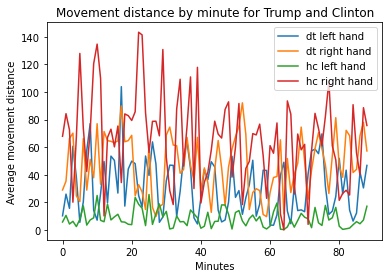

In [199]:
import matplotlib.pyplot as plt
import datetime
import numpy as np

#plt.plot(dt_table.interval,dt_table['head'], label = "head")
plt.plot(dt_table.interval,dt_table['left_hand'], label = "dt left hand")
plt.plot(dt_table.interval,dt_table['right_hand'], label = "dt right hand")
plt.plot(hc_table.interval,hc_table['left_hand'], label = "hc left hand")
plt.plot(hc_table.interval,hc_table['right_hand'], label = "hc right hand")
#plt.plot(p1_table.interval,p1_table['left_armjoint'], label = "left elbows")
#plt.plot(p1_table.interval,p1_table['right_armjoint'], label = "right elbows")
#plt.plot(dt_table.interval,dt_table['body'], label = "body")
plt.title("Movement distance by minute for Trump and Clinton")
plt.xlabel("Minutes")
plt.ylabel("Average movement distance")
plt.legend()
plt.show()

## RNN-LSTM

In [85]:
class LSTM(nn.Module):
    
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super(LSTM,self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.layer_num = layer_num
        self.lstm = nn.LSTM(input_dim,hidden_dim,layer_num,batch_first=True)
        self.fc = nn.Linear(hidden_dim,output_dim)
        self.bn = nn.BatchNorm1d(300)
        
    def forward(self,inputs):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_num, inputs.size(0), self.hidden_dim).requires_grad_()
        # Initialize cell state
        c0 = torch.zeros(self.layer_num, inputs.size(0), self.hidden_dim).requires_grad_()
        x = self.bn(inputs)
        lstm_out,(hn,cn) = self.lstm(x)
        #out = F.leaky_relu(hn)
        out = self.fc(lstm_out[:,-1,:])
        return out

n_hidden = 162
n_joints = 81*2
n_categories = 2
n_layer = 3
rnn = LSTM(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM(
  (lstm): LSTM(162, 162, num_layers=3, batch_first=True)
  (fc): Linear(in_features=162, out_features=2, bias=True)
  (bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [189]:
def test(model, test_dl):
  loss = 0
  correct = 0
  accuracy = 0

  target_true = 0
  predicted_true = 0
  correct_true = 0
    
  for (X, y) in test_dl:
    output = model(X)
    loss += nn.CrossEntropyLoss()(output, y)
    pred = output.data.max(1)[1]
    correct += pred.eq(y.data).sum()
    
    target_true += torch.sum(y)
    predicted_true += torch.sum(pred)
    correct_true += sum(y*pred == 1)
    
  loss /= len(test_dl.dataset)
  accuracy = 100 * correct/len(test_dl.dataset)
    
  recall = correct_true / target_true
  precision = correct_true / predicted_true
  f1_score = 2 * precision * recall / (precision + recall)

  return accuracy, loss, recall, precision, f1_score

def train(model, lr, num_epochs, train_dl, test_dl):
    #epochs=[]

  #opt = torch.optim.SGD(model.parameters(), lr = lr, momentum=momentum)
  opt = torch.optim.Adam(model.parameters(), lr = lr) 
    
  for epoch in range(1, num_epochs + 1):
    for X, y in train_dl:
      opt.zero_grad()
      prediction = model(X)
      loss = nn.CrossEntropyLoss()(prediction, y)  
      loss.backward() 
      opt.step()

    test_accuracy, loss, recall, precision, f1_score = test(model, test_dl)
    print(f"Test accuracy at epoch {epoch}: {test_accuracy:.4f}")
    

## Vanilla approach

In [87]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [88]:
device

device(type='cuda')

#### Clinton

In [100]:
features = []
positive_rate = []
validation_losses = []
test_losses = []
validation_accuracies = []
test_accuracies = []
test_recalls = []
test_precisions = []
test_F1s=[]

for feature in hc_label.columns:
    y = hc_label[feature]
    if sum(y)==0:
        print('no presence of this feature')
    else:
        features.append(feature)
        positive_rate.append(sum(hc_label[feature])/len(hc_label[feature]))
        print(feature)
        X = torch.tensor(hc, dtype=torch.float).to('cuda')
        y = torch.tensor(y, dtype=torch.long).to('cuda')
        
        full_dataset=[[X[i], y[i]] for i in range(len(y))]
        train_size = int(0.8 * len(full_dataset))
        test_size = len(full_dataset) - train_size
        full_train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

        train_size = int(0.8 * len(full_train_dataset))
        valid_size = len(full_train_dataset) - train_size
        train_dataset, valid_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, valid_size])

        batch_size=32
        train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_dl = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
        test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
      
        #Run the RNN-LSTM model
        model = LSTM(n_joints,n_hidden,n_categories,n_layer)
        model = model.cuda()

        lr = 0.001
        num_epochs = 5

        train(model, lr, num_epochs, train_dl, valid_dl)
        validation_accuracy, validation_loss, val_recall, val_precision, val_f1_score = test(model, valid_dl)
        test_accuracy, test_loss, test_recall, test_precision, test_f1_score = test(model, test_dl)
        
        validation_accuracies.append(round(validation_accuracy.item(), 4))
        validation_losses.append(round(validation_loss.item(), 4))
        test_accuracies.append(round(test_accuracy.item(),4))
        test_losses.append(round(test_loss.item(),4))
        test_recalls.append(round(test_recall.item(),4))
        test_precisions.append(round(test_precision.item(),4))
        test_F1s.append(round(test_f1_score.item(),4))
        print(f"Final validation accuracy on OpenPose: {validation_accuracy:.4f}")

performance = pd.DataFrame(
    {'features': features,
     'positive_rate':positive_rate,
     'val_accuracy': validation_accuracies,
     'val_loss': validation_losses,
     'test_accracy': test_accuracies,
     'test_loss': test_losses,
     'test_recall': test_recalls,
     'test_precision': test_precisions,
     'test_f1': test_F1s
    })

hc_lookat2
Test accuracy at epoch 1: 74.1176
Test accuracy at epoch 2: 70.5882
Test accuracy at epoch 3: 80.0000
Test accuracy at epoch 4: 78.8235
Test accuracy at epoch 5: 72.9412
Final validation accuracy on OpenPose: 72.9412
hc_brush1
Test accuracy at epoch 1: 90.5882
Test accuracy at epoch 2: 90.5882
Test accuracy at epoch 3: 90.5882
Test accuracy at epoch 4: 90.5882
Test accuracy at epoch 5: 90.5882
Final validation accuracy on OpenPose: 90.5882
hc_nvdis1
Test accuracy at epoch 1: 87.0588
Test accuracy at epoch 2: 87.0588
Test accuracy at epoch 3: 87.0588
Test accuracy at epoch 4: 87.0588
Test accuracy at epoch 5: 87.0588
Final validation accuracy on OpenPose: 87.0588
hc_lookat3
Test accuracy at epoch 1: 68.2353
Test accuracy at epoch 2: 91.7647
Test accuracy at epoch 3: 91.7647
Test accuracy at epoch 4: 91.7647
Test accuracy at epoch 5: 89.4118
Final validation accuracy on OpenPose: 89.4118
hc_eyebrow
Test accuracy at epoch 1: 67.0588
Test accuracy at epoch 2: 67.0588
Test accura

In [101]:
performance

features  positive_rate  val_accuracy  val_loss  test_accracy  \
0         hc_lookat2       0.511321       72.9412    0.0195       70.7547   
1          hc_brush1       0.126415       90.5882    0.0116       87.7358   
2          hc_nvdis1       0.096226       87.0588    0.0142       92.4528   
3         hc_lookat3       0.677358       89.4118    0.0149       83.9623   
4         hc_eyebrow       0.326415       67.0588    0.0186       69.8113   
5          hc_atface       0.130189       85.8824    0.0133       86.7925   
6          hc_hrface       0.505660       48.2353    0.0246       46.2264   
7          hc_saface       0.016981       98.8235    0.0022      100.0000   
8         hc_neuface       0.345283       60.0000    0.0241       69.8113   
9         hc_affgest       0.066038       92.9412    0.0083       95.2830   
10        hc_defgest       0.098113       91.7647    0.0099       90.5660   
11        hc_agentic       0.488679       58.8235    0.0215       54.7170   
12        hc_waveoff       0.369811       71.7647    0.0169       66.0377   
13         hc_nvtic1       0.149057       83.5294    0.0157       85.8491   
14         hc_nvtic2       0.149057       80.0000    0.0182       89.6226   
15         hc_nvtic3       0.003774       98.8235    0.0038       99.0566   
16         hc_nvtic6       0.013208       97.6471    0.0037      100.0000   
17  hc_interruptions       0.018868       95.2941    0.0066       99.0566   

    test_loss  test_recall  test_precision  test_f1  
0      0.0198       0.4038          1.0000   0.5753  
1      0.0125       0.0000             NaN      NaN  
2      0.0093       0.0000             NaN      NaN  
3      0.0185       0.9559          0.8228   0.8844  
4      0.0202       0.0882          0.7500   0.1579  
5      0.0143       0.0000             NaN      NaN  
6      0.0264       1.0000          0.4623   0.6323  
7      0.0009          NaN             NaN      NaN  
8      0.0232       0.0000             NaN      NaN  
9      0.0082       0.0000             NaN      NaN  
10     0.0119       0.0000             NaN      NaN  
11     0.0257       0.1429          1.0000   0.2500  
12     0.0210       0.6857          0.4898   0.5714  
13     0.0149       0.0000             NaN      NaN  
14     0.0127       0.0000             NaN      NaN  
15     0.0031       0.0000             NaN      NaN  
16     0.0004          NaN             NaN      NaN  
17     0.0018       0.0000             NaN      NaN

In [102]:
performance.to_excel('Output/hc_performance_vanilla.xlsx')

#### Trump

In [103]:
features = []
positive_rate = []
validation_losses = []
test_losses = []
validation_accuracies = []
test_accuracies = []
test_recalls = []
test_precisions = []
test_F1s=[]

for feature in dt_label.columns:
    y = dt_label[feature]
    if sum(y)==0:
        print('no presence of this feature')
    else:
        features.append(feature)
        positive_rate.append(sum(dt_label[feature])/len(dt_label[feature]))
        print(feature)
        #device = torch.device('cpu')
        X = torch.tensor(dt, dtype=torch.float).to('cuda')
        y = torch.tensor(y, dtype=torch.long).to('cuda')
        
        full_dataset=[[X[i], y[i]] for i in range(len(y))]
        train_size = int(0.8 * len(full_dataset))
        test_size = len(full_dataset) - train_size
        full_train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

        train_size = int(0.8 * len(full_train_dataset))
        valid_size = len(full_train_dataset) - train_size
        train_dataset, valid_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, valid_size])

        batch_size=32
        train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_dl = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
        test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
      
        #Run the RNN-LSTM model
        model = LSTM(n_joints,n_hidden,n_categories,n_layer)
        model = model.cuda()

        lr = 0.001
        num_epochs = 5

        train(model, lr, num_epochs, train_dl, valid_dl)
        validation_accuracy, validation_loss, val_recall, val_precision, val_f1_score = test(model, valid_dl)
        test_accuracy, test_loss, test_recall, test_precision, test_f1_score = test(model, test_dl)
        
        validation_accuracies.append(round(validation_accuracy.item(), 4))
        validation_losses.append(round(validation_loss.item(), 4))
        test_accuracies.append(round(test_accuracy.item(),4))
        test_losses.append(round(test_loss.item(),4))
        test_recalls.append(round(test_recall.item(),4))
        test_precisions.append(round(test_precision.item(),4))
        test_F1s.append(round(test_f1_score.item(),4))
        print(f"Final validation accuracy on OpenPose: {validation_accuracy:.4f}") 
        
performance = pd.DataFrame(
    {'features': features,
     'positive_rate':positive_rate,
     'val_accuracy': validation_accuracies,
     'val_loss': validation_losses,
     'test_accracy': test_accuracies,
     'test_loss': test_losses,
     'test_recall': test_recalls,
     'test_precision': test_precisions,
     'test_f1': test_F1s
    })

dt_lookat2
Test accuracy at epoch 1: 57.6471
Test accuracy at epoch 2: 69.4118
Test accuracy at epoch 3: 78.8235
Test accuracy at epoch 4: 80.0000
Test accuracy at epoch 5: 81.1765
Final validation accuracy on OpenPose: 81.1765
dt_brush1
Test accuracy at epoch 1: 90.5882
Test accuracy at epoch 2: 90.5882
Test accuracy at epoch 3: 90.5882
Test accuracy at epoch 4: 90.5882
Test accuracy at epoch 5: 90.5882
Final validation accuracy on OpenPose: 90.5882
dt_nvdis1
Test accuracy at epoch 1: 68.2353
Test accuracy at epoch 2: 68.2353
Test accuracy at epoch 3: 67.0588
Test accuracy at epoch 4: 68.2353
Test accuracy at epoch 5: 70.5882
Final validation accuracy on OpenPose: 70.5882
dt_lookat3
Test accuracy at epoch 1: 80.0000
Test accuracy at epoch 2: 80.0000
Test accuracy at epoch 3: 80.0000
Test accuracy at epoch 4: 80.0000
Test accuracy at epoch 5: 80.0000
Final validation accuracy on OpenPose: 80.0000
dt_eyebrow
Test accuracy at epoch 1: 92.9412
Test accuracy at epoch 2: 92.9412
Test accura

In [104]:
performance

features  positive_rate  val_accuracy  val_loss  test_accracy  \
0         dt_lookat2       0.639623       81.1765    0.0187       81.1321   
1          dt_brush1       0.083019       90.5882    0.0114       93.3962   
2          dt_nvdis1       0.705660       70.5882    0.0189       78.3019   
3         dt_lookat3       0.800000       80.0000    0.0177       82.0755   
4         dt_eyebrow       0.913208       92.9412    0.0084       87.7358   
5          dt_atface       0.584906       71.7647    0.0199       77.3585   
6          dt_hrface       0.088679       87.0588    0.0133       89.6226   
7         dt_neuface       0.292453       72.9412    0.0181       68.8679   
8        dt_inapprop       0.043396       96.4706    0.0051       95.2830   
9         dt_affgest       0.032075       97.6471    0.0038       99.0566   
10        dt_defgest       0.333962       75.2941    0.0204       76.4151   
11        dt_agentic       0.613208       76.4706    0.0178       68.8679   
12         dt_nvtic1       0.135849       91.7647    0.0112       81.1321   
13         dt_nvtic2       0.116981       91.7647    0.0095       89.6226   
14         dt_nvtic3       0.547170       70.5882    0.0198       64.1509   
15         dt_nvtic5       0.026415       97.6471    0.0043       99.0566   
16         dt_nvtic6       0.039623       98.8235    0.0030       97.1698   
17  dt_interruptions       0.077358       91.7647    0.0098       92.4528   

    test_loss  test_recall  test_precision  test_f1  
0      0.0216       0.9178          0.8272   0.8701  
1      0.0098       0.0000             NaN      NaN  
2      0.0178       1.0000          0.7830   0.8783  
3      0.0153       1.0000          0.8208   0.9016  
4      0.0171       1.0000          0.8774   0.9347  
5      0.0199       0.8070          0.7797   0.7931  
6      0.0111       0.0000             NaN      NaN  
7      0.0191       0.2424          0.5000   0.3265  
8      0.0063       0.0000             NaN      NaN  
9      0.0025       0.0000             NaN      NaN  
10     0.0221       0.2069          0.7500   0.3243  
11     0.0228       0.5873          0.8409   0.6916  
12     0.0199       0.0000             NaN      NaN  
13     0.0101       0.0000             NaN      NaN  
14     0.0214       0.8750          0.6125   0.7206  
15     0.0020       0.0000             NaN      NaN  
16     0.0046       0.0000             NaN      NaN  
17     0.0088       0.0000             NaN      NaN

In [105]:
performance.to_excel('Output/dt_performance_vanilla.xlsx')

### Data Augmentation - Oversampling

In [14]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

#### Clinton

In [107]:
features = []
validation_losses = []
test_losses = []
validation_accuracies = []
test_accuracies = []
test_recalls = []
test_precisions = []
test_F1s=[]
aug_train_data = []

for feature in hc_label.columns:
    y = hc_label[feature]
    if sum(y)==0:
        print('no presence of this feature')
    else:
        features.append(feature)
        print(feature)
        #device = torch.device('cpu')
        X = torch.tensor(hc, dtype=torch.float).to('cuda')
        y = torch.tensor(y, dtype=torch.long).to('cuda')
        
        full_dataset=[[X[i], y[i]] for i in range(len(y))]
        train_size = int(0.8 * len(full_dataset))
        test_size = len(full_dataset) - train_size
        full_train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

        X = list(zip(*full_train_dataset))[0]
        y = list(zip(*full_train_dataset))[1]

        #Oversampling 
        reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)
        oversample = RandomOverSampler(sampling_strategy='minority')
        X_over, y_over = oversample.fit_resample(reshape_x.cpu(), (torch.stack(y,dim=0)).squeeze(0).cpu())
        
        #Reshaping back for RNN input
        X_over = torch.tensor(X_over, dtype=torch.float).reshape(len(X_over), 300, 162)
        y_over = torch.tensor(y_over, dtype=torch.long)
        X = X_over
        y = y_over
        print(len(y_over))
        aug_train_data.append(len(y_over))
        
        #Sent to cuda for faster processing
        X = X.to(device)
        y = y.to(device)

        full_train_dataset=[[X[i], y[i]] for i in range(len(y))]

        train_size = int(0.8 * len(full_train_dataset))
        valid_size = len(full_train_dataset) - train_size
        train_dataset, valid_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, valid_size])

        batch_size=32
        train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_dl = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
        test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
      
        #Run the RNN-LSTM model
        model = LSTM(n_joints,n_hidden,n_categories,n_layer)
        model = model.cuda()

        lr = 0.001
        num_epochs = 5

        train(model, lr, num_epochs, train_dl, valid_dl)
        validation_accuracy, validation_loss, val_recall, val_precision, val_f1_score = test(model, valid_dl)
        test_accuracy, test_loss, test_recall, test_precision, test_f1_score = test(model, test_dl)
        
        validation_accuracies.append(round(validation_accuracy.item(), 4))
        validation_losses.append(round(validation_loss.item(), 4))
        test_accuracies.append(round(test_accuracy.item(),4))
        test_losses.append(round(test_loss.item(),4))
        test_recalls.append(round(test_recall.item(),4))
        test_precisions.append(round(test_precision.item(),4))
        test_F1s.append(round(test_f1_score.item(),4))
        print(f"Final validation accuracy on OpenPose: {validation_accuracy:.4f}")
        
performance = pd.DataFrame(
    {'features': features,
     'aug_train_data': aug_train_data,
     'val_accuracy': validation_accuracies,
     'val_loss': validation_losses,
     'test_accracy': test_accuracies,
     'test_loss': test_losses,
     'test_recall': test_recalls,
     'test_precision': test_precisions,
     'test_f1': test_F1s
    })

hc_lookat2
426


<ipython-input-107-ca582f9886c6>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 67.4419
Test accuracy at epoch 2: 67.4419
Test accuracy at epoch 3: 59.3023
Test accuracy at epoch 4: 73.2558
Test accuracy at epoch 5: 72.0930
Final validation accuracy on OpenPose: 72.0930
hc_brush1


<ipython-input-107-ca582f9886c6>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


740
Test accuracy at epoch 1: 56.0811
Test accuracy at epoch 2: 43.9189
Test accuracy at epoch 3: 50.6757
Test accuracy at epoch 4: 43.9189
Test accuracy at epoch 5: 66.2162
Final validation accuracy on OpenPose: 66.2162
hc_nvdis1


<ipython-input-107-ca582f9886c6>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


764
Test accuracy at epoch 1: 52.2876
Test accuracy at epoch 2: 47.7124
Test accuracy at epoch 3: 47.7124
Test accuracy at epoch 4: 47.7124
Test accuracy at epoch 5: 52.2876
Final validation accuracy on OpenPose: 52.2876
hc_lookat3
568


<ipython-input-107-ca582f9886c6>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 73.6842
Test accuracy at epoch 2: 78.9474
Test accuracy at epoch 3: 74.5614
Test accuracy at epoch 4: 78.9474
Test accuracy at epoch 5: 67.5439
Final validation accuracy on OpenPose: 67.5439
hc_eyebrow


<ipython-input-107-ca582f9886c6>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


568
Test accuracy at epoch 1: 64.0351
Test accuracy at epoch 2: 68.4211
Test accuracy at epoch 3: 69.2982
Test accuracy at epoch 4: 55.2632
Test accuracy at epoch 5: 71.9298
Final validation accuracy on OpenPose: 71.9298
hc_atface


<ipython-input-107-ca582f9886c6>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


738
Test accuracy at epoch 1: 66.8919
Test accuracy at epoch 2: 71.6216
Test accuracy at epoch 3: 72.9730
Test accuracy at epoch 4: 70.2703
Test accuracy at epoch 5: 58.7838
Final validation accuracy on OpenPose: 58.7838
no presence of this feature
hc_hrface


<ipython-input-107-ca582f9886c6>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


432
Test accuracy at epoch 1: 50.5747
Test accuracy at epoch 2: 50.5747
Test accuracy at epoch 3: 49.4253
Test accuracy at epoch 4: 49.4253
Test accuracy at epoch 5: 52.8736
Final validation accuracy on OpenPose: 52.8736
hc_saface


<ipython-input-107-ca582f9886c6>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


832
Test accuracy at epoch 1: 63.4731
Test accuracy at epoch 2: 78.4431
Test accuracy at epoch 3: 68.8623
Test accuracy at epoch 4: 75.4491
Test accuracy at epoch 5: 79.0419
Final validation accuracy on OpenPose: 79.0419
hc_neuface
568


<ipython-input-107-ca582f9886c6>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 53.5088
Test accuracy at epoch 2: 56.1404
Test accuracy at epoch 3: 46.4912
Test accuracy at epoch 4: 55.2632
Test accuracy at epoch 5: 56.1404
Final validation accuracy on OpenPose: 56.1404
no presence of this feature
hc_affgest


<ipython-input-107-ca582f9886c6>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


798
Test accuracy at epoch 1: 61.2500
Test accuracy at epoch 2: 60.0000
Test accuracy at epoch 3: 64.3750
Test accuracy at epoch 4: 65.0000
Test accuracy at epoch 5: 68.1250
Final validation accuracy on OpenPose: 68.1250
hc_defgest
758


<ipython-input-107-ca582f9886c6>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 75.0000
Test accuracy at epoch 2: 59.8684
Test accuracy at epoch 3: 51.9737
Test accuracy at epoch 4: 80.9211
Test accuracy at epoch 5: 71.0526
Final validation accuracy on OpenPose: 71.0526
hc_agentic


<ipython-input-107-ca582f9886c6>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


434
Test accuracy at epoch 1: 71.2644
Test accuracy at epoch 2: 57.4713
Test accuracy at epoch 3: 68.9655
Test accuracy at epoch 4: 65.5172
Test accuracy at epoch 5: 73.5632
Final validation accuracy on OpenPose: 73.5632
hc_waveoff
534


<ipython-input-107-ca582f9886c6>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 61.6822
Test accuracy at epoch 2: 56.0748
Test accuracy at epoch 3: 64.4860
Test accuracy at epoch 4: 69.1589
Test accuracy at epoch 5: 57.0093
Final validation accuracy on OpenPose: 57.0093
hc_nvtic1


<ipython-input-107-ca582f9886c6>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


714
Test accuracy at epoch 1: 58.0420
Test accuracy at epoch 2: 46.1538
Test accuracy at epoch 3: 55.9441
Test accuracy at epoch 4: 46.1538
Test accuracy at epoch 5: 46.1538
Final validation accuracy on OpenPose: 46.1538
hc_nvtic2


<ipython-input-107-ca582f9886c6>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


724
Test accuracy at epoch 1: 66.8966
Test accuracy at epoch 2: 46.8966
Test accuracy at epoch 3: 66.2069
Test accuracy at epoch 4: 65.5172
Test accuracy at epoch 5: 66.8966
Final validation accuracy on OpenPose: 66.8966
hc_nvtic3


<ipython-input-107-ca582f9886c6>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


844
Test accuracy at epoch 1: 91.7160
Test accuracy at epoch 2: 81.0651
Test accuracy at epoch 3: 92.8994
Test accuracy at epoch 4: 91.1243
Test accuracy at epoch 5: 91.1243
Final validation accuracy on OpenPose: 91.1243
no presence of this feature
hc_nvtic6
834


<ipython-input-107-ca582f9886c6>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 58.6826
Test accuracy at epoch 2: 69.4611
Test accuracy at epoch 3: 56.8862
Test accuracy at epoch 4: 43.1138
Test accuracy at epoch 5: 43.1138
Final validation accuracy on OpenPose: 43.1138
hc_interruptions
834


<ipython-input-107-ca582f9886c6>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 77.2455
Test accuracy at epoch 2: 65.2695
Test accuracy at epoch 3: 59.8802
Test accuracy at epoch 4: 54.4910
Test accuracy at epoch 5: 69.4611
Final validation accuracy on OpenPose: 69.4611


In [108]:
performance

features  aug_train_data  val_accuracy  val_loss  test_accracy  \
0         hc_lookat2             426       72.0930    0.0168       81.1321   
1          hc_brush1             740       66.2162    0.0222       68.8679   
2          hc_nvdis1             764       52.2876    0.0246       91.5094   
3         hc_lookat3             568       67.5439    0.0280       50.0000   
4         hc_eyebrow             568       71.9298    0.0183       64.1509   
5          hc_atface             738       58.7838    0.0219       85.8491   
6          hc_hrface             432       52.8736    0.0238       59.4340   
7          hc_saface             832       79.0419    0.0158       60.3774   
8         hc_neuface             568       56.1404    0.0242       57.5472   
9         hc_affgest             798       68.1250    0.0197       49.0566   
10        hc_defgest             758       71.0526    0.0189       33.0189   
11        hc_agentic             434       73.5632    0.0160       75.4717   
12        hc_waveoff             534       57.0093    0.0228       63.2075   
13         hc_nvtic1             714       46.1538    0.0242       11.3208   
14         hc_nvtic2             724       66.8966    0.0209       75.4717   
15         hc_nvtic3             844       91.1243    0.0070       77.3585   
16         hc_nvtic6             834       43.1138    0.0250        0.0000   
17  hc_interruptions             834       69.4611    0.0195       49.0566   

    test_loss  test_recall  test_precision  test_f1  
0      0.0155       0.8333          0.8333   0.8333  
1      0.0237       0.6154          0.2222   0.3265  
2      0.0170       0.0000             NaN      NaN  
3      0.0486       0.3200          0.9231   0.4752  
4      0.0199       0.8788          0.4603   0.6042  
5      0.0162       0.4286          0.4615   0.4444  
6      0.0259       0.8269          0.5584   0.6667  
7      0.0179       1.0000          0.0233   0.0455  
8      0.0258       0.4651          0.4762   0.4706  
9      0.0268       1.0000          0.1562   0.2703  
10     0.0261       1.0000          0.0897   0.1647  
11     0.0192       0.9231          0.6857   0.7869  
12     0.0201       1.0000          0.5000   0.6667  
13     0.0269       1.0000          0.1132   0.2034  
14     0.0211       0.2353          0.2353   0.2353  
15     0.0178          NaN          0.0000      NaN  
16     0.0269          NaN          0.0000      NaN  
17     0.0228       0.6667          0.0364   0.0690

In [109]:
performance.to_excel('Output/hc_performance_datAug.xlsx')

#### Trump 

In [110]:
features = []
validation_losses = []
test_losses = []
validation_accuracies = []
test_accuracies = []
test_recalls = []
test_precisions = []
test_F1s=[]
aug_train_data = []

for feature in dt_label.columns:
    y = dt_label[feature]
    if sum(y)==0:
        print('no presence of this feature')
    else:
        features.append(feature)
        print(feature)
        #device = torch.device('cpu')
        X = torch.tensor(dt, dtype=torch.float).to('cuda')
        y = torch.tensor(y, dtype=torch.long).to('cuda')
        
        full_dataset=[[X[i], y[i]] for i in range(len(y))]
        train_size = int(0.8 * len(full_dataset))
        test_size = len(full_dataset) - train_size
        full_train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

        X = list(zip(*full_train_dataset))[0]
        y = list(zip(*full_train_dataset))[1]

        #Oversampling 
        reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)
        oversample = RandomOverSampler(sampling_strategy='minority')
        X_over, y_over = oversample.fit_resample(reshape_x.cpu(), (torch.stack(y,dim=0)).squeeze(0).cpu())
        
        #Reshaping back for RNN input
        X_over = torch.tensor(X_over, dtype=torch.float).reshape(len(X_over), 300, 162)
        y_over = torch.tensor(y_over, dtype=torch.long)
        X = X_over
        y = y_over
        print(len(y_over))
        aug_train_data.append(len(y_over))
        
        #Sent to cuda for faster processing
        X = X.to(device)
        y = y.to(device)

        full_train_dataset=[[X[i], y[i]] for i in range(len(y))]

        train_size = int(0.8 * len(full_train_dataset))
        valid_size = len(full_train_dataset) - train_size
        train_dataset, valid_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, valid_size])

        batch_size=32
        train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_dl = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
        test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
      
        #Run the RNN-LSTM model
        model = LSTM(n_joints,n_hidden,n_categories,n_layer)
        model = model.cuda()

        lr = 0.001
        num_epochs = 5

        train(model, lr, num_epochs, train_dl, valid_dl)
        validation_accuracy, validation_loss, val_recall, val_precision, val_f1_score = test(model, valid_dl)
        test_accuracy, test_loss, test_recall, test_precision, test_f1_score = test(model, test_dl)
        
        validation_accuracies.append(round(validation_accuracy.item(), 4))
        validation_losses.append(round(validation_loss.item(), 4))
        test_accuracies.append(round(test_accuracy.item(),4))
        test_losses.append(round(test_loss.item(),4))
        test_recalls.append(round(test_recall.item(),4))
        test_precisions.append(round(test_precision.item(),4))
        test_F1s.append(round(test_f1_score.item(),4))
        print(f"Final validation accuracy on OpenPose: {validation_accuracy:.4f}")
        
performance = pd.DataFrame(
    {'features': features,
     'aug_train_data': aug_train_data,
     'val_accuracy': validation_accuracies,
     'val_loss': validation_losses,
     'test_accracy': test_accuracies,
     'test_loss': test_losses,
     'test_recall': test_recalls,
     'test_precision': test_precisions,
     'test_f1': test_F1s
    })

dt_lookat2
534


<ipython-input-110-d9fc104f5939>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 73.8318
Test accuracy at epoch 2: 71.0280
Test accuracy at epoch 3: 64.4860
Test accuracy at epoch 4: 55.1402
Test accuracy at epoch 5: 80.3738
Final validation accuracy on OpenPose: 80.3738
dt_brush1


<ipython-input-110-d9fc104f5939>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


772
Test accuracy at epoch 1: 63.2258
Test accuracy at epoch 2: 70.9677
Test accuracy at epoch 3: 70.3226
Test accuracy at epoch 4: 67.0968
Test accuracy at epoch 5: 71.6129
Final validation accuracy on OpenPose: 71.6129
dt_nvdis1


<ipython-input-110-d9fc104f5939>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


598
Test accuracy at epoch 1: 57.5000
Test accuracy at epoch 2: 64.1667
Test accuracy at epoch 3: 73.3333
Test accuracy at epoch 4: 67.5000
Test accuracy at epoch 5: 79.1667
Final validation accuracy on OpenPose: 79.1667
dt_lookat3


<ipython-input-110-d9fc104f5939>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


682
Test accuracy at epoch 1: 58.3942
Test accuracy at epoch 2: 64.2336
Test accuracy at epoch 3: 64.2336
Test accuracy at epoch 4: 67.8832
Test accuracy at epoch 5: 58.3942
Final validation accuracy on OpenPose: 58.3942
dt_eyebrow


<ipython-input-110-d9fc104f5939>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


772
Test accuracy at epoch 1: 65.1613
Test accuracy at epoch 2: 64.5161
Test accuracy at epoch 3: 69.6774
Test accuracy at epoch 4: 78.7097
Test accuracy at epoch 5: 76.7742
Final validation accuracy on OpenPose: 76.7742
dt_atface


<ipython-input-110-d9fc104f5939>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


484
Test accuracy at epoch 1: 69.0722
Test accuracy at epoch 2: 75.2577
Test accuracy at epoch 3: 72.1649
Test accuracy at epoch 4: 64.9484
Test accuracy at epoch 5: 71.1340
Final validation accuracy on OpenPose: 71.1340
no presence of this feature
dt_hrface


<ipython-input-110-d9fc104f5939>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


768
Test accuracy at epoch 1: 66.8831
Test accuracy at epoch 2: 60.3896
Test accuracy at epoch 3: 66.8831
Test accuracy at epoch 4: 68.1818
Test accuracy at epoch 5: 75.3247
Final validation accuracy on OpenPose: 75.3247
no presence of this feature
dt_neuface


<ipython-input-110-d9fc104f5939>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


598
Test accuracy at epoch 1: 61.6667
Test accuracy at epoch 2: 64.1667
Test accuracy at epoch 3: 62.5000
Test accuracy at epoch 4: 70.0000
Test accuracy at epoch 5: 76.6667
Final validation accuracy on OpenPose: 76.6667
dt_inapprop


<ipython-input-110-d9fc104f5939>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


812
Test accuracy at epoch 1: 59.5092
Test accuracy at epoch 2: 64.4172
Test accuracy at epoch 3: 70.5521
Test accuracy at epoch 4: 80.9816
Test accuracy at epoch 5: 74.8466
Final validation accuracy on OpenPose: 74.8466
dt_affgest
824


<ipython-input-110-d9fc104f5939>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 66.0606
Test accuracy at epoch 2: 75.7576
Test accuracy at epoch 3: 73.3333
Test accuracy at epoch 4: 71.5152
Test accuracy at epoch 5: 81.2121
Final validation accuracy on OpenPose: 81.2121
dt_defgest
564


<ipython-input-110-d9fc104f5939>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 62.8319
Test accuracy at epoch 2: 67.2566
Test accuracy at epoch 3: 76.9911
Test accuracy at epoch 4: 71.6814
Test accuracy at epoch 5: 76.1062
Final validation accuracy on OpenPose: 76.1062
dt_agentic


<ipython-input-110-d9fc104f5939>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


512
Test accuracy at epoch 1: 67.9612
Test accuracy at epoch 2: 73.7864
Test accuracy at epoch 3: 78.6408
Test accuracy at epoch 4: 78.6408
Test accuracy at epoch 5: 82.5243
Final validation accuracy on OpenPose: 82.5243
no presence of this feature
dt_nvtic1


<ipython-input-110-d9fc104f5939>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


736
Test accuracy at epoch 1: 61.4865
Test accuracy at epoch 2: 56.0811
Test accuracy at epoch 3: 62.1622
Test accuracy at epoch 4: 61.4865
Test accuracy at epoch 5: 72.2973
Final validation accuracy on OpenPose: 72.2973
dt_nvtic2


<ipython-input-110-d9fc104f5939>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


758
Test accuracy at epoch 1: 57.2368
Test accuracy at epoch 2: 59.2105
Test accuracy at epoch 3: 66.4474
Test accuracy at epoch 4: 71.7105
Test accuracy at epoch 5: 73.6842
Final validation accuracy on OpenPose: 73.6842
dt_nvtic3


<ipython-input-110-d9fc104f5939>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


470
Test accuracy at epoch 1: 61.7021
Test accuracy at epoch 2: 56.3830
Test accuracy at epoch 3: 74.4681
Test accuracy at epoch 4: 65.9574
Test accuracy at epoch 5: 73.4043
Final validation accuracy on OpenPose: 73.4043
dt_nvtic5


<ipython-input-110-d9fc104f5939>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


822
Test accuracy at epoch 1: 74.5455
Test accuracy at epoch 2: 73.9394
Test accuracy at epoch 3: 75.7576
Test accuracy at epoch 4: 84.8485
Test accuracy at epoch 5: 81.2121
Final validation accuracy on OpenPose: 81.2121
dt_nvtic6
812


<ipython-input-110-d9fc104f5939>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 57.0552
Test accuracy at epoch 2: 72.3926
Test accuracy at epoch 3: 70.5521
Test accuracy at epoch 4: 68.0982
Test accuracy at epoch 5: 83.4356
Final validation accuracy on OpenPose: 83.4356
dt_interruptions
782


<ipython-input-110-d9fc104f5939>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 54.1401
Test accuracy at epoch 2: 66.8790
Test accuracy at epoch 3: 63.0573
Test accuracy at epoch 4: 68.7898
Test accuracy at epoch 5: 66.2420
Final validation accuracy on OpenPose: 66.2420


In [111]:
performance

features  aug_train_data  val_accuracy  val_loss  test_accracy  \
0         dt_lookat2             534       80.3738    0.0184       83.9623   
1          dt_brush1             772       71.6129    0.0174       31.1321   
2          dt_nvdis1             598       79.1667    0.0180       62.2642   
3         dt_lookat3             682       58.3942    0.0285       52.8302   
4         dt_eyebrow             772       76.7742    0.0147       52.8302   
5          dt_atface             484       71.1340    0.0271       67.9245   
6          dt_hrface             768       75.3247    0.0179       53.7736   
7         dt_neuface             598       76.6667    0.0168       71.6981   
8        dt_inapprop             812       74.8466    0.0163       77.3585   
9         dt_affgest             824       81.2121    0.0125       66.0377   
10        dt_defgest             564       76.1062    0.0205       67.9245   
11        dt_agentic             512       82.5243    0.0172       76.4151   
12         dt_nvtic1             736       72.2973    0.0197       79.2453   
13         dt_nvtic2             758       73.6842    0.0182       82.0755   
14         dt_nvtic3             470       73.4043    0.0179       72.6415   
15         dt_nvtic5             822       81.2121    0.0131       74.5283   
16         dt_nvtic6             812       83.4356    0.0128       80.1887   
17  dt_interruptions             782       66.2420    0.0174       58.4906   

    test_loss  test_recall  test_precision  test_f1  
0      0.0177       0.9306          0.8481   0.8874  
1      0.0300       0.6667          0.0533   0.0988  
2      0.0241       0.4800          0.9730   0.6429  
3      0.0334       0.4217          0.9459   0.5833  
4      0.0213       0.5102          0.9615   0.6667  
5      0.0251       0.5294          0.9474   0.6792  
6      0.0233       0.5714          0.0800   0.1404  
7      0.0178       0.7000          0.5000   0.5833  
8      0.0183       0.4000          0.0870   0.1429  
9      0.0185       0.4000          0.0571   0.1000  
10     0.0221       0.8286          0.5088   0.6304  
11     0.0226       0.7246          0.8929   0.8000  
12     0.0165       0.6875          0.3929   0.5000  
13     0.0134       0.7059          0.4615   0.5581  
14     0.0200       0.6909          0.7600   0.7238  
15     0.0177       1.0000          0.0357   0.0690  
16     0.0175       0.3333          0.0500   0.0870  
17     0.0335       0.2500          0.0500   0.0833

In [112]:
performance.to_excel('Output/dt_performance_datAug.xlsx')

## Early Stopping 

#### Redefine the train function for early stopping

In [194]:
def train(model, lr, num_epochs, train_dl, test_dl):
  model_dir = 'model/'

  #opt = torch.optim.SGD(model.parameters(), lr = lr, momentum=momentum)
  opt = torch.optim.Adam(model.parameters(), lr = lr) 
  best_accuracy = 0
  best_loss = 100
  es_epoch = 1
    
  for epoch in range(1, num_epochs + 1):
    for X, y in train_dl:
      opt.zero_grad()
      prediction = model(X)
      #print(prediction)
      loss = nn.CrossEntropyLoss()(prediction, y)  
      loss.backward() 
      opt.step()

    test_accuracy, loss, recall, precision, f1_score = test(model, test_dl)
    print(f"Test accuracy at epoch {epoch}: {test_accuracy:.4f}")
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        es_epoch = epoch
#     if loss < best_loss:
#         best_loss = loss
#         es_epoch = epoch
    torch.save(model.state_dict(), os.path.join(model_dir, 'epoch-{}.pt'.format(epoch)))
  return es_epoch
    

#### Clinton 

In [195]:
features = []
validation_losses = []
test_losses = []
validation_accuracies = []
test_accuracies = []
test_recalls = []
test_precisions = []
test_F1s=[]
aug_train_data = []
epochs =[]

for feature in hc_label.columns:
    y = hc_label[feature]
    if sum(y)==0:
        print('no presence of this feature')
    else:
        features.append(feature)
        print(feature)
        #device = torch.device('cpu')
        X = torch.tensor(hc, dtype=torch.float).to('cuda')
        y = torch.tensor(y, dtype=torch.long).to('cuda')
        
        full_dataset=[[X[i], y[i]] for i in range(len(y))]
        train_size = int(0.8 * len(full_dataset))
        test_size = len(full_dataset) - train_size
        full_train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

        X = list(zip(*full_train_dataset))[0]
        y = list(zip(*full_train_dataset))[1]

        #Oversampling 
        reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)
        oversample = RandomOverSampler(sampling_strategy='minority')
        X_over, y_over = oversample.fit_resample(reshape_x.cpu(), (torch.stack(y,dim=0)).squeeze(0).cpu())
        
        #Reshaping back for RNN input
        X_over = torch.tensor(X_over, dtype=torch.float).reshape(len(X_over), 300, 162)
        y_over = torch.tensor(y_over, dtype=torch.long)
        X = X_over
        y = y_over
        print(len(y_over))
        aug_train_data.append(len(y_over))
        
        #Sent to cuda for faster processing
        X = X.to(device)
        y = y.to(device)

        full_train_dataset=[[X[i], y[i]] for i in range(len(y))]

        train_size = int(0.8 * len(full_train_dataset))
        valid_size = len(full_train_dataset) - train_size
        train_dataset, valid_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, valid_size])

        batch_size=32
        train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_dl = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
        test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
      
        #Run the RNN-LSTM model
        model = LSTM(n_joints,n_hidden,n_categories,n_layer)
        model = model.cuda()

        lr = 0.001
        num_epochs = 25
        
        #Save the model for each epoch and get the number of early stopping epochs
        es_epoch = train(model, lr, num_epochs, train_dl, valid_dl) 
        print('early stop: epochs = ' + str(es_epoch))
        epochs.append(es_epoch)
        
        #load the model for early stoppping epochs
        model_dir = 'model/'
        model = LSTM(n_joints,n_hidden,n_categories,n_layer)
        model = model.cuda()
        model.load_state_dict(torch.load(os.path.join(model_dir, 'epoch-{}.pt'.format(es_epoch))))
        
        validation_accuracy, validation_loss, val_recall, val_precision, val_f1_score = test(model, valid_dl)
        test_accuracy, test_loss, test_recall, test_precision, test_f1_score = test(model, test_dl)
        
        validation_accuracies.append(round(validation_accuracy.item(), 4))
        validation_losses.append(round(validation_loss.item(), 4))
        test_accuracies.append(round(test_accuracy.item(),4))
        test_losses.append(round(test_loss.item(),4))
        test_recalls.append(round(test_recall.item(),4))
        test_precisions.append(round(test_precision.item(),4))
        test_F1s.append(round(test_f1_score.item(),4))
        print(f"Final validation accuracy on OpenPose: {validation_accuracy:.4f}")
        print(f"Final test accuracy on OpenPose: {test_accuracy:.4f}")
        
performance = pd.DataFrame(
    {'features': features,
     'aug_train_data': aug_train_data,
     'early stop epochs': epochs,
     'val_accuracy': validation_accuracies,
     'val_loss': validation_losses,
     'test_accracy': test_accuracies,
     'test_loss': test_losses,
     'test_recall': test_recalls,
     'test_precision': test_precisions,
     'test_f1': test_F1s
    })

hc_lookat2
424


<ipython-input-195-490280bbf7b0>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 82.3529
Test accuracy at epoch 2: 72.9412
Test accuracy at epoch 3: 78.8235
Test accuracy at epoch 4: 84.7059
Test accuracy at epoch 5: 72.9412
Test accuracy at epoch 6: 71.7647
Test accuracy at epoch 7: 70.5882
Test accuracy at epoch 8: 76.4706
Test accuracy at epoch 9: 71.7647
Test accuracy at epoch 10: 85.8824
Test accuracy at epoch 11: 82.3529
Test accuracy at epoch 12: 71.7647
Test accuracy at epoch 13: 72.9412
Test accuracy at epoch 14: 50.5882
Test accuracy at epoch 15: 49.4118
Test accuracy at epoch 16: 76.4706
Test accuracy at epoch 17: 71.7647
Test accuracy at epoch 18: 50.5882
Test accuracy at epoch 19: 50.5882
Test accuracy at epoch 20: 50.5882
Test accuracy at epoch 21: 76.4706
Test accuracy at epoch 22: 84.7059
Test accuracy at epoch 23: 76.4706
Test accuracy at epoch 24: 81.1765
Test accuracy at epoch 25: 50.5882
early stop: epochs = 10
Final validation accuracy on OpenPose: 85.8824
Final test accuracy on OpenPose: 84.9057
hc_brush1


<ipython-input-195-490280bbf7b0>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


738
Test accuracy at epoch 1: 49.3243
Test accuracy at epoch 2: 60.8108
Test accuracy at epoch 3: 52.7027
Test accuracy at epoch 4: 68.9189
Test accuracy at epoch 5: 49.3243
Test accuracy at epoch 6: 74.3243
Test accuracy at epoch 7: 62.8378
Test accuracy at epoch 8: 67.5676
Test accuracy at epoch 9: 64.8649
Test accuracy at epoch 10: 66.2162
Test accuracy at epoch 11: 66.8919
Test accuracy at epoch 12: 64.8649
Test accuracy at epoch 13: 69.5946
Test accuracy at epoch 14: 62.1622
Test accuracy at epoch 15: 56.0811
Test accuracy at epoch 16: 56.0811
Test accuracy at epoch 17: 67.5676
Test accuracy at epoch 18: 75.0000
Test accuracy at epoch 19: 50.6757
Test accuracy at epoch 20: 55.4054
Test accuracy at epoch 21: 68.2432
Test accuracy at epoch 22: 50.6757
Test accuracy at epoch 23: 69.5946
Test accuracy at epoch 24: 70.2703
Test accuracy at epoch 25: 57.4324
early stop: epochs = 18
Final validation accuracy on OpenPose: 75.0000
Final test accuracy on OpenPose: 67.9245
hc_nvdis1
768


<ipython-input-195-490280bbf7b0>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 50.6493
Test accuracy at epoch 2: 49.3507
Test accuracy at epoch 3: 51.2987
Test accuracy at epoch 4: 58.4416
Test accuracy at epoch 5: 53.8961
Test accuracy at epoch 6: 50.6493
Test accuracy at epoch 7: 60.3896
Test accuracy at epoch 8: 50.0000
Test accuracy at epoch 9: 50.6493
Test accuracy at epoch 10: 50.6493
Test accuracy at epoch 11: 49.3507
Test accuracy at epoch 12: 49.3507
Test accuracy at epoch 13: 50.6493
Test accuracy at epoch 14: 50.6493
Test accuracy at epoch 15: 50.6493
Test accuracy at epoch 16: 60.3896
Test accuracy at epoch 17: 51.9481
Test accuracy at epoch 18: 57.1429
Test accuracy at epoch 19: 59.7403
Test accuracy at epoch 20: 54.5455
Test accuracy at epoch 21: 59.0909
Test accuracy at epoch 22: 57.7922
Test accuracy at epoch 23: 49.3507
Test accuracy at epoch 24: 49.3507
Test accuracy at epoch 25: 49.3507
early stop: epochs = 7
Final validation accuracy on OpenPose: 60.3896
Final test accuracy on OpenPose: 39.6226
hc_lookat3
570


<ipython-input-195-490280bbf7b0>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 70.1754
Test accuracy at epoch 2: 74.5614
Test accuracy at epoch 3: 80.7018
Test accuracy at epoch 4: 79.8246
Test accuracy at epoch 5: 74.5614
Test accuracy at epoch 6: 73.6842
Test accuracy at epoch 7: 79.8246
Test accuracy at epoch 8: 75.4386
Test accuracy at epoch 9: 86.8421
Test accuracy at epoch 10: 69.2982
Test accuracy at epoch 11: 75.4386
Test accuracy at epoch 12: 81.5789
Test accuracy at epoch 13: 73.6842
Test accuracy at epoch 14: 73.6842
Test accuracy at epoch 15: 74.5614
Test accuracy at epoch 16: 80.7018
Test accuracy at epoch 17: 73.6842
Test accuracy at epoch 18: 74.5614
Test accuracy at epoch 19: 73.6842
Test accuracy at epoch 20: 78.0702
Test accuracy at epoch 21: 73.6842
Test accuracy at epoch 22: 78.9474
Test accuracy at epoch 23: 81.5789
Test accuracy at epoch 24: 85.0877
Test accuracy at epoch 25: 64.0351
early stop: epochs = 9
Final validation accuracy on OpenPose: 86.8421
Final test accuracy on OpenPose: 81.1321
hc_eyebrow
580


<ipython-input-195-490280bbf7b0>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 67.2414
Test accuracy at epoch 2: 63.7931
Test accuracy at epoch 3: 62.0690
Test accuracy at epoch 4: 48.2759
Test accuracy at epoch 5: 57.7586
Test accuracy at epoch 6: 61.2069
Test accuracy at epoch 7: 61.2069
Test accuracy at epoch 8: 63.7931
Test accuracy at epoch 9: 48.2759
Test accuracy at epoch 10: 51.7241
Test accuracy at epoch 11: 64.6552
Test accuracy at epoch 12: 50.0000
Test accuracy at epoch 13: 66.3793
Test accuracy at epoch 14: 68.1034
Test accuracy at epoch 15: 51.7241
Test accuracy at epoch 16: 48.2759
Test accuracy at epoch 17: 48.2759
Test accuracy at epoch 18: 51.7241
Test accuracy at epoch 19: 48.2759
Test accuracy at epoch 20: 61.2069
Test accuracy at epoch 21: 59.4828
Test accuracy at epoch 22: 61.2069
Test accuracy at epoch 23: 52.5862
Test accuracy at epoch 24: 48.2759
Test accuracy at epoch 25: 63.7931
early stop: epochs = 14
Final validation accuracy on OpenPose: 68.1034
Final test accuracy on OpenPose: 63.2075
hc_atface
746


<ipython-input-195-490280bbf7b0>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 60.6667
Test accuracy at epoch 2: 52.0000
Test accuracy at epoch 3: 63.3333
Test accuracy at epoch 4: 66.6667
Test accuracy at epoch 5: 62.0000
Test accuracy at epoch 6: 72.6667
Test accuracy at epoch 7: 66.6667
Test accuracy at epoch 8: 75.3333
Test accuracy at epoch 9: 65.3333
Test accuracy at epoch 10: 68.6667
Test accuracy at epoch 11: 70.6667
Test accuracy at epoch 12: 73.3333
Test accuracy at epoch 13: 64.0000
Test accuracy at epoch 14: 64.0000
Test accuracy at epoch 15: 64.0000
Test accuracy at epoch 16: 73.3333
Test accuracy at epoch 17: 58.0000
Test accuracy at epoch 18: 66.6667
Test accuracy at epoch 19: 66.0000
Test accuracy at epoch 20: 51.3333
Test accuracy at epoch 21: 50.6667
Test accuracy at epoch 22: 68.0000
Test accuracy at epoch 23: 68.0000
Test accuracy at epoch 24: 66.6667
Test accuracy at epoch 25: 67.3333
early stop: epochs = 8
Final validation accuracy on OpenPose: 75.3333
Final test accuracy on OpenPose: 62.2642
no presence of this fea

<ipython-input-195-490280bbf7b0>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 51.6854
Test accuracy at epoch 2: 51.6854
Test accuracy at epoch 3: 48.3146
Test accuracy at epoch 4: 50.5618
Test accuracy at epoch 5: 48.3146
Test accuracy at epoch 6: 51.6854
Test accuracy at epoch 7: 57.3034
Test accuracy at epoch 8: 53.9326
Test accuracy at epoch 9: 55.0562
Test accuracy at epoch 10: 52.8090
Test accuracy at epoch 11: 55.0562
Test accuracy at epoch 12: 58.4270
Test accuracy at epoch 13: 62.9213
Test accuracy at epoch 14: 55.0562
Test accuracy at epoch 15: 51.6854
Test accuracy at epoch 16: 48.3146
Test accuracy at epoch 17: 51.6854
Test accuracy at epoch 18: 52.8090
Test accuracy at epoch 19: 52.8090
Test accuracy at epoch 20: 57.3034
Test accuracy at epoch 21: 47.1910
Test accuracy at epoch 22: 52.8090
Test accuracy at epoch 23: 52.8090
Test accuracy at epoch 24: 52.8090
Test accuracy at epoch 25: 52.8090
early stop: epochs = 13
Final validation accuracy on OpenPose: 62.9213
Final test accuracy on OpenPose: 55.6604
hc_saface


<ipython-input-195-490280bbf7b0>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


830
Test accuracy at epoch 1: 72.2892
Test accuracy at epoch 2: 72.2892
Test accuracy at epoch 3: 67.4699
Test accuracy at epoch 4: 79.5181
Test accuracy at epoch 5: 50.6024
Test accuracy at epoch 6: 73.4940
Test accuracy at epoch 7: 75.9036
Test accuracy at epoch 8: 74.6988
Test accuracy at epoch 9: 76.5060
Test accuracy at epoch 10: 78.9157
Test accuracy at epoch 11: 78.9157
Test accuracy at epoch 12: 80.7229
Test accuracy at epoch 13: 80.1205
Test accuracy at epoch 14: 83.7349
Test accuracy at epoch 15: 80.1205
Test accuracy at epoch 16: 79.5181
Test accuracy at epoch 17: 78.9157
Test accuracy at epoch 18: 84.9398
Test accuracy at epoch 19: 81.3253
Test accuracy at epoch 20: 84.9398
Test accuracy at epoch 21: 81.3253
Test accuracy at epoch 22: 81.3253
Test accuracy at epoch 23: 85.5422
Test accuracy at epoch 24: 88.5542
Test accuracy at epoch 25: 88.5542
early stop: epochs = 24
Final validation accuracy on OpenPose: 88.5542
Final test accuracy on OpenPose: 86.7925
hc_neuface
544


<ipython-input-195-490280bbf7b0>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 43.1193
Test accuracy at epoch 2: 43.1193
Test accuracy at epoch 3: 43.1193
Test accuracy at epoch 4: 57.7982
Test accuracy at epoch 5: 55.0459
Test accuracy at epoch 6: 43.1193
Test accuracy at epoch 7: 43.1193
Test accuracy at epoch 8: 43.1193
Test accuracy at epoch 9: 43.1193
Test accuracy at epoch 10: 43.1193
Test accuracy at epoch 11: 59.6330
Test accuracy at epoch 12: 43.1193
Test accuracy at epoch 13: 56.8807
Test accuracy at epoch 14: 43.1193
Test accuracy at epoch 15: 43.1193
Test accuracy at epoch 16: 44.0367
Test accuracy at epoch 17: 56.8807
Test accuracy at epoch 18: 43.1193
Test accuracy at epoch 19: 59.6330
Test accuracy at epoch 20: 44.0367
Test accuracy at epoch 21: 59.6330
Test accuracy at epoch 22: 57.7982
Test accuracy at epoch 23: 43.1193
Test accuracy at epoch 24: 43.1193
Test accuracy at epoch 25: 46.7890
early stop: epochs = 11
Final validation accuracy on OpenPose: 59.6330
Final test accuracy on OpenPose: 43.3962
no presence of this fe

<ipython-input-195-490280bbf7b0>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 51.8750
Test accuracy at epoch 2: 70.6250
Test accuracy at epoch 3: 75.0000
Test accuracy at epoch 4: 70.6250
Test accuracy at epoch 5: 71.2500
Test accuracy at epoch 6: 74.3750
Test accuracy at epoch 7: 75.0000
Test accuracy at epoch 8: 71.2500
Test accuracy at epoch 9: 65.0000
Test accuracy at epoch 10: 75.0000
Test accuracy at epoch 11: 74.3750
Test accuracy at epoch 12: 76.2500
Test accuracy at epoch 13: 70.0000
Test accuracy at epoch 14: 78.1250
Test accuracy at epoch 15: 76.2500
Test accuracy at epoch 16: 72.5000
Test accuracy at epoch 17: 67.5000
Test accuracy at epoch 18: 73.7500
Test accuracy at epoch 19: 78.1250
Test accuracy at epoch 20: 76.8750
Test accuracy at epoch 21: 66.8750
Test accuracy at epoch 22: 81.8750
Test accuracy at epoch 23: 77.5000
Test accuracy at epoch 24: 77.5000
Test accuracy at epoch 25: 81.2500
early stop: epochs = 22
Final validation accuracy on OpenPose: 81.8750
Final test accuracy on OpenPose: 82.0755
hc_defgest
758


<ipython-input-195-490280bbf7b0>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 69.0789
Test accuracy at epoch 2: 61.1842
Test accuracy at epoch 3: 70.3947
Test accuracy at epoch 4: 46.7105
Test accuracy at epoch 5: 67.7632
Test accuracy at epoch 6: 71.7105
Test accuracy at epoch 7: 53.2895
Test accuracy at epoch 8: 69.0789
Test accuracy at epoch 9: 53.2895
Test accuracy at epoch 10: 65.7895
Test accuracy at epoch 11: 71.0526
Test accuracy at epoch 12: 71.7105
Test accuracy at epoch 13: 73.0263
Test accuracy at epoch 14: 76.3158
Test accuracy at epoch 15: 71.0526
Test accuracy at epoch 16: 73.0263
Test accuracy at epoch 17: 73.0263
Test accuracy at epoch 18: 73.6842
Test accuracy at epoch 19: 47.3684
Test accuracy at epoch 20: 53.2895
Test accuracy at epoch 21: 70.3947
Test accuracy at epoch 22: 69.7368
Test accuracy at epoch 23: 53.9474
Test accuracy at epoch 24: 67.7632
Test accuracy at epoch 25: 70.3947
early stop: epochs = 14
Final validation accuracy on OpenPose: 76.3158
Final test accuracy on OpenPose: 55.6604
hc_agentic
432


<ipython-input-195-490280bbf7b0>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 66.6667
Test accuracy at epoch 2: 70.1149
Test accuracy at epoch 3: 75.8621
Test accuracy at epoch 4: 71.2644
Test accuracy at epoch 5: 71.2644
Test accuracy at epoch 6: 73.5632
Test accuracy at epoch 7: 68.9655
Test accuracy at epoch 8: 62.0690
Test accuracy at epoch 9: 72.4138
Test accuracy at epoch 10: 72.4138
Test accuracy at epoch 11: 71.2644
Test accuracy at epoch 12: 70.1149
Test accuracy at epoch 13: 72.4138
Test accuracy at epoch 14: 64.3678
Test accuracy at epoch 15: 67.8161
Test accuracy at epoch 16: 72.4138
Test accuracy at epoch 17: 72.4138
Test accuracy at epoch 18: 74.7126
Test accuracy at epoch 19: 78.1609
Test accuracy at epoch 20: 66.6667
Test accuracy at epoch 21: 79.3103
Test accuracy at epoch 22: 74.7126
Test accuracy at epoch 23: 85.0575
Test accuracy at epoch 24: 81.6092
Test accuracy at epoch 25: 79.3103
early stop: epochs = 23
Final validation accuracy on OpenPose: 85.0575
Final test accuracy on OpenPose: 78.3019
hc_waveoff


<ipython-input-195-490280bbf7b0>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


518
Test accuracy at epoch 1: 75.0000
Test accuracy at epoch 2: 68.2692
Test accuracy at epoch 3: 72.1154
Test accuracy at epoch 4: 74.0385
Test accuracy at epoch 5: 70.1923
Test accuracy at epoch 6: 74.0385
Test accuracy at epoch 7: 78.8462
Test accuracy at epoch 8: 74.0385
Test accuracy at epoch 9: 62.5000
Test accuracy at epoch 10: 70.1923
Test accuracy at epoch 11: 58.6538
Test accuracy at epoch 12: 75.0000
Test accuracy at epoch 13: 76.9231
Test accuracy at epoch 14: 75.0000
Test accuracy at epoch 15: 74.0385
Test accuracy at epoch 16: 75.9615
Test accuracy at epoch 17: 74.0385
Test accuracy at epoch 18: 75.0000
Test accuracy at epoch 19: 80.7692
Test accuracy at epoch 20: 77.8846
Test accuracy at epoch 21: 76.9231
Test accuracy at epoch 22: 78.8462
Test accuracy at epoch 23: 68.2692
Test accuracy at epoch 24: 62.5000
Test accuracy at epoch 25: 77.8846
early stop: epochs = 19
Final validation accuracy on OpenPose: 80.7692
Final test accuracy on OpenPose: 69.8113
hc_nvtic1
726


<ipython-input-195-490280bbf7b0>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 47.9452
Test accuracy at epoch 2: 52.7397
Test accuracy at epoch 3: 58.9041
Test accuracy at epoch 4: 52.7397
Test accuracy at epoch 5: 58.2192
Test accuracy at epoch 6: 47.9452
Test accuracy at epoch 7: 47.9452
Test accuracy at epoch 8: 53.4247
Test accuracy at epoch 9: 53.4247
Test accuracy at epoch 10: 53.4247
Test accuracy at epoch 11: 53.4247
Test accuracy at epoch 12: 58.9041
Test accuracy at epoch 13: 52.7397
Test accuracy at epoch 14: 58.9041
Test accuracy at epoch 15: 57.5342
Test accuracy at epoch 16: 52.0548
Test accuracy at epoch 17: 61.6438
Test accuracy at epoch 18: 60.2740
Test accuracy at epoch 19: 47.9452
Test accuracy at epoch 20: 48.6301
Test accuracy at epoch 21: 60.2740
Test accuracy at epoch 22: 48.6301
Test accuracy at epoch 23: 66.4384
Test accuracy at epoch 24: 53.4247
Test accuracy at epoch 25: 63.6986
early stop: epochs = 23
Final validation accuracy on OpenPose: 66.4384
Final test accuracy on OpenPose: 66.0377
hc_nvtic2
722


<ipython-input-195-490280bbf7b0>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 51.0345
Test accuracy at epoch 2: 49.6552
Test accuracy at epoch 3: 50.3448
Test accuracy at epoch 4: 57.2414
Test accuracy at epoch 5: 72.4138
Test accuracy at epoch 6: 50.3448
Test accuracy at epoch 7: 53.7931
Test accuracy at epoch 8: 56.5517
Test accuracy at epoch 9: 50.3448
Test accuracy at epoch 10: 66.2069
Test accuracy at epoch 11: 54.4828
Test accuracy at epoch 12: 55.1724
Test accuracy at epoch 13: 50.3448
Test accuracy at epoch 14: 53.1034
Test accuracy at epoch 15: 49.6552
Test accuracy at epoch 16: 51.0345
Test accuracy at epoch 17: 50.3448
Test accuracy at epoch 18: 51.0345
Test accuracy at epoch 19: 53.7931
Test accuracy at epoch 20: 56.5517
Test accuracy at epoch 21: 49.6552
Test accuracy at epoch 22: 56.5517
Test accuracy at epoch 23: 51.7241
Test accuracy at epoch 24: 67.5862
Test accuracy at epoch 25: 56.5517
early stop: epochs = 5
Final validation accuracy on OpenPose: 72.4138
Final test accuracy on OpenPose: 56.6038
hc_nvtic3
844


<ipython-input-195-490280bbf7b0>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 91.1243
Test accuracy at epoch 2: 83.4320
Test accuracy at epoch 3: 91.1243
Test accuracy at epoch 4: 88.7574
Test accuracy at epoch 5: 92.8994
Test accuracy at epoch 6: 78.6982
Test accuracy at epoch 7: 76.9231
Test accuracy at epoch 8: 91.7160
Test accuracy at epoch 9: 42.0118
Test accuracy at epoch 10: 42.0118
Test accuracy at epoch 11: 78.6982
Test accuracy at epoch 12: 78.6982
Test accuracy at epoch 13: 86.3905
Test accuracy at epoch 14: 63.3136
Test accuracy at epoch 15: 88.1657
Test accuracy at epoch 16: 88.7574
Test accuracy at epoch 17: 93.4911
Test accuracy at epoch 18: 94.6746
Test accuracy at epoch 19: 78.6982
Test accuracy at epoch 20: 84.6154
Test accuracy at epoch 21: 87.5740
Test accuracy at epoch 22: 82.8402
Test accuracy at epoch 23: 89.3491
Test accuracy at epoch 24: 92.3077
Test accuracy at epoch 25: 94.6746
early stop: epochs = 18
Final validation accuracy on OpenPose: 94.6746
Final test accuracy on OpenPose: 93.3962
no presence of this fe

<ipython-input-195-490280bbf7b0>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 48.8095
Test accuracy at epoch 2: 60.7143
Test accuracy at epoch 3: 51.1905
Test accuracy at epoch 4: 53.5714
Test accuracy at epoch 5: 60.7143
Test accuracy at epoch 6: 57.1429
Test accuracy at epoch 7: 61.3095
Test accuracy at epoch 8: 60.1190
Test accuracy at epoch 9: 60.7143
Test accuracy at epoch 10: 73.8095
Test accuracy at epoch 11: 63.0952
Test accuracy at epoch 12: 52.9762
Test accuracy at epoch 13: 48.8095
Test accuracy at epoch 14: 51.1905
Test accuracy at epoch 15: 58.3333
Test accuracy at epoch 16: 49.4048
Test accuracy at epoch 17: 51.1905
Test accuracy at epoch 18: 48.8095
Test accuracy at epoch 19: 63.0952
Test accuracy at epoch 20: 61.9048
Test accuracy at epoch 21: 48.8095
Test accuracy at epoch 22: 51.1905
Test accuracy at epoch 23: 48.8095
Test accuracy at epoch 24: 51.1905
Test accuracy at epoch 25: 48.8095
early stop: epochs = 10
Final validation accuracy on OpenPose: 73.8095
Final test accuracy on OpenPose: 66.0377
hc_interruptions
830


<ipython-input-195-490280bbf7b0>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 58.4337
Test accuracy at epoch 2: 49.3976
Test accuracy at epoch 3: 50.6024
Test accuracy at epoch 4: 49.3976
Test accuracy at epoch 5: 49.3976
Test accuracy at epoch 6: 50.6024
Test accuracy at epoch 7: 50.6024
Test accuracy at epoch 8: 49.3976
Test accuracy at epoch 9: 49.3976
Test accuracy at epoch 10: 62.6506
Test accuracy at epoch 11: 63.2530
Test accuracy at epoch 12: 61.4458
Test accuracy at epoch 13: 59.0361
Test accuracy at epoch 14: 66.2651
Test accuracy at epoch 15: 58.4337
Test accuracy at epoch 16: 53.6145
Test accuracy at epoch 17: 59.0361
Test accuracy at epoch 18: 66.2651
Test accuracy at epoch 19: 59.0361
Test accuracy at epoch 20: 59.0361
Test accuracy at epoch 21: 65.6627
Test accuracy at epoch 22: 65.0602
Test accuracy at epoch 23: 49.3976
Test accuracy at epoch 24: 50.6024
Test accuracy at epoch 25: 50.6024
early stop: epochs = 14
Final validation accuracy on OpenPose: 66.2651
Final test accuracy on OpenPose: 43.3962


In [196]:
performance

features  aug_train_data  early stop epochs  val_accuracy  \
0         hc_lookat2             424                 10       85.8824   
1          hc_brush1             738                 18       75.0000   
2          hc_nvdis1             768                  7       60.3896   
3         hc_lookat3             570                  9       86.8421   
4         hc_eyebrow             580                 14       68.1034   
5          hc_atface             746                  8       75.3333   
6          hc_hrface             444                 13       62.9213   
7          hc_saface             830                 24       88.5542   
8         hc_neuface             544                 11       59.6330   
9         hc_affgest             800                 22       81.8750   
10        hc_defgest             758                 14       76.3158   
11        hc_agentic             432                 23       85.0575   
12        hc_waveoff             518                 19       80.7692   
13         hc_nvtic1             726                 23       66.4384   
14         hc_nvtic2             722                  5       72.4138   
15         hc_nvtic3             844                 18       94.6746   
16         hc_nvtic6             836                 10       73.8095   
17  hc_interruptions             830                 14       66.2651   

    val_loss  test_accracy  test_loss  test_recall  test_precision  test_f1  
0     0.0150       84.9057     0.0140       0.8305          0.8909   0.8596  
1     0.0186       67.9245     0.0217       0.5833          0.1944   0.2917  
2     0.0219       39.6226     0.0251       0.9091          0.1370   0.2381  
3     0.0166       81.1321     0.0192       0.7973          0.9219   0.8551  
4     0.0210       63.2075     0.0233       0.8205          0.5000   0.6214  
5     0.0183       62.2642     0.0208       0.9444          0.3036   0.4595  
6     0.0226       55.6604     0.0260       0.5870          0.4909   0.5347  
7     0.0118       86.7925     0.0119          NaN          0.0000      NaN  
8     0.0254       43.3962     0.0263       0.7097          0.3014   0.4231  
9     0.0149       82.0755     0.0166       0.7273          0.3333   0.4571  
10    0.0173       55.6604     0.0220       0.7143          0.1000   0.1754  
11    0.0151       78.3019     0.0215       0.7059          0.8182   0.7579  
12    0.0203       69.8113     0.0160       1.0000          0.4921   0.6596  
13    0.0219       66.0377     0.0267       0.3333          0.2000   0.2500  
14    0.0197       56.6038     0.0248       0.8125          0.2321   0.3611  
15    0.0053       93.3962     0.0048          NaN          0.0000      NaN  
16    0.0214       66.0377     0.0202       0.0000          0.0000      NaN  
17    0.0212       43.3962     0.0207       1.0000          0.0164   0.0323

In [197]:
performance.to_excel('Output/hc_performance_earStop.xlsx')

#### Trump 

In [188]:
features = []
validation_losses = []
test_losses = []
validation_accuracies = []
test_accuracies = []
test_recalls = []
test_precisions = []
test_F1s=[]
aug_train_data = []
epochs =[]

for feature in dt_label.columns:
    y = dt_label[feature]
    if sum(y)==0:
        print('no presence of this feature')
    else:
        features.append(feature)
        print(feature)
        #device = torch.device('cpu')
        X = torch.tensor(dt, dtype=torch.float).to('cuda')
        y = torch.tensor(y, dtype=torch.long).to('cuda')
        
        full_dataset=[[X[i], y[i]] for i in range(len(y))]
        train_size = int(0.8 * len(full_dataset))
        test_size = len(full_dataset) - train_size
        full_train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

        X = list(zip(*full_train_dataset))[0]
        y = list(zip(*full_train_dataset))[1]

        #Oversampling 
        reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)
        oversample = RandomOverSampler(sampling_strategy='minority')
        X_over, y_over = oversample.fit_resample(reshape_x.cpu(), (torch.stack(y,dim=0)).squeeze(0).cpu())
        
        #Reshaping back for RNN input
        X_over = torch.tensor(X_over, dtype=torch.float).reshape(len(X_over), 300, 162)
        y_over = torch.tensor(y_over, dtype=torch.long)
        X = X_over
        y = y_over
        print(len(y_over))
        aug_train_data.append(len(y_over))
        
        #Sent to cuda for faster processing
        X = X.to(device)
        y = y.to(device)

        full_train_dataset=[[X[i], y[i]] for i in range(len(y))]

        train_size = int(0.8 * len(full_train_dataset))
        valid_size = len(full_train_dataset) - train_size
        train_dataset, valid_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, valid_size])

        batch_size=32
        train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_dl = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
        test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
      
        #Run the RNN-LSTM model
        model = LSTM(n_joints,n_hidden,n_categories,n_layer)
        model = model.cuda()

        lr = 0.001
        num_epochs = 25
        
        #Save the model for each epoch and get the number of early stopping epochs
        es_epoch = train(model, lr, num_epochs, train_dl, valid_dl) 
        print('early stop: epochs = ' + str(es_epoch))
        epochs.append(es_epoch)
        
        #load the model for early stoppping epochs
        model_dir = 'model/'
        model = LSTM(n_joints,n_hidden,n_categories,n_layer)
        model = model.cuda()
        model.load_state_dict(torch.load(os.path.join(model_dir, 'epoch-{}.pt'.format(es_epoch))))
        
        validation_accuracy, validation_loss, val_recall, val_precision, val_f1_score = test(model, valid_dl)
        test_accuracy, test_loss, test_recall, test_precision, test_f1_score = test(model, test_dl)
        
        validation_accuracies.append(round(validation_accuracy.item(), 4))
        validation_losses.append(round(validation_loss.item(), 4))
        test_accuracies.append(round(test_accuracy.item(),4))
        test_losses.append(round(test_loss.item(),4))
        test_recalls.append(round(test_recall.item(),4))
        test_precisions.append(round(test_precision.item(),4))
        test_F1s.append(round(test_f1_score.item(),4))
        print(f"Final validation accuracy on OpenPose: {validation_accuracy:.4f}")
        print(f"Final test accuracy on OpenPose: {test_accuracy:.4f}")
        
performance = pd.DataFrame(
    {'features': features,
     'aug_train_data': aug_train_data,
     'early stop epochs': epochs,
     'val_accuracy': validation_accuracies,
     'val_loss': validation_losses,
     'test_accracy': test_accuracies,
     'test_loss': test_losses,
     'test_recall': test_recalls,
     'test_precision': test_precisions,
     'test_f1': test_F1s
    })

dt_lookat2
552


<ipython-input-188-d269479da2d8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 63.0631
Test accuracy at epoch 2: 75.6757
Test accuracy at epoch 3: 83.7838
Test accuracy at epoch 4: 42.3423
Test accuracy at epoch 5: 78.3784
Test accuracy at epoch 6: 75.6757
Test accuracy at epoch 7: 75.6757
Test accuracy at epoch 8: 81.9820
Test accuracy at epoch 9: 80.1802
Test accuracy at epoch 10: 88.2883
Test accuracy at epoch 11: 82.8829
Test accuracy at epoch 12: 79.2793
Test accuracy at epoch 13: 81.9820
Test accuracy at epoch 14: 76.5766
Test accuracy at epoch 15: 89.1892
Test accuracy at epoch 16: 88.2883
Test accuracy at epoch 17: 90.0901
Test accuracy at epoch 18: 74.7748
Test accuracy at epoch 19: 89.1892
Test accuracy at epoch 20: 90.9910
Test accuracy at epoch 21: 90.0901
Test accuracy at epoch 22: 90.0901
Test accuracy at epoch 23: 90.0901
Test accuracy at epoch 24: 90.0901
Test accuracy at epoch 25: 90.9910
early stop: epochs = 20
Final validation accuracy on OpenPose: 90.9910
Final test accuracy on OpenPose: 89.6226
dt_brush1
784


<ipython-input-188-d269479da2d8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 63.0573
Test accuracy at epoch 2: 68.1529
Test accuracy at epoch 3: 76.4331
Test accuracy at epoch 4: 77.0701
Test accuracy at epoch 5: 76.4331
Test accuracy at epoch 6: 70.7006
Test accuracy at epoch 7: 79.6178
Test accuracy at epoch 8: 76.4331
Test accuracy at epoch 9: 65.6051
Test accuracy at epoch 10: 73.8854
Test accuracy at epoch 11: 77.7070
Test accuracy at epoch 12: 72.6115
Test accuracy at epoch 13: 81.5287
Test accuracy at epoch 14: 80.8917
Test accuracy at epoch 15: 82.1656
Test accuracy at epoch 16: 84.0764
Test accuracy at epoch 17: 84.0764
Test accuracy at epoch 18: 80.2548
Test accuracy at epoch 19: 80.8917
Test accuracy at epoch 20: 71.3376
Test accuracy at epoch 21: 84.7134
Test accuracy at epoch 22: 84.7134
Test accuracy at epoch 23: 85.3503
Test accuracy at epoch 24: 80.8917
Test accuracy at epoch 25: 78.9809
early stop: epochs = 23
Final validation accuracy on OpenPose: 85.3503
Final test accuracy on OpenPose: 80.1887
dt_nvdis1
600


<ipython-input-188-d269479da2d8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 55.8333
Test accuracy at epoch 2: 56.6667
Test accuracy at epoch 3: 70.8333
Test accuracy at epoch 4: 84.1667
Test accuracy at epoch 5: 68.3333
Test accuracy at epoch 6: 80.0000
Test accuracy at epoch 7: 77.5000
Test accuracy at epoch 8: 85.0000
Test accuracy at epoch 9: 87.5000
Test accuracy at epoch 10: 68.3333
Test accuracy at epoch 11: 86.6667
Test accuracy at epoch 12: 81.6667
Test accuracy at epoch 13: 71.6667
Test accuracy at epoch 14: 86.6667
Test accuracy at epoch 15: 91.6667
Test accuracy at epoch 16: 85.0000
Test accuracy at epoch 17: 85.8333
Test accuracy at epoch 18: 75.8333
Test accuracy at epoch 19: 76.6667
Test accuracy at epoch 20: 85.8333
Test accuracy at epoch 21: 77.5000
Test accuracy at epoch 22: 85.0000
Test accuracy at epoch 23: 75.0000
Test accuracy at epoch 24: 80.0000
Test accuracy at epoch 25: 76.6667
early stop: epochs = 15
Final validation accuracy on OpenPose: 91.6667
Final test accuracy on OpenPose: 79.2453
dt_lookat3
680


<ipython-input-188-d269479da2d8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 68.3824
Test accuracy at epoch 2: 71.3235
Test accuracy at epoch 3: 69.8529
Test accuracy at epoch 4: 78.6765
Test accuracy at epoch 5: 78.6765
Test accuracy at epoch 6: 82.3529
Test accuracy at epoch 7: 74.2647
Test accuracy at epoch 8: 79.4118
Test accuracy at epoch 9: 81.6176
Test accuracy at epoch 10: 79.4118
Test accuracy at epoch 11: 72.0588
Test accuracy at epoch 12: 81.6176
Test accuracy at epoch 13: 75.0000
Test accuracy at epoch 14: 83.0882
Test accuracy at epoch 15: 78.6765
Test accuracy at epoch 16: 78.6765
Test accuracy at epoch 17: 68.3824
Test accuracy at epoch 18: 77.9412
Test accuracy at epoch 19: 79.4118
Test accuracy at epoch 20: 81.6176
Test accuracy at epoch 21: 83.8235
Test accuracy at epoch 22: 83.0882
Test accuracy at epoch 23: 83.0882
Test accuracy at epoch 24: 83.0882
Test accuracy at epoch 25: 82.3529
early stop: epochs = 21
Final validation accuracy on OpenPose: 83.8235
Final test accuracy on OpenPose: 75.4717
dt_eyebrow
772


<ipython-input-188-d269479da2d8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 59.3548
Test accuracy at epoch 2: 72.2581
Test accuracy at epoch 3: 61.2903
Test accuracy at epoch 4: 63.8710
Test accuracy at epoch 5: 70.9677
Test accuracy at epoch 6: 77.4194
Test accuracy at epoch 7: 79.3548
Test accuracy at epoch 8: 78.7097
Test accuracy at epoch 9: 84.5161
Test accuracy at epoch 10: 77.4194
Test accuracy at epoch 11: 79.3548
Test accuracy at epoch 12: 78.0645
Test accuracy at epoch 13: 77.4194
Test accuracy at epoch 14: 76.7742
Test accuracy at epoch 15: 78.0645
Test accuracy at epoch 16: 72.9032
Test accuracy at epoch 17: 75.4839
Test accuracy at epoch 18: 80.6452
Test accuracy at epoch 19: 80.6452
Test accuracy at epoch 20: 74.8387
Test accuracy at epoch 21: 77.4194
Test accuracy at epoch 22: 75.4839
Test accuracy at epoch 23: 83.2258
Test accuracy at epoch 24: 78.0645
Test accuracy at epoch 25: 78.0645
early stop: epochs = 9
Final validation accuracy on OpenPose: 84.5161
Final test accuracy on OpenPose: 73.5849
dt_atface
494


<ipython-input-188-d269479da2d8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 65.6566
Test accuracy at epoch 2: 66.6667
Test accuracy at epoch 3: 69.6970
Test accuracy at epoch 4: 73.7374
Test accuracy at epoch 5: 73.7374
Test accuracy at epoch 6: 77.7778
Test accuracy at epoch 7: 71.7172
Test accuracy at epoch 8: 77.7778
Test accuracy at epoch 9: 75.7576
Test accuracy at epoch 10: 77.7778
Test accuracy at epoch 11: 80.8081
Test accuracy at epoch 12: 77.7778
Test accuracy at epoch 13: 77.7778
Test accuracy at epoch 14: 80.8081
Test accuracy at epoch 15: 75.7576
Test accuracy at epoch 16: 74.7475
Test accuracy at epoch 17: 78.7879
Test accuracy at epoch 18: 77.7778
Test accuracy at epoch 19: 82.8283
Test accuracy at epoch 20: 81.8182
Test accuracy at epoch 21: 69.6970
Test accuracy at epoch 22: 77.7778
Test accuracy at epoch 23: 80.8081
Test accuracy at epoch 24: 79.7980
Test accuracy at epoch 25: 81.8182
early stop: epochs = 19
Final validation accuracy on OpenPose: 82.8283
Final test accuracy on OpenPose: 87.7358
no presence of this fe

<ipython-input-188-d269479da2d8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 65.1613
Test accuracy at epoch 2: 60.0000
Test accuracy at epoch 3: 74.1936
Test accuracy at epoch 4: 72.9032
Test accuracy at epoch 5: 70.3226
Test accuracy at epoch 6: 64.5161
Test accuracy at epoch 7: 71.6129
Test accuracy at epoch 8: 73.5484
Test accuracy at epoch 9: 77.4194
Test accuracy at epoch 10: 78.0645
Test accuracy at epoch 11: 71.6129
Test accuracy at epoch 12: 81.9355
Test accuracy at epoch 13: 63.2258
Test accuracy at epoch 14: 79.3548
Test accuracy at epoch 15: 68.3871
Test accuracy at epoch 16: 74.1936
Test accuracy at epoch 17: 81.9355
Test accuracy at epoch 18: 71.6129
Test accuracy at epoch 19: 80.6452
Test accuracy at epoch 20: 76.1290
Test accuracy at epoch 21: 72.2581
Test accuracy at epoch 22: 83.2258
Test accuracy at epoch 23: 87.7419
Test accuracy at epoch 24: 83.2258
Test accuracy at epoch 25: 81.2903
early stop: epochs = 23
Final validation accuracy on OpenPose: 87.7419
Final test accuracy on OpenPose: 75.4717
no presence of this fe

<ipython-input-188-d269479da2d8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 58.5366
Test accuracy at epoch 2: 64.2276
Test accuracy at epoch 3: 51.2195
Test accuracy at epoch 4: 67.4797
Test accuracy at epoch 5: 65.0406
Test accuracy at epoch 6: 62.6016
Test accuracy at epoch 7: 56.9106
Test accuracy at epoch 8: 78.0488
Test accuracy at epoch 9: 76.4228
Test accuracy at epoch 10: 73.1707
Test accuracy at epoch 11: 74.7967
Test accuracy at epoch 12: 67.4797
Test accuracy at epoch 13: 82.9268
Test accuracy at epoch 14: 81.3008
Test accuracy at epoch 15: 83.7398
Test accuracy at epoch 16: 82.1138
Test accuracy at epoch 17: 78.8618
Test accuracy at epoch 18: 80.4878
Test accuracy at epoch 19: 84.5528
Test accuracy at epoch 20: 82.1138
Test accuracy at epoch 21: 82.9268
Test accuracy at epoch 22: 83.7398
Test accuracy at epoch 23: 84.5528
Test accuracy at epoch 24: 76.4228
Test accuracy at epoch 25: 85.3659
early stop: epochs = 25
Final validation accuracy on OpenPose: 85.3659
Final test accuracy on OpenPose: 76.4151
dt_inapprop
808


<ipython-input-188-d269479da2d8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 66.6667
Test accuracy at epoch 2: 74.0741
Test accuracy at epoch 3: 77.7778
Test accuracy at epoch 4: 75.9259
Test accuracy at epoch 5: 79.0123
Test accuracy at epoch 6: 85.8025
Test accuracy at epoch 7: 87.0370
Test accuracy at epoch 8: 90.1235
Test accuracy at epoch 9: 91.3580
Test accuracy at epoch 10: 90.1235
Test accuracy at epoch 11: 89.5062
Test accuracy at epoch 12: 92.5926
Test accuracy at epoch 13: 92.5926
Test accuracy at epoch 14: 95.0617
Test accuracy at epoch 15: 90.1235
Test accuracy at epoch 16: 87.6543
Test accuracy at epoch 17: 88.8889
Test accuracy at epoch 18: 92.5926
Test accuracy at epoch 19: 97.5309
Test accuracy at epoch 20: 85.8025
Test accuracy at epoch 21: 91.3580
Test accuracy at epoch 22: 96.2963
Test accuracy at epoch 23: 95.0617
Test accuracy at epoch 24: 98.1481
Test accuracy at epoch 25: 95.6790
early stop: epochs = 24
Final validation accuracy on OpenPose: 98.1481
Final test accuracy on OpenPose: 95.2830
dt_affgest
816


<ipython-input-188-d269479da2d8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 64.0244
Test accuracy at epoch 2: 73.1707
Test accuracy at epoch 3: 83.5366
Test accuracy at epoch 4: 85.3659
Test accuracy at epoch 5: 85.3659
Test accuracy at epoch 6: 57.9268
Test accuracy at epoch 7: 89.0244
Test accuracy at epoch 8: 77.4390
Test accuracy at epoch 9: 88.4146
Test accuracy at epoch 10: 81.7073
Test accuracy at epoch 11: 76.8293
Test accuracy at epoch 12: 88.4146
Test accuracy at epoch 13: 85.9756
Test accuracy at epoch 14: 93.9024
Test accuracy at epoch 15: 90.8537
Test accuracy at epoch 16: 90.8537
Test accuracy at epoch 17: 92.6829
Test accuracy at epoch 18: 92.0732
Test accuracy at epoch 19: 92.6829
Test accuracy at epoch 20: 93.2927
Test accuracy at epoch 21: 90.2439
Test accuracy at epoch 22: 90.2439
Test accuracy at epoch 23: 89.6341
Test accuracy at epoch 24: 92.0732
Test accuracy at epoch 25: 90.2439
early stop: epochs = 14
Final validation accuracy on OpenPose: 93.9024
Final test accuracy on OpenPose: 78.3019
dt_defgest
556


<ipython-input-188-d269479da2d8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 59.8214
Test accuracy at epoch 2: 68.7500
Test accuracy at epoch 3: 70.5357
Test accuracy at epoch 4: 77.6786
Test accuracy at epoch 5: 78.5714
Test accuracy at epoch 6: 80.3571
Test accuracy at epoch 7: 77.6786
Test accuracy at epoch 8: 80.3571
Test accuracy at epoch 9: 81.2500
Test accuracy at epoch 10: 82.1429
Test accuracy at epoch 11: 83.9286
Test accuracy at epoch 12: 66.9643
Test accuracy at epoch 13: 83.0357
Test accuracy at epoch 14: 83.0357
Test accuracy at epoch 15: 81.2500
Test accuracy at epoch 16: 83.9286
Test accuracy at epoch 17: 79.4643
Test accuracy at epoch 18: 83.0357
Test accuracy at epoch 19: 86.6071
Test accuracy at epoch 20: 84.8214
Test accuracy at epoch 21: 82.1429
Test accuracy at epoch 22: 84.8214
Test accuracy at epoch 23: 85.7143
Test accuracy at epoch 24: 83.0357
Test accuracy at epoch 25: 82.1429
early stop: epochs = 19
Final validation accuracy on OpenPose: 86.6071
Final test accuracy on OpenPose: 74.5283
dt_agentic
520


<ipython-input-188-d269479da2d8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 64.4231
Test accuracy at epoch 2: 74.0385
Test accuracy at epoch 3: 77.8846
Test accuracy at epoch 4: 75.0000
Test accuracy at epoch 5: 71.1538
Test accuracy at epoch 6: 78.8462
Test accuracy at epoch 7: 77.8846
Test accuracy at epoch 8: 76.9231
Test accuracy at epoch 9: 83.6538
Test accuracy at epoch 10: 79.8077
Test accuracy at epoch 11: 85.5769
Test accuracy at epoch 12: 73.0769
Test accuracy at epoch 13: 87.5000
Test accuracy at epoch 14: 90.3846
Test accuracy at epoch 15: 86.5385
Test accuracy at epoch 16: 59.6154
Test accuracy at epoch 17: 80.7692
Test accuracy at epoch 18: 87.5000
Test accuracy at epoch 19: 89.4231
Test accuracy at epoch 20: 89.4231
Test accuracy at epoch 21: 80.7692
Test accuracy at epoch 22: 81.7308
Test accuracy at epoch 23: 84.6154
Test accuracy at epoch 24: 90.3846
Test accuracy at epoch 25: 90.3846
early stop: epochs = 14
Final validation accuracy on OpenPose: 90.3846
Final test accuracy on OpenPose: 89.6226
no presence of this fe

<ipython-input-188-d269479da2d8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 59.5890
Test accuracy at epoch 2: 63.6986
Test accuracy at epoch 3: 65.0685
Test accuracy at epoch 4: 69.8630
Test accuracy at epoch 5: 65.0685
Test accuracy at epoch 6: 63.0137
Test accuracy at epoch 7: 71.2329
Test accuracy at epoch 8: 73.2877
Test accuracy at epoch 9: 75.3425
Test accuracy at epoch 10: 74.6575
Test accuracy at epoch 11: 58.2192
Test accuracy at epoch 12: 74.6575
Test accuracy at epoch 13: 71.2329
Test accuracy at epoch 14: 76.7123
Test accuracy at epoch 15: 74.6575
Test accuracy at epoch 16: 78.7671
Test accuracy at epoch 17: 76.7123
Test accuracy at epoch 18: 79.4521
Test accuracy at epoch 19: 76.7123
Test accuracy at epoch 20: 79.4521
Test accuracy at epoch 21: 76.0274
Test accuracy at epoch 22: 76.7123
Test accuracy at epoch 23: 78.7671
Test accuracy at epoch 24: 82.8767
Test accuracy at epoch 25: 78.7671
early stop: epochs = 24
Final validation accuracy on OpenPose: 82.8767
Final test accuracy on OpenPose: 76.4151
dt_nvtic2
744


<ipython-input-188-d269479da2d8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 67.7852
Test accuracy at epoch 2: 57.0470
Test accuracy at epoch 3: 68.4564
Test accuracy at epoch 4: 77.8523
Test accuracy at epoch 5: 78.5235
Test accuracy at epoch 6: 75.1678
Test accuracy at epoch 7: 76.5101
Test accuracy at epoch 8: 85.2349
Test accuracy at epoch 9: 85.2349
Test accuracy at epoch 10: 75.8389
Test accuracy at epoch 11: 77.8523
Test accuracy at epoch 12: 83.2215
Test accuracy at epoch 13: 79.1946
Test accuracy at epoch 14: 81.8792
Test accuracy at epoch 15: 83.2215
Test accuracy at epoch 16: 89.2617
Test accuracy at epoch 17: 82.5503
Test accuracy at epoch 18: 84.5638
Test accuracy at epoch 19: 87.2483
Test accuracy at epoch 20: 87.9195
Test accuracy at epoch 21: 87.9195
Test accuracy at epoch 22: 82.5503
Test accuracy at epoch 23: 85.9060
Test accuracy at epoch 24: 87.9195
Test accuracy at epoch 25: 84.5638
early stop: epochs = 16
Final validation accuracy on OpenPose: 89.2617
Final test accuracy on OpenPose: 81.1321
dt_nvtic3
454


<ipython-input-188-d269479da2d8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 65.9341
Test accuracy at epoch 2: 70.3297
Test accuracy at epoch 3: 70.3297
Test accuracy at epoch 4: 72.5275
Test accuracy at epoch 5: 69.2308
Test accuracy at epoch 6: 72.5275
Test accuracy at epoch 7: 75.8242
Test accuracy at epoch 8: 70.3297
Test accuracy at epoch 9: 73.6264
Test accuracy at epoch 10: 74.7253
Test accuracy at epoch 11: 47.2527
Test accuracy at epoch 12: 53.8462
Test accuracy at epoch 13: 64.8352
Test accuracy at epoch 14: 70.3297
Test accuracy at epoch 15: 69.2308
Test accuracy at epoch 16: 70.3297
Test accuracy at epoch 17: 76.9231
Test accuracy at epoch 18: 74.7253
Test accuracy at epoch 19: 72.5275
Test accuracy at epoch 20: 71.4286
Test accuracy at epoch 21: 76.9231
Test accuracy at epoch 22: 72.5275
Test accuracy at epoch 23: 74.7253
Test accuracy at epoch 24: 72.5275
Test accuracy at epoch 25: 74.7253
early stop: epochs = 17
Final validation accuracy on OpenPose: 76.9231
Final test accuracy on OpenPose: 80.1887
dt_nvtic5


<ipython-input-188-d269479da2d8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


826
Test accuracy at epoch 1: 74.6988
Test accuracy at epoch 2: 80.7229
Test accuracy at epoch 3: 79.5181
Test accuracy at epoch 4: 91.5663
Test accuracy at epoch 5: 86.1446
Test accuracy at epoch 6: 86.1446
Test accuracy at epoch 7: 92.7711
Test accuracy at epoch 8: 96.9879
Test accuracy at epoch 9: 93.3735
Test accuracy at epoch 10: 96.3855
Test accuracy at epoch 11: 99.3976
Test accuracy at epoch 12: 95.7831
Test accuracy at epoch 13: 98.1928
Test accuracy at epoch 14: 89.7590
Test accuracy at epoch 15: 91.5663
Test accuracy at epoch 16: 87.9518
Test accuracy at epoch 17: 90.3614
Test accuracy at epoch 18: 91.5663
Test accuracy at epoch 19: 98.1928
Test accuracy at epoch 20: 93.9759
Test accuracy at epoch 21: 95.7831
Test accuracy at epoch 22: 97.5904
Test accuracy at epoch 23: 97.5904
Test accuracy at epoch 24: 95.1807
Test accuracy at epoch 25: 97.5904
early stop: epochs = 11
Final validation accuracy on OpenPose: 99.3976
Final test accuracy on OpenPose: 92.4528
dt_nvtic6
812


<ipython-input-188-d269479da2d8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 64.4172
Test accuracy at epoch 2: 67.4847
Test accuracy at epoch 3: 73.6196
Test accuracy at epoch 4: 86.5031
Test accuracy at epoch 5: 65.6442
Test accuracy at epoch 6: 76.6871
Test accuracy at epoch 7: 71.1656
Test accuracy at epoch 8: 77.3006
Test accuracy at epoch 9: 76.6871
Test accuracy at epoch 10: 47.2393
Test accuracy at epoch 11: 67.4847
Test accuracy at epoch 12: 65.6442
Test accuracy at epoch 13: 77.3006
Test accuracy at epoch 14: 67.4847
Test accuracy at epoch 15: 80.3681
Test accuracy at epoch 16: 85.2761
Test accuracy at epoch 17: 73.0061
Test accuracy at epoch 18: 76.6871
Test accuracy at epoch 19: 73.6196
Test accuracy at epoch 20: 88.9571
Test accuracy at epoch 21: 60.7362
Test accuracy at epoch 22: 81.5951
Test accuracy at epoch 23: 87.7301
Test accuracy at epoch 24: 91.4110
Test accuracy at epoch 25: 90.7975
early stop: epochs = 24
Final validation accuracy on OpenPose: 91.4110
Final test accuracy on OpenPose: 75.4717
dt_interruptions
778


<ipython-input-188-d269479da2d8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), 300*162)


Test accuracy at epoch 1: 66.6667
Test accuracy at epoch 2: 64.1026
Test accuracy at epoch 3: 70.5128
Test accuracy at epoch 4: 64.1026
Test accuracy at epoch 5: 73.7179
Test accuracy at epoch 6: 77.5641
Test accuracy at epoch 7: 82.6923
Test accuracy at epoch 8: 77.5641
Test accuracy at epoch 9: 88.4615
Test accuracy at epoch 10: 88.4615
Test accuracy at epoch 11: 87.8205
Test accuracy at epoch 12: 86.5385
Test accuracy at epoch 13: 91.0256
Test accuracy at epoch 14: 92.3077
Test accuracy at epoch 15: 94.8718
Test accuracy at epoch 16: 90.3846
Test accuracy at epoch 17: 90.3846
Test accuracy at epoch 18: 94.2308
Test accuracy at epoch 19: 94.2308
Test accuracy at epoch 20: 91.6667
Test accuracy at epoch 21: 91.0256
Test accuracy at epoch 22: 85.8974
Test accuracy at epoch 23: 94.2308
Test accuracy at epoch 24: 95.5128
Test accuracy at epoch 25: 92.9487
early stop: epochs = 24
Final validation accuracy on OpenPose: 95.5128
Final test accuracy on OpenPose: 83.9623


In [190]:
performance

features  aug_train_data  early stop epochs  val_accuracy  \
0         dt_lookat2             552                 20       90.9910   
1          dt_brush1             784                 23       85.3503   
2          dt_nvdis1             600                 15       91.6667   
3         dt_lookat3             680                 21       83.8235   
4         dt_eyebrow             772                  9       84.5161   
5          dt_atface             494                 19       82.8283   
6          dt_hrface             772                 23       87.7419   
7         dt_neuface             614                 25       85.3659   
8        dt_inapprop             808                 24       98.1481   
9         dt_affgest             816                 14       93.9024   
10        dt_defgest             556                 19       86.6071   
11        dt_agentic             520                 14       90.3846   
12         dt_nvtic1             726                 24       82.8767   
13         dt_nvtic2             744                 16       89.2617   
14         dt_nvtic3             454                 17       76.9231   
15         dt_nvtic5             826                 11       99.3976   
16         dt_nvtic6             812                 24       91.4110   
17  dt_interruptions             778                 24       95.5128   

    val_loss  test_accracy  test_loss  test_recall  test_precision  test_f1  
0     0.0107       89.6226     0.0113       0.9365          0.8939   0.9147  
1     0.0096       80.1887     0.0186       0.3333          0.2353   0.2759  
2     0.0097       79.2453     0.0163       0.7432          0.9483   0.8333  
3     0.0162       75.4717     0.0166       0.7381          0.9394   0.8267  
4     0.0133       73.5849     0.0166       0.7347          0.9730   0.8372  
5     0.0159       87.7358     0.0116       0.8571          0.9310   0.8926  
6     0.0095       75.4717     0.0207       0.2222          0.0952   0.1333  
7     0.0114       76.4151     0.0203       0.7632          0.6444   0.6988  
8     0.0031       95.2830     0.0095       0.0000          0.0000      NaN  
9     0.0079       78.3019     0.0137       1.0000          0.0417   0.0800  
10    0.0162       74.5283     0.0262       0.6774          0.5526   0.6087  
11    0.0124       89.6226     0.0093       0.8615          0.9655   0.9106  
12    0.0144       76.4151     0.0204       0.9091          0.2941   0.4444  
13    0.0100       81.1321     0.0162       0.8000          0.3077   0.4444  
14    0.0184       80.1887     0.0178       0.7778          0.8750   0.8235  
15    0.0025       92.4528     0.0072       0.0000          0.0000      NaN  
16    0.0123       75.4717     0.0157       0.3333          0.0400   0.0714  
17    0.0049       83.9623     0.0152       0.5000          0.1765   0.2609

In [191]:
performance.to_excel('Output/dt_performance_earStop.xlsx')